In [2]:
from helpers import *

df100 = pd.read_csv('empirical_data/X100_22.csv')
dff100 = df100[df100.columns[1:]]
fama285_ = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]

Z = dff100.values

In [156]:
def BKRS_test(FA, FB):
    
    T=FA.shape[0]
    KA = FA.shape[1]
    muA = np.mean(FA, axis=0)
    if KA ==1:
        WA = (((T - KA - 2)/T)/np.cov(FA.T))[np.newaxis,np.newaxis]
    else:   
        WA = ((T - KA - 2)/T)*np.linalg.pinv(np.cov(FA.T))  # (T - K - 2)/T 调整一下
    theta2A = muA.T@WA@muA  - KA/T

    KB = FB.shape[1]
    muB = np.mean(FB, axis=0)
    WB = ((T - KB - 2)/T)*np.linalg.pinv(np.cov(FB.T)) # (T - K - 2)/T 调整一下
    theta2B = muB.T@WB@muB  - KB/T

    dtheta2 = theta2A-theta2B

    FAd = FA - muA
    FBd = FB - muB
    uA = FAd@WA@muA  # T * 1
    uB = FBd@WB@muB
    dt = 2*(uA-uB)-(uA**2-uB**2)

    vd = dt.T@dt
    vd = vd/T
    tvalue = np.abs(dtheta2)/np.sqrt(vd/T)
    pvalue = 2* (1- norm.cdf(np.abs(tvalue)))
    
    return [pvalue,tvalue]
  

# def adj(para):
def adj(Method,Z,train_size,Test_asset,k, par,hypermin,hypermax,hypernum):
    #100 training -1

    # Method=para[0]
    # Z=para[1]
    # train_size=para[2]
    # Test_asset=para[3]
    # k=para[4]
    # par=para[5]
    # hypermin=para[6]
    # hypermax=para[7]
    # hypernum=para[8]
    
    
    Z = normalize_columns(Z)[:train_size]
    test_asset = normalize_columns(Test_asset)[:train_size]
    n, p = Z.shape
    Lambd2 = np.linspace(hypermin,hypermax, hypernum)
    Chosen_set = {}
    PYtest = {}
    SR = {}
    BKRS = {}
    GRS = {}
    
    for lambd2 in Lambd2:
        alpha_hat = np.zeros(p)         
        Z_hat = np.zeros_like(Z)

        for i in range(p):
            Z_minus_i = np.delete(Z, i, axis=1) 
            
            X = np.hstack((np.ones((n, 1)), Z_minus_i))
            beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
            alpha_hat[i]=beta[0]
            Z_hat[:, i] = np.dot(X, beta)
            # Z_minus_i = np.delete(Z, i, axis=1) 
            # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
            # X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
            # beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
            # alpha_hat[i]=beta[0]
            # Z_hat[:, i] = np.dot(X, beta)
            
            
        Sigma = np.cov(Z - Z_hat, rowvar=False)
        S,U=np.linalg.eig(Sigma)
        Sigma_inv = np.linalg.inv(Sigma)
        Sigma_half = U@np.diag(np.sqrt(S))@U.T
        Sigma_half_inv =np.linalg.inv(Sigma_half)
        alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
       
            #Gamma = cp.Variable((p+1,p))

            # B = cp.Variable((p+1,p))
        if Method == 'AdjSGL':
            B = cp.Variable((p,k))
            ######################### OPT #####################################
            if np.array(Test_asset)[0][0] :
                U,S,V=np.linalg.svd(np.concatenate((Z, test_asset), axis=1))
            else:
                U,S,V=np.linalg.svd(Z)
            
            Opt_matrix1 = U[:,:k]
        elif Method == 'AdjDGL':
            B = cp.Variable((p,p))
            Opt_matrix1 =Z
            
        Opt_matrix2 = Z  
        objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(alpha_z_score**par)@(B) , 2, axis=1)))
        
        problem = cp.Problem(objective)
        # Solve the optimization problem
        result = problem.solve(solver=cp.MOSEK)
        row_norms = np.linalg.norm((B.value), axis=1)  # Calculate the row norms
        nonzero = np.count_nonzero(np.round(row_norms,5))
        if nonzero ==0:
            break 
        if nonzero==1 :
            chosen_set = np.argsort(row_norms)[::-1][:nonzero]
            check_set = np.setdiff1d(range(p),chosen_set)
            # print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
            check_set = np.setdiff1d(range(p),chosen_set)
            
            if nonzero not in Chosen_set and nonzero<=10:
                Chosen_set[nonzero]= list(chosen_set)
                PYtest[nonzero]=PY_test(Z[:,chosen_set], Z[:,check_set], [[False]])
                SR[nonzero]=sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set])
                BKRS[nonzero]=BKRS_test(Z[:,chosen_set], Z[:,check_set])
                GRS[nonzero]=GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)
            if nonzero in Chosen_set and nonzero<=10:
                if BKRS[nonzero][0] > BKRS_test(Z[:,chosen_set], Z[:,check_set])[0]:
                    Chosen_set[nonzero]= list(chosen_set)
                    SR[nonzero]=sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set])
                    PYtest[nonzero]  = PY_test(Z[:,chosen_set], Z[:,check_set], [[False]])
                    BKRS[nonzero]=BKRS_test(Z[:,chosen_set], Z[:,check_set])
                    GRS[nonzero]=GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)
            break
        chosen_set = np.argsort(row_norms)[::-1][:nonzero]
        check_set = np.setdiff1d(range(p),chosen_set)
        # print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
        mu = np.mean(Z, axis=0)
        Sigma = np.cov(Z.T)
        wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])   
        
        if nonzero not in Chosen_set and nonzero<=10:
            Chosen_set[nonzero]= list(chosen_set)
            PYtest[nonzero]=PY_test(Z[:,chosen_set], Z[:,check_set], [[False]])
            SR[nonzero]=sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set])
            BKRS[nonzero]=BKRS_test(Z[:,chosen_set], Z[:,check_set])
            GRS[nonzero]=GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)
        if nonzero in  Chosen_set and nonzero<=10:
            if BKRS[nonzero][0] > BKRS_test(Z[:,chosen_set], Z[:,check_set])[0]:
                Chosen_set[nonzero]= list(chosen_set)
                SR[nonzero]=sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set])
                PYtest[nonzero]  = PY_test(Z[:,chosen_set], Z[:,check_set], [[False]])
                BKRS[nonzero]=BKRS_test(Z[:,chosen_set], Z[:,check_set])
                GRS[nonzero]=GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)
        
    return Chosen_set, SR, PYtest, BKRS, GRS, k


In [91]:
for k in range(10):
    alpha_hat = np.zeros(Z.shape[1])         
    Z_hat = np.zeros_like(Z)
    for i in range(Z.shape[1]):
        Z_minus_i = np.delete(Z, i, axis=1) 
        Ui,Si,Vi = np.linalg.svd(Z_minus_i)
        X = np.hstack((np.ones((Z.shape[0], 1)), Ui[:,:k]))
        beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
        alpha_hat[i]=beta[0]
        Z_hat[:, i] = np.dot(X, beta)
        
    Sigma = np.cov(Z - Z_hat, rowvar=False)
    S,U=np.linalg.eig(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    Sigma_half = U@np.diag(np.sqrt(S))@U.T
    Sigma_half_inv =np.linalg.inv(Sigma_half)
    alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
    
    print(np.array(dff100.columns)[np.argsort(1/alpha_z_score)][:15])


['REG' 'PEAD' 'ROE' 'IVOL' 'IA' 'QMJ' 'FIN' 'CMA' 'BAB' 'dROE1' 'COP'
 'Abr1' 'RMW' 'ROE1' 'CLA']
['REG' 'IVOL' 'PEAD' 'MKTRF' 'ROE' 'IA' 'SMB' 'IMD' 'BAB' 'dROE1' 'CMA'
 'BETA' 'STR' 'Abr1' 'FIN']
['REG' 'IVOL' 'PEAD' 'MKTRF' 'ROE' 'IMD' 'dROE1' 'SMB' 'IA' 'BAB' 'QMJ'
 'BETA' 'ATO' 'Abr1' 'STR']
['IVOL' 'REG' 'MKTRF' 'STR' 'HMLM' 'QMJ' 'ROE' 'IMD' 'PEAD' 'CLA' 'COP'
 'FIN' 'RMW' 'ATO' 'EPRD']
['REG' 'STR' 'PEAD' 'HMLM' 'IVOL' 'CLA' 'QMJ' 'EPRD' 'COP' 'DAC' 'IMD'
 'Abr1' 'NOA' 'CMA' 'DTV12']
['REG' 'STR' 'PEAD' 'HMLM' 'IVOL' 'CLA' 'QMJ' 'DTV12' 'EPRD' 'COP' 'DAC'
 'SMB' 'IMD' 'ME' 'Abr1']
['REG' 'STR' 'PEAD' 'HMLM' 'QMJ' 'CLA' 'IVOL' 'EPRD' 'DTV12' 'Abr1' 'COP'
 'SMB' 'IMD' 'dROE1' 'DAC']
['REG' 'STR' 'PEAD' 'QMJ' 'HMLM' 'CLA' 'DTV12' 'IVOL' 'SMB' 'EPRD' 'COP'
 'Abr1' 'DAC' 'dROE1' 'BAB']
['REG' 'PEAD' 'STR' 'HMLM' 'QMJ' 'IVOL' 'DTV12' 'CLA' 'SMB' 'EPRD' 'Abr1'
 'BAB' 'dROE1' 'COP' 'ISq1']
['REG' 'STR' 'PEAD' 'HMLM' 'QMJ' 'DTV12' 'SMB' 'IVOL' 'EPRD' 'dROE1' 'CLA'
 'Abr1' 'P52W6' 'BAB' 

In [115]:
def make_heatmap(input,type):
    heatmap_py=np.zeros((10,10))
    heatmap_sr=np.zeros((10,10))
    heatmap_bkrs=np.zeros((10,10))
    heatmap_grs=np.zeros((10,10))
    
    char_map_py = {}
    char_map_grs = {}
    char_map_bkrs = {}
         
    for i in range(10):#i latent
        newi=input[i][-1]-1
        for j in range(10):
            if j+1 in input[newi][0].keys():
                heatmap_bkrs[newi][j] = input[newi][3][j+1][1]
                heatmap_py[newi][j] = input[newi][2][j+1][1]
                heatmap_sr[newi][j] = input[newi][1][j+1]
              
                heatmap_grs[newi][j] = input[newi][4][j+1][1]
                char_map_py[str(newi)+','+str(j)] = judge_star(input[newi][2][j+1][0])[3:-2]
                char_map_grs[str(newi)+','+str(j)]  = judge_star(input[newi][4][j+1][0])[3:-2]
                char_map_bkrs[str(newi)+','+str(j)]  = judge_star(input[newi][3][j+1][0])[3:-2]
                # char_map_py[str(newi)+','+str(j)] = str(np.round(heatmap_py[newi][j],2))+judge_star(input[newi][2][j+1][0])
                # char_map_grs[str(newi)+','+str(j)]  = str(np.round(heatmap_grs[newi][j],2))+judge_star(input[newi][4][j+1][0])
                # char_map_bkrs[str(newi)+','+str(j)]  = str(np.round(heatmap_bkrs[newi][j],2))+judge_star(input[newi][3][j+1][0])
  
    if type == 'GRS':
  
   
        fig, ax = plt.subplots(figsize=(8, 8))
        sns.heatmap(data=heatmap_grs,cmap="RdBu_r",fmt=".2f").invert_yaxis()
        # 添加自定义字符标签
        data =heatmap_grs
        for i in range(data.shape[0]):
            newi=input[i][-1]-1
            for j in range(data.shape[1]):
                if j+1 in input[newi][0].keys():
                    ax.annotate(char_map_grs[str(i)+','+str(j)], xy=(j+1, i+1), ha='right', va='top')
        plt.tick_params(direction='inout')
        # sns.heatmap(data=heatmap3_2.T,annot=True,cmap="RdBu_r").invert_yaxis()
        plt.xlabel('number of factors')
        plt.ylabel('number of latent dimension of SVD') 
        plt.yticks(np.linspace(0.5,9.5,10),[1,2,3,4,5,6,7,8,9,10],rotation=360)
        plt.xticks(np.linspace(0.5,9.5,10),[1,2,3,4,5,6,7,8,9,10])
        plt.title('GRS statistics')
        plt.show()
    elif type == 'BKRS':

   
        fig, ax = plt.subplots(figsize=(8, 8))
        sns.heatmap(data=heatmap_bkrs,cmap="RdBu_r",fmt=".2f").invert_yaxis()
        # 添加自定义字符标签
        data =np.array(heatmap_bkrs)
        for i in range(data.shape[0]):
            newi=input[i][-1]-1
            for j in range(data.shape[1]):
                if j+1 in input[newi][0].keys():
                    ax.annotate(char_map_bkrs[str(i)+','+str(j)], xy=(j+1, i+1), ha='right', va='top')
        plt.tick_params(direction='inout')
        # sns.heatmap(data=heatmap3_2.T,annot=True,cmap="RdBu_r").invert_yaxis()
        plt.xlabel('number of factors')
        plt.ylabel('number of latent dimension of SVD') 
        plt.yticks(np.linspace(0.5,9.5,10),[1,2,3,4,5,6,7,8,9,10],rotation=360)
        plt.xticks(np.linspace(0.5,9.5,10),[1,2,3,4,5,6,7,8,9,10])
        plt.title('BKRS statistics')
        plt.show()
        
    elif type == 'PY':
     
   
        fig, ax = plt.subplots(figsize=(8, 8))
        
        sns.heatmap(data=heatmap_py ,cmap="RdBu_r",fmt=".2f").invert_yaxis()
        # 添加自定义字符标签
        data =heatmap_py
        for i in range(data.shape[0]):
            newi=input[i][-1]-1
            for j in range(data.shape[1]):
                if j+1 in input[newi][0].keys():
                    ax.annotate(char_map_py[str(i)+','+str(j)], xy=(j+1, i+1), ha='right', va='top')
        plt.tick_params(direction='inout')
        # sns.heatmap(data=heatmap3_2.T,annot=True,cmap="RdBu_r").invert_yaxis()
        plt.xlabel('number of factors')
        plt.ylabel('number of latent dimension of SVD') 
        plt.yticks(np.linspace(0.5,9.5,10),[1,2,3,4,5,6,7,8,9,10],rotation=360)
        plt.xticks(np.linspace(0.5,9.5,10),[1,2,3,4,5,6,7,8,9,10])
        plt.title('PY statistics')
        plt.show()
    elif type == 'SR':
        fig, ax = plt.subplots(figsize=(8, 8))
        sns.heatmap(data=heatmap_sr ,annot=True ,cmap="RdBu_r",fmt=".2f").invert_yaxis()
        data =np.array(heatmap_bkrs)
        for i in range(data.shape[0]):
            newi=input[i][-1]-1
            for j in range(data.shape[1]):
                if j+1 in input[newi][0].keys():
                    ax.annotate(char_map_bkrs[str(i)+','+str(j)], xy=(j+1, i+1), ha='right', va='top')
        plt.tick_params(direction='inout')
        # sns.heatmap(data=heatmap3_2.T,annot=True,cmap="RdBu_r").invert_yaxis()
        plt.xlabel('number of factors')
        plt.ylabel('number of latent dimension of SVD') 
        plt.yticks(np.linspace(0.5,9.5,10),[1,2,3,4,5,6,7,8,9,10],rotation=360)
        plt.xticks(np.linspace(0.5,9.5,10),[1,2,3,4,5,6,7,8,9,10])
        plt.title('Sharpe Ratio')
        plt.show()
            
        
        
        
    return heatmap_sr, heatmap_py,  heatmap_bkrs  ,heatmap_grs



# heatmap1_1[7][4]=3.74
# heatmap1_2[7][4]=0.468

# heatmap1_1[3][5]=3.08
# heatmap1_2[3][5]=0.615




In [ ]:
# parameters=[('AdjSGL',Z,36*12,[[False]],0, -2 ,0.01,5,10000),('AdjSGL',Z,36*12,[[False]],0, -1 ,0.07,5,5000),('AdjSGL',Z,Z.shape[0],[[False]],0, -2 ,0.01,5,10000),('AdjSGL',Z,Z.shape[0],[[False]],0, -1 ,0.01,5,10000),('AdjSGL',Z,Z.shape[0],fama285,0, -1 ,0.01,5,10000),('AdjSGL',Z,Z.shape[0],fama285,0, -2 ,0.001,5,10000),
# ('AdjSGL',Z,36*12,fama285,0, -1 ,0.01,5,5000),
# ('AdjSGL',Z,36*12,fama285,0, -2 ,0.001,5,10000)]

# sgl8=Parallel(n_jobs=10)(delayed(adj)(j) for j in parameters)

## AdjSGL

In [158]:
Result =[]
Klist = [1,2,3,4,5,6,7,8,9,10]

Result = Parallel(n_jobs=10)(delayed(adj)('AdjSGL',Z,36*12,[[False]],j, -2 ,0.01,5,10000) for j in Klist)



In [4]:
Result=[({10: [90, 2, 78, 72, 86, 31, 98, 93, 97, 91], 9: [90, 2, 78, 72, 86, 98, 31, 93, 97], 8: [90, 2, 78, 72, 86, 98, 31, 93], 7: [90, 2, 78, 72, 86, 98, 31], 6: [90, 2, 78, 72, 98, 31], 5: [90, 2, 78, 72, 98], 4: [90, 2, 78, 98], 3: [90, 78, 98], 2: [90, 78], 1: [90]}, {10: 0.6480222169976072, 9: 0.5733722648787709, 8: 0.5147359460171897, 7: 0.5058375226325658, 6: 0.48715846062842194, 5: 0.4832242934166026, 4: 0.46162823020379984, 3: 0.4609352020495735, 2: 0.35865339051973166, 1: 0.2598611521922185}, {10: [0.0, 11.32745401672353], 9: [0.0, 8.724953981883667], 8: [0.0, 13.171708197164863], 7: [0.0, 13.900707801941428], 6: [0.0, 13.646720004343475], 5: [6.661338147750939e-16, 8.06981496917623], 4: [0.0, 12.00743027904969], 3: [0.0, 11.118307093155755], 2: [0.0, 8.59853776385165], 1: [0.0, 14.029020675947285]}, {10: [0.013370234867522646, 2.473752332495702], 9: [0.00025066579104704445, 3.661578742891677], 8: [3.689500191739192e-05, 4.126110515961055], 7: [2.89095660392924e-05, 4.181890139404667], 6: [1.075204059408641e-05, 4.401469052194306], 5: [3.6150163225112664e-06, 4.632370974096278], 4: [2.9145934050678335e-06, 4.676748508207298], 3: [3.3536220154228857e-06, 4.647881047941783], 2: [4.129097064264897e-10, 6.2490677710203535], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [5.88418203051333e-14, 3.1114284826453074, 0.0], 9: [4.440892098500626e-16, 3.3963380908675305, 0.0], 8: [1.1102230246251565e-16, 3.6291612785079685, 0.0], 7: [1.1102230246251565e-16, 3.6324487012836433, 0.0], 6: [1.1102230246251565e-16, 3.683306365125851, 0.0], 5: [1.1102230246251565e-16, 3.663471226768986, 0.0], 4: [1.1102230246251565e-16, 3.7299733522357, 0.0], 3: [1.1102230246251565e-16, 3.694894803014586, 0.0], 2: [1.1102230246251565e-16, 4.187547760345268, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 1), ({10: [47, 28, 90, 94, 97, 25, 3, 98, 42, 78], 9: [47, 28, 90, 94, 97, 25, 98, 42, 78], 8: [47, 28, 90, 94, 97, 25, 98, 78], 7: [90, 47, 94, 25, 97, 98, 78], 6: [90, 47, 94, 97, 25, 79], 5: [90, 47, 94, 79, 97], 4: [90, 47, 79, 97], 3: [90, 47, 79], 2: [90, 47], 1: [90]}, {10: 0.543073467919755, 9: 0.5417855437567587, 8: 0.5410831433429086, 7: 0.5267116224613384, 6: 0.38947598058961075, 5: 0.3814132093964831, 4: 0.3753729557694859, 3: 0.3579258331652637, 2: 0.33326208649408207, 1: 0.2598611521922185}, {10: [5.395683899678261e-14, 7.52211280426738], 9: [1.1080025785759062e-13, 7.427402029097883], 8: [2.298161660974074e-13, 7.330200829878465], 7: [4.440892098500626e-16, 8.1048709057688], 6: [2.4424906541753444e-15, 7.920973785577201], 5: [0.0, 8.71500610062672], 4: [6.737907631837459e-08, 5.398023413232394], 3: [8.450506427948312e-08, 5.3572352450943095], 2: [6.157074849966193e-12, 6.875967030198753], 1: [0.0, 14.029020675947285]}, {10: [0.00010539394288322512, 3.8778262475450083], 9: [0.0001197591706076917, 3.846618605372828], 8: [0.0001234781226293613, 3.839115926729246], 7: [8.051165838218743e-05, 3.9428719171083064], 6: [5.3902882157785825e-11, 6.559736705408781], 5: [4.845190915148123e-11, 6.575616616004393], 4: [2.0470736217248486e-11, 6.70262598585996], 3: [7.863265594210134e-12, 6.841015833092157], 2: [4.199973702156967e-12, 6.9302806819350975], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [1.1102230246251565e-16, 3.5739371164286386, 0.0], 9: [1.1102230246251565e-16, 3.5406633837624244, 0.0], 8: [1.1102230246251565e-16, 3.505418931709993, 0.0], 7: [1.1102230246251565e-16, 3.533974053901978, 0.0], 6: [1.1102230246251565e-16, 4.190548459576223, 0.0], 5: [1.1102230246251565e-16, 4.191035983046408, 0.0], 4: [1.1102230246251565e-16, 4.18078152268928, 0.0], 3: [1.1102230246251565e-16, 4.234818938056985, 0.0], 2: [1.1102230246251565e-16, 4.331815582863969, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 2), ({10: [84, 90, 85, 98, 79, 88, 97, 11, 94, 78], 9: [84, 90, 85, 98, 79, 88, 97, 94, 78], 7: [84, 90, 85, 98, 88, 79, 78], 6: [84, 90, 88, 85, 98, 78], 5: [84, 90, 88, 78, 98], 4: [84, 90, 88, 78], 3: [84, 90, 88], 2: [90, 84], 1: [90]}, {10: 0.7834071457867631, 9: 0.7833270840802364, 7: 0.7720786935169941, 6: 0.701795495704784, 5: 0.6827839864733072, 4: 0.4396662584748422, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [6.585576528550519e-11, 6.52980417340582], 9: [1.5460949853718375e-08, 5.656368318030321], 7: [6.0266577932788223e-05, 4.011764602218876], 6: [2.220446049250313e-16, 8.25227727958162], 5: [0.0026848979119191707, 3.0016850583684858], 4: [0.0, 11.794979331941741], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.059141903859478706, 1.8871369806050018], 9: [0.050294423571581204, 1.957451373008379], 7: [0.18261426755517673, 1.3327487553265824], 6: [0.48565272330086584, 0.6972398190491457], 5: [0.9119861277657224, 0.11053369634762168], 4: [0.0012668834917883842, 3.2233777800892747], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.756716519190489], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [3.4875302645787087e-10, 2.5951916349552735, 0.0], 9: [4.872914294296038e-10, 2.5669520664349785, 0.0], 7: [4.93249996402767e-10, 2.550352429601603, 0.0], 6: [9.456435634547233e-12, 2.7732947319389005, 0.0], 5: [3.9681591346152345e-12, 2.814586392742061, 0.0], 4: [1.1102230246251565e-16, 3.83963028645792, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961962, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 3), ({10: [84, 90, 6, 85, 98, 88, 78, 91, 62, 10], 9: [84, 90, 6, 85, 98, 88, 78, 91, 62], 8: [84, 90, 6, 98, 88, 85, 78, 91], 7: [84, 90, 6, 88, 98, 78, 91], 6: [84, 90, 6, 88, 98, 78], 5: [84, 90, 6, 88, 98], 4: [84, 90, 6, 88], 3: [84, 90, 88], 2: [84, 90], 1: [84]}, {10: 0.7701107808645764, 9: 0.7679568437939579, 8: 0.7383202789957736, 7: 0.7303412304709321, 6: 0.6842471089063589, 5: 0.6154772926264295, 4: 0.38760567342099955, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.01117340050373691}, {10: [0.0, 12.26012042179976], 9: [0.0, 12.249832669651058], 8: [0.0, 13.403588308620828], 7: [0.0, 9.871909422614864], 6: [0.0009115040841327637, 3.316506679810963], 5: [5.440092820663267e-14, 7.520863350797643], 4: [0.0, 15.445075081862155], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 27.419532705390413]}, {10: [0.10436529546612272, 1.6240492613542472], 9: [0.10193443067924512, 1.6355469988394595], 8: [0.18285776115577335, 1.3320073869335334], 7: [0.5298207109001525, 0.6282797254013756], 6: [0.8548587717049871, 0.1829225721391814], 5: [0.06656317801878009, 1.8346121440515382], 4: [2.0559070945669333e-06, 4.7478497111247355], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.75671651919049], 1: [0.0, 9.037211435712337]}, {10: [1.5850987189480747e-10, 2.642395136989553, 0.0], 9: [1.9673507267725654e-10, 2.620986593286595, 0.0], 8: [4.6161630073981996e-11, 2.6982215468632207, 0.0], 7: [3.99938970829794e-11, 2.697978511071446, 0.0], 6: [3.047451180293592e-12, 2.83898952029229, 0.0], 5: [4.1300296516055823e-14, 3.0774558798510165, 0.0], 4: [1.1102230246251565e-16, 4.1134373651010385, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 4), ({9: [84, 90, 6, 88, 98, 78, 54, 85, 91], 8: [84, 90, 6, 88, 98, 78, 91, 54], 7: [84, 90, 6, 88, 98, 78, 91], 6: [84, 90, 88, 6, 98, 91], 5: [84, 90, 88, 6, 98], 4: [84, 90, 88, 98], 3: [84, 90, 88], 2: [84, 90], 1: [84]}, {9: 0.745867781338009, 8: 0.7330866594843959, 7: 0.7303412304709321, 6: 0.7256549605904994, 5: 0.6154772926264296, 4: 0.6089927467721735, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.01117340050373691}, {9: [0.0, 13.16184162212769], 8: [0.0, 10.058211869163522], 7: [0.0, 9.871909422614864], 6: [4.330371659033716e-07, 5.053829964628492], 5: [5.440092820663267e-14, 7.5208633507976765], 4: [4.440892098500626e-16, 8.100712923321879], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 27.419532705390413]}, {9: [0.1882816042036657, 1.3156795995446855], 8: [0.5698470666050459, 0.568276745679217], 7: [0.5298207109001525, 0.6282797254013756], 6: [0.4955355202926941, 0.681531059997121], 5: [0.06656317801877987, 1.8346121440515397], 4: [0.07106516611039404, 1.8050608143150422], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.75671651919049], 1: [0.0, 9.037211435712337]}, {9: [5.1710857817965916e-11, 2.700307493447128, 0.0], 8: [3.340427934261925e-11, 2.7172673370600755, 0.0], 7: [3.99938970829794e-11, 2.697978511071446, 0.0], 6: [4.235312101030786e-11, 2.6861168597143537, 0.0], 5: [4.1300296516055823e-14, 3.0774558798510134, 0.0], 4: [3.8191672047105385e-14, 3.071610322452509, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 5), ({10: [84, 85, 90, 91, 6, 88, 98, 79, 20, 31], 9: [84, 85, 90, 91, 6, 88, 98, 20, 79], 8: [84, 85, 90, 91, 6, 88, 98, 20], 7: [84, 85, 90, 91, 6, 88, 98], 6: [84, 90, 88, 85, 98, 91], 5: [84, 90, 88, 98, 85], 4: [90, 84, 88, 98], 3: [90, 84, 88], 2: [90, 84], 1: [90]}, {10: 0.8427791594616488, 9: 0.828031581438149, 8: 0.7387690386846757, 7: 0.7382122819206053, 6: 0.7247875048160592, 5: 0.6091126476055547, 4: 0.6089927467721735, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [1.0937695194002117e-11, 6.79359023607861], 9: [3.176433338580864e-09, 5.922210160017088], 8: [0.0, 11.857813596445997], 7: [0.0, 10.610488074141738], 6: [0.0, 11.162099074917126], 5: [0.0, 11.308311817479181], 4: [4.440892098500626e-16, 8.100712923321979], 3: [0.0, 19.67842751259804], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.004604048142818451, 2.8335057377848982], 9: [0.026929936567796187, 2.212531870996265], 8: [0.15878958326111525, 1.40915417932859], 7: [0.15580432560593227, 1.419324866908141], 6: [0.16646367433019016, 1.3836564505231397], 5: [0.11382909050025747, 1.5812141087350318], 4: [0.07106516611039382, 1.8050608143150435], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.756716519190489], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [9.965762326480387e-09, 2.3927265089090457, 0.0], 9: [6.133260899154891e-09, 2.4149568649747897, 0.0], 8: [4.745492887536784e-11, 2.6965937917461154, 0.0], 7: [6.492117954337573e-11, 2.6695960542739603, 0.0], 6: [4.013867016539052e-11, 2.6892441246875687, 0.0], 5: [2.631228568361621e-14, 3.1034513710593323, 0.0], 4: [3.8191672047105385e-14, 3.0716103224525084, 0.0], 3: [1.1102230246251565e-16, 4.20482828135539, 0.0], 2: [1.1102230246251565e-16, 4.727609823961962, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 6), ({10: [84, 85, 90, 91, 6, 88, 98, 31, 20, 79], 9: [84, 85, 90, 91, 6, 88, 98, 31, 20], 8: [84, 90, 85, 88, 91, 6, 98, 31], 7: [84, 90, 85, 88, 91, 98, 6], 6: [84, 90, 88, 85, 91, 98], 5: [84, 90, 88, 98, 85], 4: [90, 84, 88, 98], 3: [90, 84, 88], 2: [90, 88], 1: [90]}, {10: 0.8427791594616488, 9: 0.7478968004475341, 8: 0.7477011769022683, 7: 0.7382122819206057, 6: 0.7247875048160594, 5: 0.6091126476055547, 4: 0.6089927467721735, 3: 0.3632650715881808, 2: 0.36326060932708015, 1: 0.2598611521922185}, {10: [1.0937695194002117e-11, 6.793590236078617], 9: [0.0, 13.52444551264097], 8: [0.0, 12.13000064362902], 7: [0.0, 10.610488074141767], 6: [0.0, 11.162099074917133], 5: [0.0, 11.308311817479181], 4: [4.440892098500626e-16, 8.100712923321979], 3: [0.0, 19.67842751259804], 2: [0.0, 14.327162616426513], 1: [0.0, 14.029020675947285]}, {10: [0.004604048142818451, 2.8335057377848956], 9: [0.044970453732689375, 2.004930722588], 8: [0.046485404469291725, 1.990958913158261], 7: [0.15580432560593227, 1.4193248669081415], 6: [0.16646367433019016, 1.3836564505231406], 5: [0.11382909050025747, 1.5812141087350318], 4: [0.07106516611039382, 1.8050608143150435], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [2.2372059760300544e-09, 5.979574965227249], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [9.965762326480387e-09, 2.392726508909044, 0.0], 9: [5.855815832234157e-11, 2.6929377501560725, 0.0], 8: [8.197831302680925e-11, 2.664368765203057, 0.0], 7: [6.492117954337573e-11, 2.669596054273953, 0.0], 6: [4.013867016539052e-11, 2.68924412468758, 0.0], 5: [2.631228568361621e-14, 3.1034513710593323, 0.0], 4: [3.8191672047105385e-14, 3.0716103224525084, 0.0], 3: [1.1102230246251565e-16, 4.20482828135539, 0.0], 2: [1.1102230246251565e-16, 4.16194658212582, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 7), ({10: [84, 85, 90, 88, 91, 98, 79, 6, 31, 11], 9: [84, 85, 90, 88, 91, 98, 6, 79, 31], 8: [84, 85, 90, 88, 91, 98, 6, 31], 7: [84, 85, 90, 88, 91, 98, 6], 6: [84, 90, 88, 85, 98, 91], 5: [84, 90, 88, 85, 98], 4: [84, 90, 88, 85], 3: [90, 84, 88], 2: [88, 90], 1: [88]}, {10: 0.8452430468406904, 9: 0.842627287365973, 8: 0.747701176902268, 7: 0.7382122819206057, 6: 0.7247875048160592, 5: 0.6091126476055548, 4: 0.3688984399837695, 3: 0.3632650715881808, 2: 0.36326060932708004, 1: 0.023508461578625933}, {10: [1.4948042803553108e-12, 7.0749732310347975], 9: [2.322483760863747e-09, 5.973477821116303], 8: [0.0, 12.13000064362896], 7: [0.0, 10.610488074141742], 6: [0.0, 11.162099074917126], 5: [0.0, 11.308311817479165], 4: [0.0, 19.99602042568461], 3: [0.0, 19.67842751259804], 2: [0.0, 14.327162616426508], 1: [0.0, 31.764578145053658]}, {10: [0.005981817451713001, 2.7487764143498516], 9: [0.005073916779715804, 2.802303167885016], 8: [0.04648540446929195, 1.9909589131582603], 7: [0.1558043256059336, 1.4193248669081362], 6: [0.16646367433019016, 1.3836564505231397], 5: [0.11382909050025947, 1.581214108735023], 4: [2.9412104900483627e-06, 4.674883141078455], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [2.2372059760300544e-09, 5.979574965227245], 1: [0.0, 9.000381241054663]}, {10: [1.1385729470347883e-08, 2.384605944277488, 0.0], 9: [1.355569323457928e-08, 2.366928558535941, 0.0], 8: [8.197831302680925e-11, 2.664368765203061, 0.0], 7: [6.492117954337573e-11, 2.669596054273965, 0.0], 6: [4.013867016539052e-11, 2.6892441246875687, 0.0], 5: [2.631228568361621e-14, 3.1034513710593354, 0.0], 4: [1.1102230246251565e-16, 4.216912449776026, 0.0], 3: [1.1102230246251565e-16, 4.20482828135539, 0.0], 2: [1.1102230246251565e-16, 4.161946582125812, 0.0], 1: [1.1102230246251565e-16, 6.600704962205906, 0.0]}, 8), ({10: [88, 84, 85, 91, 90, 98, 31, 13, 11, 24], 9: [84, 88, 85, 91, 90, 98, 31, 13, 11], 8: [84, 88, 85, 91, 90, 98, 31, 13], 7: [84, 88, 85, 90, 91, 98, 31], 6: [88, 84, 85, 90, 91, 98], 5: [88, 84, 90, 85, 91], 4: [88, 84, 90, 85], 3: [88, 84, 90], 2: [88, 90], 1: [88]}, {10: 0.7314665393041069, 9: 0.7312594098991334, 8: 0.7312579069868416, 7: 0.7283719352091964, 6: 0.7247875048160594, 5: 0.4681526194285688, 4: 0.3688984399837695, 3: 0.36326507158818083, 2: 0.36326060932708004, 1: 0.023508461578625933}, {10: [0.0, 16.984461731924902], 9: [0.0, 15.411644494144644], 8: [0.0, 13.465855308706503], 7: [0.0, 13.149672533409275], 6: [0.0, 11.162099074917112], 5: [0.0, 20.32915957277895], 4: [0.0, 19.996020425684623], 3: [0.0, 19.678427512598052], 2: [0.0, 14.327162616426508], 1: [0.0, 31.764578145053658]}, {10: [0.01800663378615952, 2.3654816875083955], 9: [0.07732545725840123, 1.7664197310086345], 8: [0.0647936005168146, 1.8466795274804948], 7: [0.05659416549272933, 1.9064321141384128], 6: [0.1664636743301906, 1.3836564505231386], 5: [0.041539732976254795, 2.0381020022400045], 4: [2.9412104900483627e-06, 4.6748831410784515], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [2.2372059760300544e-09, 5.979574965227245], 1: [0.0, 9.000381241054663]}, {10: [1.4803158698839525e-11, 2.783701748310102, 0.0], 9: [2.09197104084069e-11, 2.7538774959273686, 0.0], 8: [2.9818814084592304e-11, 2.7239495422759017, 0.0], 7: [3.540101545240759e-11, 2.7051200807642255, 0.0], 6: [4.013867016539052e-11, 2.68924412468758, 0.0], 5: [1.1102230246251565e-16, 3.736955534139279, 0.0], 4: [1.1102230246251565e-16, 4.21691244977603, 0.0], 3: [1.1102230246251565e-16, 4.204828281355391, 0.0], 2: [1.1102230246251565e-16, 4.161946582125812, 0.0], 1: [1.1102230246251565e-16, 6.600704962205906, 0.0]}, 9), ({10: [88, 84, 85, 91, 90, 98, 31, 13, 11, 24], 9: [88, 84, 85, 91, 90, 98, 31, 13, 11], 8: [84, 88, 85, 91, 90, 98, 31, 13], 7: [84, 88, 85, 91, 90, 98, 31], 6: [88, 84, 85, 90, 91, 98], 5: [88, 84, 90, 85, 91], 4: [88, 84, 90, 85], 3: [88, 84, 90], 2: [88, 90], 1: [88]}, {10: 0.7314665393041069, 9: 0.7312594098991332, 8: 0.7312579069868416, 7: 0.7283719352091966, 6: 0.7247875048160594, 5: 0.4681526194285688, 4: 0.3688984399837695, 3: 0.36326507158818083, 2: 0.36326060932708004, 1: 0.023508461578625933}, {10: [0.0, 16.984461731924902], 9: [0.0, 15.411644494144596], 8: [0.0, 13.465855308706503], 7: [0.0, 13.149672533409245], 6: [0.0, 11.162099074917112], 5: [0.0, 20.32915957277895], 4: [0.0, 19.996020425684623], 3: [0.0, 19.678427512598052], 2: [0.0, 14.327162616426508], 1: [0.0, 31.764578145053658]}, {10: [0.01800663378615952, 2.3654816875083955], 9: [0.07732545725840101, 1.7664197310086363], 8: [0.0647936005168146, 1.8466795274804948], 7: [0.05659416549272955, 1.906432114138412], 6: [0.1664636743301906, 1.3836564505231386], 5: [0.041539732976254795, 2.0381020022400045], 4: [2.9412104900483627e-06, 4.6748831410784515], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [2.2372059760300544e-09, 5.979574965227245], 1: [0.0, 9.000381241054663]}, {10: [1.4803158698839525e-11, 2.783701748310102, 0.0], 9: [2.09197104084069e-11, 2.7538774959273655, 0.0], 8: [2.9818814084592304e-11, 2.7239495422759017, 0.0], 7: [3.540101545240759e-11, 2.7051200807642237, 0.0], 6: [4.013867016539052e-11, 2.68924412468758, 0.0], 5: [1.1102230246251565e-16, 3.736955534139279, 0.0], 4: [1.1102230246251565e-16, 4.21691244977603, 0.0], 3: [1.1102230246251565e-16, 4.204828281355391, 0.0], 2: [1.1102230246251565e-16, 4.161946582125812, 0.0], 1: [1.1102230246251565e-16, 6.600704962205906, 0.0]}, 10)]



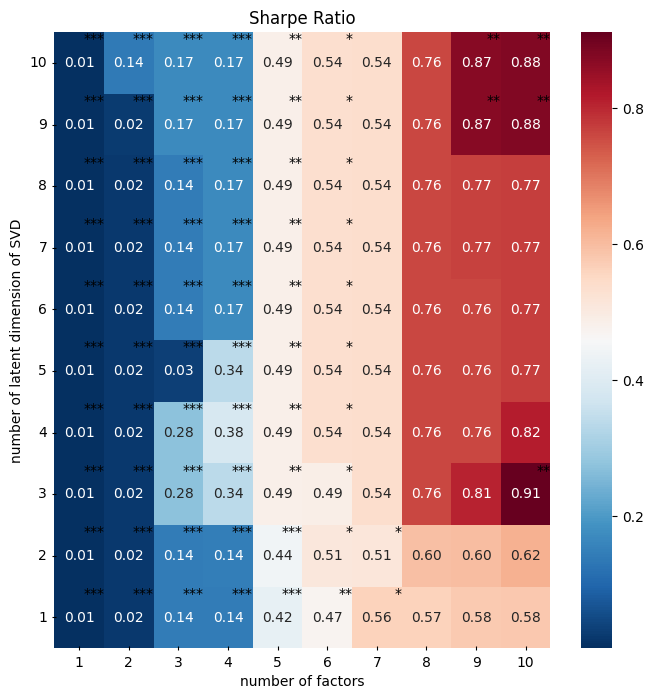

In [164]:
heatmap_sr, heatmap_py, heatmap_bkrs ,heatmap_grs  = make_heatmap(Result,'SR')

In [170]:
#
np.array(dff100.columns)[np.array(Result[5][0][6])]

array(['MKTRF', 'HMLM', 'IVOL', 'PEAD', 'STR', 'UMD'], dtype=object)

In [114]:
np.array(dff100.columns)[np.array(Result[4][0][6])]

array(['HMLM', 'REG', 'STR', 'CLA', 'PEAD', 'IVOL'], dtype=object)

In [157]:
Result_all =[]
Klist = [1,2,3,4,5,6,7,8,9,10]
Result_all  = Parallel(n_jobs=10)(delayed(adj)('AdjSGL',Z,Z.shape[0],[[False]],j, -2 ,0.01,5,10000) for j in Klist)
   


In [174]:
#
np.array(dff100.columns)[np.array(Result_all[5][0][7])]

array(['HMLM', 'QMJ', 'UMD', 'IVOL', 'MKTRF', 'STR', 'REG'], dtype=object)

In [6]:
Result_all=[({10: [93, 99, 31, 2, 72, 94, 78, 86, 71, 98], 8: [93, 99, 31, 2, 72, 94, 78, 98], 7: [93, 99, 31, 2, 72, 94, 78], 9: [93, 99, 31, 2, 72, 94, 78, 98, 91], 6: [99, 93, 31, 2, 94, 98], 4: [99, 93, 31, 2], 5: [99, 93, 31, 2, 98], 3: [99, 93, 2], 2: [99, 93], 1: [99]}, {10: 0.2910786591058437, 8: 0.27132960189695515, 7: 0.18310480178643432, 9: 0.3067597887581354, 6: 0.19221134119802752, 4: 0.11788616189977066, 5: 0.19071631620591023, 3: 0.0988324740380148, 2: 0.04330997206685621, 1: 0.03461521842926587}, {10: [0.0, 12.422130587983638], 8: [0.0, 13.636597614786709], 7: [0.0, 18.891398012871825], 9: [0.0, 15.275271596712898], 6: [0.0, 21.705010751036852], 4: [0.0, 17.502860258916705], 5: [0.0, 16.695211920138185], 3: [0.0, 12.043973358097302], 2: [0.0, 20.761240768799954], 1: [0.0, 17.267411939619976]}, {10: [1.5894136518035396e-07, 5.2418885513256415], 8: [1.2257291626127653e-08, 5.696108463908182], 7: [4.7051251783614134e-12, 6.9142021338889075], 9: [3.1663712398710686e-06, 4.6597217462383345], 6: [6.893818849107447e-12, 6.859839097427414], 4: [3.774758283725532e-15, 7.860608311979033], 5: [4.902078742929916e-12, 6.90838387416241], 3: [2.220446049250313e-16, 8.285242757440859], 2: [0.0, 8.698395619985748], 1: [0.0, 8.765393586649758]}, {10: [1.1102230246251565e-16, 3.5603558912650617, 0.0], 8: [1.1102230246251565e-16, 3.6214865803511196, 0.0], 7: [1.1102230246251565e-16, 4.250615399691412, 0.0], 9: [1.1102230246251565e-16, 3.4130421780188813, 0.0], 6: [1.1102230246251565e-16, 4.1326441832744925, 0.0], 4: [1.1102230246251565e-16, 4.661879021815671, 0.0], 5: [1.1102230246251565e-16, 4.100885112418365, 0.0], 3: [1.1102230246251565e-16, 4.78320287019328, 0.0], 2: [1.1102230246251565e-16, 5.257866631062724, 0.0], 1: [1.1102230246251565e-16, 5.290940575098277, 0.0]}, 1), ({10: [90, 97, 2, 76, 25, 74, 28, 98, 79, 78], 9: [90, 97, 2, 76, 25, 74, 79, 98, 78], 8: [90, 97, 2, 76, 25, 79, 78, 98], 7: [90, 97, 79, 2, 78, 76, 98], 6: [90, 97, 79, 78, 2, 98], 5: [90, 97, 79, 78, 2], 4: [90, 97, 78, 79], 3: [90, 97, 78], 2: [90, 78], 1: [90]}, {10: 0.36252907483617697, 9: 0.35699511178153526, 8: 0.33805968416521837, 7: 0.3289545625893546, 6: 0.3229680034156205, 5: 0.2769698282125622, 4: 0.2723017666601777, 3: 0.2298096786225967, 2: 0.22666241094401263, 1: 0.13974866197493607}, {10: [0.0, 9.03347431061418], 9: [0.0, 9.42770241330514], 8: [0.0, 13.221042524473816], 7: [0.0, 14.943753458326093], 6: [0.0, 16.21417540122383], 5: [0.0, 12.340616872760503], 4: [0.0, 12.571781581460636], 3: [0.0, 19.94013850874714], 2: [0.0, 16.970480413204733], 1: [0.0, 17.467363245234186]}, {10: [0.0001257554271245631, 3.834626133256307], 9: [0.00010493184863413774, 3.8788954258223596], 8: [5.916146821793866e-05, 4.016130642340935], 7: [4.095827751537939e-05, 4.102006493833811], 6: [4.292064747146718e-05, 4.091167774973395], 5: [8.385681813383172e-07, 4.926170533722694], 4: [7.102119585766786e-07, 4.9585501788021995], 3: [8.684232466471542e-08, 5.352301957599022], 2: [9.157386848812621e-09, 5.7456401549105856], 1: [4.519939977853937e-12, 6.919889166170857]}, {10: [1.7763568394002505e-15, 3.0823215691611034, 0.0], 9: [1.4432899320127035e-15, 3.08328893809149, 0.0], 8: [2.220446049250313e-16, 3.1698433575709157, 0.0], 7: [1.1102230246251565e-16, 3.194078345847457, 0.0], 6: [1.1102230246251565e-16, 3.1984682114603498, 0.0], 5: [1.1102230246251565e-16, 3.4683865379774774, 0.0], 4: [1.1102230246251565e-16, 3.4639597467879994, 0.0], 3: [1.1102230246251565e-16, 3.724802701986652, 0.0], 2: [1.1102230246251565e-16, 3.709344168750859, 0.0], 1: [1.1102230246251565e-16, 4.337018165594372, 0.0]}, 2), ({10: [84, 90, 81, 62, 79, 78, 97, 98, 88, 85], 9: [84, 90, 81, 78, 97, 62, 79, 88, 98], 8: [84, 90, 78, 97, 81, 88, 62, 79], 7: [84, 90, 78, 97, 81, 88, 62], 6: [84, 90, 78, 97, 88, 81], 5: [84, 90, 78, 97, 88], 4: [84, 90, 78, 97], 3: [84, 90, 78], 2: [84, 78], 1: [84]}, {10: 0.5287251204022873, 9: 0.473956602175375, 8: 0.3540601679228778, 7: 0.3162442024289219, 6: 0.302353844996977, 5: 0.30185506088366343, 4: 0.2844809742561388, 3: 0.2762869981668921, 2: 0.02477835240300399, 1: 0.008241569029185306}, {10: [1.5121237595394632e-13, 7.386003133969693], 9: [4.3520742565306136e-14, 7.549941092966986], 8: [0.0, 13.743708446799122], 7: [0.0, 16.767135690890278], 6: [0.0, 19.423688647043154], 5: [0.0, 17.694601371307574], 4: [0.0, 13.543101009975446], 3: [0.0, 11.49637239724625], 2: [0.0, 45.52025181165322], 1: [0.0, 28.91510306512162]}, {10: [0.09847151105029028, 1.6523093165189222], 9: [0.6644618872903505, 0.4337611620672736], 8: [0.11280242085510706, 1.5857218477688533], 7: [0.050075478176420996, 1.9593186738225745], 6: [0.024142454067760166, 2.2548546435280414], 5: [0.02795619502829383, 2.197900531498615], 4: [0.0002656433986640838, 3.646686785094887], 3: [6.541235258383793e-05, 3.992383931521696], 2: [1.3322676295501878e-15, 8.00221115551701], 1: [0.0, 8.330383593565047]}, {10: [1.2797325177338337e-07, 2.143250835610195, 0.0], 9: [9.096426945021108e-10, 2.4026232932225566, 0.0], 8: [1.4432899320127035e-15, 3.068165321930027, 0.0], 7: [1.1102230246251565e-16, 3.2768389427299303, 0.0], 6: [1.1102230246251565e-16, 3.3332883372695683, 0.0], 5: [1.1102230246251565e-16, 3.3014812339118587, 0.0], 4: [1.1102230246251565e-16, 3.3817306909493388, 0.0], 3: [1.1102230246251565e-16, 3.40144858328417, 0.0], 2: [1.1102230246251565e-16, 5.445210425081735, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 3), ({10: [84, 6, 62, 90, 10, 78, 81, 88, 98, 91], 9: [84, 6, 62, 90, 10, 78, 88, 91, 98], 8: [84, 90, 6, 78, 62, 10, 88, 91], 7: [84, 90, 6, 78, 62, 88, 10], 6: [84, 90, 6, 78, 62, 88], 5: [84, 90, 6, 78, 62], 4: [84, 90, 78, 6], 3: [84, 90, 78], 2: [84, 90], 1: [84]}, {10: 0.4791787927916367, 9: 0.47917382784473883, 8: 0.33932080068323694, 7: 0.30449120674413893, 6: 0.3013002799117569, 5: 0.27982634692223934, 4: 0.2789116088373642, 3: 0.2762869981668921, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 12.218549100375384], 9: [0.0, 11.220762050457378], 8: [0.0, 20.365856278657592], 7: [0.0, 17.81865774812618], 6: [0.0, 17.753769935423662], 5: [0.0, 14.381358383750674], 4: [0.0, 11.614105023180924], 3: [0.0, 11.49637239724625], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.5241362176443807, 0.6369825383958927], 9: [0.48115870518737314, 0.70444015727448], 8: [0.1409548362141373, 1.4722446049902282], 7: [0.01862038919519482, 2.3530448268504047], 6: [0.015142714525227197, 2.4289477480650365], 5: [6.479808206294457e-05, 3.9946200514232224], 4: [6.229606504604135e-05, 4.0039404014110245], 3: [6.541235258383793e-05, 3.992383931521696], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [1.0877526657182557e-09, 2.401128778105414, 0.0], 9: [1.5442659373476886e-09, 2.3747691612402178, 0.0], 8: [2.220446049250313e-16, 3.161741164330967, 0.0], 7: [1.1102230246251565e-16, 3.3548010035477938, 0.0], 6: [1.1102230246251565e-16, 3.3402935657737576, 0.0], 5: [1.1102230246251565e-16, 3.448898097146105, 0.0], 4: [1.1102230246251565e-16, 3.4191384407823304, 0.0], 3: [1.1102230246251565e-16, 3.40144858328417, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 4), ({9: [84, 78, 6, 90, 98, 10, 91, 16, 88], 8: [84, 90, 78, 6, 98, 91, 88, 10], 7: [84, 90, 78, 6, 98, 91, 88], 6: [84, 90, 78, 98, 91, 6], 5: [84, 90, 78, 98, 91], 4: [84, 90, 78, 98], 3: [84, 90, 78], 2: [84, 90], 1: [84]}, {9: 0.4702227740543503, 8: 0.46897833386575666, 7: 0.4667422469819218, 6: 0.40922948293421557, 5: 0.4072902622215315, 4: 0.38663381872838276, 3: 0.2762869981668921, 2: 0.1701307089092924, 1: 0.008241569029185306}, {9: [0.0, 10.08208140034672], 8: [0.0, 9.629007286946097], 7: [0.0, 9.545811174801997], 6: [0.0, 8.825590957086082], 5: [0.0, 8.33081075569181], 4: [2.3578490289111187e-06, 4.7200515316444], 3: [0.0, 11.49637239724625], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {9: [0.5750317008446997, 0.5606565382322216], 8: [0.6324795068623075, 0.4782398437406457], 7: [0.7056849600671309, 0.37765761248012775], 6: [0.0771938237407177, 1.7672054713332228], 5: [0.07987564517011192, 1.7514080626566615], 4: [0.02807800587315956, 2.1961947656561165], 3: [6.541235258383793e-05, 3.992383931521696], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {9: [6.205901348366183e-10, 2.4226791120163664, 0.0], 8: [7.778148125581197e-10, 2.402979758080452, 0.0], 7: [8.784040161913254e-10, 2.388961657088242, 0.0], 6: [2.558064871038823e-12, 2.6770894963360137, 0.0], 5: [3.0120350658080497e-12, 2.659812293852707, 0.0], 4: [4.0967229608668276e-13, 2.748903579402406, 0.0], 3: [1.1102230246251565e-16, 3.40144858328417, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 5), ({10: [84, 85, 91, 90, 25, 98, 88, 6, 79, 31], 9: [84, 85, 91, 90, 25, 98, 88, 6, 79], 8: [84, 91, 85, 90, 25, 98, 88, 6], 7: [84, 91, 90, 85, 98, 88, 25], 6: [84, 90, 91, 85, 98, 88], 5: [84, 90, 91, 98, 85], 4: [84, 90, 91, 98], 3: [84, 90, 91], 2: [84, 90], 1: [84]}, {10: 0.5552292308026452, 9: 0.5458550485988516, 8: 0.531601146258827, 7: 0.53130094622154, 6: 0.4720481251071962, 5: 0.41022862842816876, 4: 0.406424846385704, 3: 0.29861688796139807, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [1.5972045908085875e-10, 6.395788887290118], 9: [4.3995884713154965e-09, 5.868423295980165], 8: [1.0300649222472202e-12, 7.126439527345134], 7: [9.33186861118429e-12, 6.816449184552551], 6: [0.0, 12.86434944162017], 5: [0.0, 12.912530115017223], 4: [1.060374010819487e-11, 6.798059823008432], 3: [0.0, 13.16540444524288], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.003158371366922763, 2.951888323017399], 9: [0.022485462699590508, 2.282065682556552], 8: [0.0353513752576573, 2.104310448109383], 7: [0.03282334283441113, 2.1342375200102524], 6: [0.2274784934270182, 1.2068796561870183], 5: [0.3565388719189957, 0.9219802608391735], 4: [0.08746248648557353, 1.7089377201186036], 3: [0.000584502177221724, 3.438705751063881], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [1.3095522013450989e-06, 2.0120483025680875, 0.0], 9: [7.893709336181942e-07, 2.0353241136789157, 0.0], 8: [3.0699446385007434e-07, 2.082515958823701, 0.0], 7: [4.0386924027302484e-07, 2.0615811776272346, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053323, 0.0], 5: [4.19964063524958e-12, 2.6433039154316247, 0.0], 4: [3.994027331089001e-12, 2.636930375700478, 0.0], 3: [1.1102230246251565e-16, 3.254325518359082, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 6), ({9: [84, 91, 85, 90, 98, 88, 25, 31, 24], 8: [84, 91, 85, 90, 98, 88, 25, 31], 7: [84, 91, 85, 90, 98, 88, 31], 6: [84, 91, 90, 85, 98, 88], 5: [84, 90, 91, 88, 98], 4: [84, 90, 91, 88], 3: [84, 90, 91], 2: [84, 90], 1: [84]}, {9: 0.551410729070262, 8: 0.5409222867144405, 7: 0.4731516519344564, 6: 0.4720481251071962, 5: 0.4642562683867928, 4: 0.3212924837581452, 3: 0.29861688796139807, 2: 0.1701307089092924, 1: 0.008241569029185306}, {9: [0.0, 8.307580273392407], 8: [1.5698553568199713e-13, 7.381190407205182], 7: [0.0, 14.673140977142001], 6: [0.0, 12.864349441620176], 5: [1.006705829809107e-11, 6.8055414409598285], 4: [0.0, 16.05730859482783], 3: [0.0, 13.16540444524288], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {9: [0.0012773962108092451, 3.221010156549307], 8: [0.006360879167239153, 2.728574129900091], 7: [0.07792490681038933, 1.762855246275668], 6: [0.22747849342701754, 1.2068796561870205], 5: [0.6614275426397342, 0.43794308406985616], 4: [0.0733519276251069, 1.7906347448890483], 3: [0.000584502177221724, 3.438705751063881], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {9: [1.2685971028103538e-06, 2.0083594121183492, 0.0], 8: [6.933685450238869e-07, 2.03704332441588, 0.0], 7: [1.6822695458884596e-09, 2.355176276592978, 0.0], 6: [2.1199783040160014e-09, 2.33585551610533, 0.0], 5: [1.3607208693144912e-09, 2.351573921680584, 0.0], 4: [1.1102230246251565e-16, 3.1424095509748535, 0.0], 3: [1.1102230246251565e-16, 3.254325518359082, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 7), ({10: [84, 85, 91, 88, 90, 98, 62, 6, 31, 25], 9: [84, 85, 91, 88, 90, 98, 62, 6, 31], 8: [84, 85, 91, 90, 88, 98, 6, 62], 7: [84, 85, 91, 90, 88, 98, 6], 6: [84, 85, 91, 90, 88, 98], 5: [84, 90, 91, 88, 85], 4: [84, 90, 91, 88], 3: [84, 90, 91], 2: [84, 90], 1: [84]}, {10: 0.5483078533350042, 9: 0.49927530668111353, 8: 0.4953525893726367, 7: 0.48096536556882297, 6: 0.47204812510719624, 5: 0.32379494204523546, 4: 0.3212924837581452, 3: 0.29861688796139807, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 9.623404571865915], 9: [0.0, 15.214887209841114], 8: [0.0, 13.19168668120363], 7: [0.0, 11.627562998062567], 6: [0.0, 12.864349441620153], 5: [0.0, 23.43942213123563], 4: [0.0, 16.05730859482783], 3: [0.0, 13.16540444524288], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.003965854885689568, 2.8808649815453475], 9: [0.03167886916173335, 2.1484393557285517], 8: [0.12766712835775818, 1.523366139927555], 7: [0.20314077871999814, 1.2726541938032687], 6: [0.22747849342701665, 1.206879656187023], 5: [0.22611251794657727, 1.2104336976723933], 4: [0.0733519276251069, 1.7906347448890483], 3: [0.000584502177221724, 3.438705751063881], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [7.245717315029765e-07, 2.045877649047742, 0.0], 9: [1.1227697993554386e-08, 2.269262149122307, 0.0], 8: [1.0719928389413269e-08, 2.264741359502966, 0.0], 7: [3.6700044114823527e-09, 2.3143840423677444, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053287, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934502, 0.0], 4: [1.1102230246251565e-16, 3.1424095509748535, 0.0], 3: [1.1102230246251565e-16, 3.254325518359082, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 8), ({10: [84, 88, 91, 85, 90, 98, 62, 6, 31, 57], 9: [84, 88, 91, 85, 90, 98, 62, 6, 31], 8: [84, 88, 91, 85, 90, 98, 62, 31], 7: [84, 88, 91, 85, 90, 98, 62], 6: [84, 88, 91, 90, 85, 98], 5: [84, 88, 91, 90, 85], 4: [84, 88, 91, 90], 3: [84, 88, 91], 2: [84, 88], 1: [88]}, {10: 0.5023156558108594, 9: 0.49927530668111364, 8: 0.4864788698234994, 7: 0.48546057711662227, 6: 0.4720481251071962, 5: 0.32379494204523546, 4: 0.32129248375814506, 3: 0.07993659492063435, 2: 0.019782300624978797, 1: 0.016203917181884957}, {10: [0.0, 16.526059126745672], 9: [0.0, 15.214887209841105], 8: [0.0, 17.85257741223677], 7: [0.0, 15.121175298823742], 6: [0.0, 12.864349441620162], 5: [0.0, 23.43942213123562], 4: [0.0, 16.057308594827838], 3: [0.0, 40.72278203785438], 2: [0.0, 38.724200859047734], 1: [0.0, 30.35921182876951]}, {10: [0.035479667872475584, 2.1028410322885014], 9: [0.03167886916173357, 2.1484393557285495], 8: [0.04737540425752562, 1.9829286111709246], 7: [0.15000720474336782, 1.4395060229150503], 6: [0.22747849342701754, 1.2068796561870203], 5: [0.2261125179465786, 1.2104336976723906], 4: [0.07335192762510712, 1.7906347448890465], 3: [1.5336127923148979e-09, 6.040790194007612], 2: [5.262457136723242e-13, 7.218360778296648], 1: [2.220446049250313e-16, 8.208082041989968]}, {10: [1.0778752557172311e-08, 2.278589473663602, 0.0], 9: [1.1227697993554386e-08, 2.2692621491223033, 0.0], 8: [4.510553597292244e-09, 2.310704620564172, 0.0], 7: [5.713874151602738e-09, 2.291110822986303, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053323, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934445, 0.0], 4: [1.1102230246251565e-16, 3.142409550974843, 0.0], 3: [1.1102230246251565e-16, 4.95708739532345, 0.0], 2: [1.1102230246251565e-16, 5.4968828391701265, 0.0], 1: [1.1102230246251565e-16, 5.478304024035181, 0.0]}, 9), ({10: [84, 91, 88, 85, 90, 98, 13, 79, 31, 62], 9: [84, 88, 91, 85, 90, 98, 13, 79, 31], 8: [84, 88, 91, 85, 90, 98, 13, 31], 7: [84, 88, 91, 85, 90, 98, 13], 6: [88, 84, 91, 90, 85, 98], 5: [88, 84, 90, 91, 85], 4: [88, 84, 90, 91], 3: [88, 84, 90], 2: [88, 84], 1: [88]}, {10: 0.5584222255115497, 9: 0.5582013253261114, 8: 0.47655292938690286, 7: 0.4757374517037575, 6: 0.4720481251071962, 5: 0.3237949420452355, 4: 0.3212924837581452, 3: 0.2193006144238577, 2: 0.019782300624978797, 1: 0.016203917181884957}, {10: [1.0480505352461478e-13, 7.434561502331677], 9: [1.4357868671766028e-07, 5.26060947744466], 8: [0.0, 14.886668445288358], 7: [0.0, 13.08595535501457], 6: [0.0, 12.864349441620176], 5: [0.0, 23.439422131235595], 4: [0.0, 16.057308594827838], 3: [0.0, 21.74348747536471], 2: [0.0, 38.72420085904775], 1: [0.0, 30.35921182876951]}, {10: [0.0037613668921792076, 2.8975108819387025], 9: [0.004679881595315072, 2.8282802653705956], 8: [0.08222547124390434, 1.737916821319567], 7: [0.23769168178713218, 1.1807760977836639], 6: [0.22747849342701665, 1.206879656187023], 5: [0.2261125179465795, 1.2104336976723882], 4: [0.07335192762510712, 1.7906347448890472], 3: [0.0001397609613973394, 3.808590911980814], 2: [5.262457136723242e-13, 7.218360778296648], 1: [2.220446049250313e-16, 8.208082041989968]}, {10: [1.7142905129885477e-06, 1.9965433138156745, 0.0], 9: [2.2436405366921264e-06, 1.9756621441113396, 0.0], 8: [1.6781160905310344e-09, 2.3627726794599506, 0.0], 7: [2.1809543060413716e-09, 2.3416290405674154, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053314, 0.0], 5: [1.1102230246251565e-16, 3.159535409293442, 0.0], 4: [1.1102230246251565e-16, 3.1424095509748478, 0.0], 3: [1.1102230246251565e-16, 3.8013339721533854, 0.0], 2: [1.1102230246251565e-16, 5.49688283917014, 0.0], 1: [1.1102230246251565e-16, 5.478304024035181, 0.0]}, 10)]

In [78]:
np.array(dff100.columns)[np.array(Result_all[4][0][7])]

array(['HMLM', 'REG', 'MKTRF', 'CLA', 'PEAD', 'IVOL', 'STR'], dtype=object)

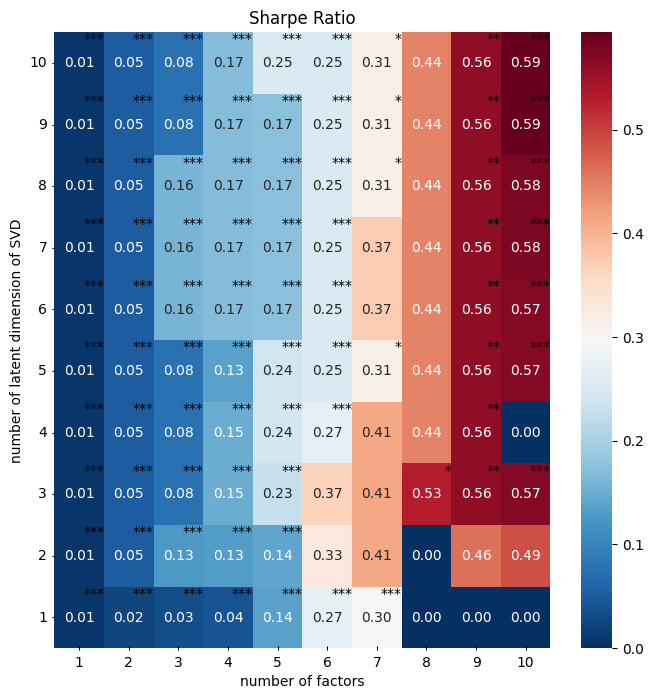

In [173]:
heatmap_sr, heatmap_py, heatmap_bkrs ,heatmap_grs  = make_heatmap(Result_all,'SR')

In [159]:
Result1 =[]
Klist = [1,2,3,4,5,6,7,8,9,10]

Result1= Parallel(n_jobs=10)(delayed(adj)('AdjSGL',Z,36*12,[[False]],j, -1 ,0.07,5,5000) for j in Klist)
 


In [138]:
Result_1=[({9: [90, 93, 2, 72, 21, 78, 99, 86, 97], 8: [90, 93, 2, 78, 72, 21, 86, 97], 7: [90, 93, 2, 78, 72, 21, 86], 6: [90, 2, 78, 93, 72, 21], 5: [90, 2, 78, 93, 72], 4: [90, 2, 78, 72], 3: [90, 2, 78], 2: [90, 78], 1: [90]}, {9: 0.43712195963297196, 8: 0.4368283416738285, 7: 0.3903495886532858, 6: 0.38314744469332535, 5: 0.3776553526556436, 4: 0.3596200411560942, 3: 0.35868362473460014, 2: 0.35865339051973166, 1: 0.2598611521922185}, {9: [3.623582744971543e-08, 5.50827924709063], 8: [4.708950083198715e-07, 5.037807363236733], 7: [0.0, 9.54851437939984], 6: [0.0, 8.87243850920398], 5: [0.0, 8.851710030845885], 4: [0.0, 11.091752953217602], 3: [0.0, 9.766630370993045], 2: [0.0, 8.59853776385165], 1: [0.0, 14.029020675947285]}, {9: [5.771702449308691e-09, 5.823241596386592], 8: [8.126795236762518e-09, 5.765807140758746], 7: [1.134964566773533e-09, 6.089171548986799], 6: [8.126601613867024e-10, 6.142434850786644], 5: [7.020537484692113e-10, 6.165624809583416], 4: [2.8336955004704123e-10, 6.307614109304565], 3: [3.9524827855075273e-10, 6.2558927902845625], 2: [4.129097064264897e-10, 6.2490677710203535], 1: [1.7985612998927536e-13, 7.363006266097757]}, {9: [1.1102230246251565e-16, 4.064229302811495, 0.0], 8: [1.1102230246251565e-16, 4.021611843195813, 0.0], 7: [1.1102230246251565e-16, 4.23070363575033, 0.0], 6: [1.1102230246251565e-16, 4.22588228224708, 0.0], 5: [1.1102230246251565e-16, 4.212000611945703, 0.0], 4: [1.1102230246251565e-16, 4.269290312208505, 0.0], 3: [1.1102230246251565e-16, 4.23054804795106, 0.0], 2: [1.1102230246251565e-16, 4.187547760345268, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 1), ({10: [47, 28, 90, 94, 3, 97, 42, 25, 56, 98], 9: [47, 28, 90, 94, 3, 97, 42, 25, 56], 8: [47, 28, 90, 94, 3, 97, 42, 25], 7: [47, 90, 28, 94, 42, 97, 25], 6: [47, 90, 94, 28, 42, 25], 5: [90, 47, 94, 28, 25], 4: [90, 47, 94, 25], 3: [90, 47, 94], 2: [90, 47], 1: [90]}, {10: 0.4986613214871465, 9: 0.4064919355154195, 8: 0.4058999690706566, 7: 0.40528576726010196, 6: 0.38747197336442246, 5: 0.38508770501947115, 4: 0.3718506082738105, 3: 0.3409138042360792, 2: 0.33326208649408207, 1: 0.2598611521922185}, {10: [0.0, 8.688897022137764], 9: [7.549516567451064e-15, 7.774335783641887], 8: [4.489741911584133e-13, 7.239936530163808], 7: [1.4164225348167747e-12, 7.082439188925038], 6: [3.597122599785507e-14, 7.574625911245407], 5: [1.2212453270876722e-14, 7.713526130590427], 4: [1.1102230246251565e-15, 8.017234455450783], 3: [0.0, 11.277355608122859], 2: [6.157074849966193e-12, 6.875967030198753], 1: [0.0, 14.029020675947285]}, {10: [6.212884875456126e-07, 4.98447944838923], 9: [1.2263456916628002e-10, 6.43603532243368], 8: [1.2622503042791777e-10, 6.431651233765483], 7: [1.4116685598253298e-10, 6.414628413641343], 6: [5.649858358935944e-11, 6.55271922060021], 5: [3.24578142141263e-11, 6.634965792991943], 4: [2.2822188583404568e-11, 6.68672341482874], 3: [8.821388064461644e-12, 6.824530668412378], 2: [4.199973702156967e-12, 6.9302806819350975], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [1.1102230246251565e-16, 3.78916766080718, 0.0], 9: [1.1102230246251565e-16, 4.232190835030402, 0.0], 8: [1.1102230246251565e-16, 4.189470864808558, 0.0], 7: [1.1102230246251565e-16, 4.147794451414918, 0.0], 6: [1.1102230246251565e-16, 4.201702466758466, 0.0], 5: [1.1102230246251565e-16, 4.170646416015418, 0.0], 4: [1.1102230246251565e-16, 4.200395624195673, 0.0], 3: [1.1102230246251565e-16, 4.331968807096419, 0.0], 2: [1.1102230246251565e-16, 4.331815582863969, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 2), ({10: [84, 90, 85, 98, 79, 11, 97, 88, 94, 78], 9: [84, 90, 85, 98, 79, 97, 88, 11, 94], 8: [84, 90, 85, 98, 79, 88, 97, 11], 7: [84, 90, 85, 79, 98, 88, 97], 6: [84, 90, 85, 79, 98, 88], 5: [84, 90, 85, 79, 98], 4: [84, 90, 85, 79], 3: [84, 90, 85], 2: [84, 90], 1: [90]}, {10: 0.7834071457867628, 9: 0.7347060999509242, 8: 0.7237916476953371, 7: 0.7233741172501141, 6: 0.6618730902113146, 5: 0.49132051230933094, 4: 0.35091915144123786, 3: 0.27714597590228296, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [6.585576528550519e-11, 6.529804173405828], 9: [7.017253444985272e-11, 6.520287862213186], 8: [6.427818499687987e-09, 5.80522875435736], 7: [1.148328545585997e-07, 5.301535273392487], 6: [0.0, 8.391421773834418], 5: [0.0, 15.586772944580346], 4: [0.0, 15.662372809849693], 3: [0.0, 20.326567120349434], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.05914190385947915, 1.8871369806049998], 9: [0.8902028330072278, 0.1380475560700095], 8: [0.5287928277188887, 0.6298498487645806], 7: [0.5634669234341669, 0.5776996382590082], 6: [0.23649538873805565, 1.1837920532049346], 5: [3.0274409213992826e-05, 4.171392335219337], 4: [9.131979616938679e-10, 6.12388676853292], 3: [6.559353060708872e-11, 6.530401470981392], 2: [1.411537553508424e-11, 6.75671651919049], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [3.4875302645787087e-10, 2.595191634955265, 0.0], 9: [2.593891768043477e-11, 2.741156897607272, 0.0], 8: [1.8704926496582175e-11, 2.7513781303457385, 0.0], 7: [2.5939139725039695e-11, 2.7233177373968456, 0.0], 6: [6.933342788784103e-13, 2.924761854714655, 0.0], 5: [1.1102230246251565e-16, 3.624610083958344, 0.0], 4: [1.1102230246251565e-16, 4.319061759319938, 0.0], 3: [1.1102230246251565e-16, 4.7191580161188655, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 3), ({10: [84, 90, 6, 85, 98, 88, 54, 78, 97, 62], 9: [84, 90, 6, 85, 98, 88, 78, 54, 97], 8: [84, 90, 6, 85, 98, 88, 78, 97], 7: [84, 90, 6, 85, 98, 88, 78], 6: [84, 90, 6, 88, 98, 78], 5: [84, 90, 6, 88, 98], 4: [84, 90, 6, 88], 3: [84, 90, 6], 2: [84, 90], 1: [84]}, {10: 0.756903894167362, 9: 0.7543614264807411, 8: 0.7489903497151403, 7: 0.7134881830010154, 6: 0.6842471089063589, 5: 0.6154772926264295, 4: 0.38760567342099955, 3: 0.29175465105775783, 2: 0.2682375976977933, 1: 0.01117340050373691}, {10: [4.013012144810091e-11, 6.603596156580973], 9: [2.460724513042578e-09, 5.964042658720072], 8: [6.427909315931402e-10, 6.17956343749936], 7: [9.392486788328824e-14, 7.449139345439212], 6: [0.0009115040841327637, 3.316506679810963], 5: [5.440092820663267e-14, 7.520863350797643], 4: [0.0, 15.445075081862155], 3: [0.0, 17.580841441413675], 2: [0.0, 20.803689832417096], 1: [0.0, 27.419532705390413]}, {10: [0.2638151057004925, 1.1174192558146823], 9: [0.30913957630639954, 1.0170291210154507], 8: [0.2895392328977249, 1.0591329561321885], 7: [0.4667510709743592, 0.7277754240133979], 6: [0.8548587717049871, 0.1829225721391814], 5: [0.06656317801878009, 1.8346121440515382], 4: [2.0559070945669333e-06, 4.7478497111247355], 3: [3.0359492697584756e-11, 6.644816355032156], 2: [1.411537553508424e-11, 6.75671651919049], 1: [0.0, 9.037211435712337]}, {10: [7.1436412341086e-11, 2.6899882643400277, 0.0], 9: [8.683720409408124e-11, 2.669570806542895, 0.0], 8: [8.866185563505269e-11, 2.659744918020825, 0.0], 7: [1.3938628029563915e-11, 2.7596262821385573, 0.0], 6: [3.047451180293592e-12, 2.83898952029229, 0.0], 5: [4.1300296516055823e-14, 3.0774558798510165, 0.0], 4: [1.1102230246251565e-16, 4.1134373651010385, 0.0], 3: [1.1102230246251565e-16, 4.627080567299336, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 4), ({10: [84, 90, 6, 88, 98, 85, 54, 78, 10, 11], 9: [84, 90, 6, 88, 98, 54, 85, 78, 10], 8: [84, 90, 6, 88, 98, 54, 85, 78], 7: [84, 90, 6, 88, 98, 78, 54], 6: [84, 90, 6, 88, 98, 78], 5: [84, 90, 88, 6, 98], 4: [84, 90, 88, 6], 3: [84, 90, 88], 2: [84, 90], 1: [84]}, {10: 0.71973464329934, 9: 0.7191510875347569, 8: 0.7191089985654101, 7: 0.6842560368567931, 6: 0.6842471089063589, 5: 0.6154772926264296, 4: 0.3876056734209994, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.01117340050373691}, {10: [0.0, 8.703573147643942], 9: [4.618527782440651e-14, 7.542265472904683], 8: [1.0229594948896192e-12, 7.127385251422875], 7: [0.0003036729865084631, 3.6121464407241946], 6: [0.0009115040841327637, 3.316506679810963], 5: [5.440092820663267e-14, 7.5208633507976765], 4: [0.0, 15.445075081862157], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 27.419532705390413]}, {10: [0.5544190746666238, 0.5911512629661616], 9: [0.49911232093200164, 0.6758871120857652], 8: [0.4865716584313833, 0.6957719497745426], 7: [0.7888027122039734, 0.2678656797103034], 6: [0.8548587717049871, 0.1829225721391814], 5: [0.06656317801877987, 1.8346121440515397], 4: [2.0559070945669333e-06, 4.74784971112474], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.75671651919049], 1: [0.0, 9.037211435712337]}, {10: [7.0397021545431926e-12, 2.8278572583086383, 0.0], 9: [9.753864382844313e-12, 2.7989696666455766, 0.0], 8: [1.3929635223064452e-11, 2.7687022174099205, 0.0], 7: [2.1206369993365115e-12, 2.8694821551337157, 0.0], 6: [3.047451180293592e-12, 2.83898952029229, 0.0], 5: [4.1300296516055823e-14, 3.0774558798510134, 0.0], 4: [1.1102230246251565e-16, 4.113437365101038, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 5), ({10: [84, 85, 91, 90, 88, 98, 20, 79, 6, 25], 9: [84, 85, 90, 91, 88, 98, 79, 6, 20], 8: [84, 90, 85, 88, 91, 98, 6, 79], 7: [84, 90, 85, 88, 91, 98, 6], 6: [84, 90, 85, 88, 91, 98], 5: [84, 90, 85, 88, 98], 4: [84, 90, 85, 88], 3: [90, 84, 88], 2: [90, 84], 1: [90]}, {10: 0.8291175773536654, 9: 0.8280315814381493, 8: 0.8280312902158244, 7: 0.7382122819206057, 6: 0.7247875048160594, 5: 0.6091126476055546, 4: 0.3688984399837695, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [2.274502364230102e-09, 5.976880988147801], 9: [3.176433338580864e-09, 5.922210160017072], 8: [2.4930291320224285e-07, 5.158224259344196], 7: [0.0, 10.610488074141767], 6: [0.0, 11.162099074917181], 5: [0.0, 11.30831181747914], 4: [0.0, 19.99602042568463], 3: [0.0, 19.67842751259804], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.02833631889544108, 2.1925985056111834], 9: [0.02692993656779641, 2.2125318709962634], 8: [0.02702148349793143, 2.2112073232403318], 7: [0.15580432560593227, 1.4193248669081415], 6: [0.16646367433019016, 1.3836564505231397], 5: [0.1138290905002588, 1.5812141087350255], 4: [2.9412104900483627e-06, 4.6748831410784515], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.756716519190489], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [4.72102557047549e-09, 2.438149771543921, 0.0], 9: [6.133260899154891e-09, 2.4149568649747817, 0.0], 8: [8.424147046603991e-09, 2.3887082892756197, 0.0], 7: [6.492117954337573e-11, 2.669596054273953, 0.0], 6: [4.013867016539052e-11, 2.689244124687576, 0.0], 5: [2.631228568361621e-14, 3.103451371059328, 0.0], 4: [1.1102230246251565e-16, 4.216912449776015, 0.0], 3: [1.1102230246251565e-16, 4.20482828135539, 0.0], 2: [1.1102230246251565e-16, 4.727609823961962, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 6), ({10: [84, 85, 90, 88, 91, 98, 6, 20, 25, 79], 9: [84, 85, 90, 88, 91, 98, 6, 25, 79], 8: [84, 90, 85, 88, 91, 98, 6, 25], 7: [84, 90, 85, 88, 91, 98, 6], 6: [84, 90, 88, 85, 91, 98], 5: [84, 90, 88, 85, 91], 4: [84, 90, 88, 85], 3: [84, 90, 88], 2: [90, 88], 1: [90]}, {10: 0.8291175773536653, 9: 0.8291061473884439, 8: 0.7918846076198672, 7: 0.7382122819206057, 6: 0.7247875048160594, 5: 0.4681526194285688, 4: 0.3688984399837695, 3: 0.3632650715881808, 2: 0.36326060932708015, 1: 0.2598611521922185}, {10: [2.274502364230102e-09, 5.976880988147757], 9: [1.4527059977176293e-07, 5.258455156522585], 8: [2.220446049250313e-15, 7.933961087668483], 7: [0.0, 10.610488074141767], 6: [0.0, 11.162099074917133], 5: [0.0, 20.329159572778995], 4: [0.0, 19.99602042568461], 3: [0.0, 19.678427512598045], 2: [0.0, 14.327162616426513], 1: [0.0, 14.029020675947285]}, {10: [0.02833631889544108, 2.192598505611182], 9: [0.027005997135328474, 2.2114311153398876], 8: [0.06291933796918703, 1.8597610665306978], 7: [0.15580432560593227, 1.4193248669081415], 6: [0.16646367433019016, 1.3836564505231406], 5: [0.04153973297625502, 2.0381020022400036], 4: [2.9412104900483627e-06, 4.674883141078455], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [2.2372059760300544e-09, 5.979574965227249], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [4.72102557047549e-09, 2.4381497715439218, 0.0], 9: [6.50571319038562e-09, 2.4113947836358434, 0.0], 8: [1.1158346469031244e-09, 2.509690553283835, 0.0], 7: [6.492117954337573e-11, 2.669596054273953, 0.0], 6: [4.013867016539052e-11, 2.68924412468758, 0.0], 5: [1.1102230246251565e-16, 3.736955534139273, 0.0], 4: [1.1102230246251565e-16, 4.216912449776026, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.16194658212582, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 7), ({9: [84, 85, 88, 90, 91, 98, 79, 11, 24], 8: [84, 85, 90, 88, 91, 98, 79, 11], 7: [84, 85, 90, 88, 91, 98, 79], 6: [84, 90, 85, 88, 91, 98], 4: [84, 90, 88, 85], 3: [84, 90, 88], 2: [88, 90], 1: [88]}, {9: 0.8379773845994193, 8: 0.8303121072732482, 7: 0.8257678505781099, 6: 0.7247875048160594, 4: 0.3688984399837695, 3: 0.3632650715881808, 2: 0.36326060932708004, 1: 0.023508461578625933}, {9: [8.340661494798951e-12, 6.832571867503404], 8: [1.0571747477428062e-08, 5.72129127706386], 7: [4.316595298980985e-07, 5.054438186898896], 6: [0.0, 11.162099074917181], 4: [0.0, 19.99602042568461], 3: [0.0, 19.678427512598045], 2: [0.0, 14.327162616426508], 1: [0.0, 31.764578145053658]}, {9: [0.007140744764911888, 2.690208226971015], 8: [0.02619881834507387, 2.223251908994079], 7: [0.023501398356900793, 2.265183873139135], 6: [0.16646367433019016, 1.3836564505231397], 4: [2.9412104900483627e-06, 4.674883141078455], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [2.2372059760300544e-09, 5.979574965227245], 1: [0.0, 9.000381241054663]}, {9: [1.0548121931464038e-08, 2.38214662830653, 0.0], 8: [9.537397760439603e-09, 2.3812347107774303, 0.0], 7: [1.0191500754430649e-08, 2.3703784040262392, 0.0], 6: [4.013867016539052e-11, 2.689244124687576, 0.0], 4: [1.1102230246251565e-16, 4.216912449776026, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.161946582125812, 0.0], 1: [1.1102230246251565e-16, 6.600704962205906, 0.0]}, 8), ({10: [88, 84, 85, 91, 90, 98, 13, 79, 31, 11], 9: [88, 84, 85, 91, 90, 98, 13, 79, 31], 8: [88, 84, 85, 91, 90, 98, 13, 79], 7: [88, 84, 85, 91, 90, 98, 13], 6: [88, 84, 85, 90, 91, 98], 5: [88, 84, 90, 85, 91], 4: [88, 84, 90, 85], 3: [88, 84, 90], 2: [88, 84], 1: [88]}, {10: 0.849049468634734, 9: 0.847974936470517, 8: 0.833134442388802, 7: 0.7282890107760551, 6: 0.7247875048160594, 5: 0.4681526194285688, 4: 0.3688984399837695, 3: 0.36326507158818083, 2: 0.027988824432775207, 1: 0.023508461578625933}, {10: [2.0764234776038393e-10, 6.355579430076969], 9: [2.42817590923039e-07, 5.163158326422726], 8: [1.9733090279139276e-05, 4.267889639982389], 7: [0.0, 11.376959134808843], 6: [0.0, 11.162099074917112], 5: [0.0, 20.32915957277895], 4: [0.0, 19.996020425684623], 3: [0.0, 19.678427512598052], 2: [0.0, 39.5156935222847], 1: [0.0, 31.764578145053658]}, {10: [0.005487450125182258, 2.776932929132002], 9: [0.004363359381089005, 2.850623558257654], 8: [0.02202899424189031, 2.28986757773108], 7: [0.1784654485950541, 1.3454949575438246], 6: [0.1664636743301906, 1.3836564505231386], 5: [0.041539732976254795, 2.0381020022400045], 4: [2.9412104900483627e-06, 4.6748831410784515], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [4.440892098500626e-16, 8.150791442679715], 1: [0.0, 9.000381241054663]}, {10: [1.3974341572797755e-08, 2.3721031510904345, 0.0], 9: [1.805149085765123e-08, 2.3495216082699533, 0.0], 8: [1.1114430376046869e-08, 2.3720124789475165, 0.0], 7: [3.5219382965578916e-11, 2.7054211599562583, 0.0], 6: [4.013867016539052e-11, 2.68924412468758, 0.0], 5: [1.1102230246251565e-16, 3.736955534139279, 0.0], 4: [1.1102230246251565e-16, 4.21691244977603, 0.0], 3: [1.1102230246251565e-16, 4.204828281355391, 0.0], 2: [1.1102230246251565e-16, 6.624232065109301, 0.0], 1: [1.1102230246251565e-16, 6.600704962205906, 0.0]}, 9), ({10: [88, 84, 85, 91, 90, 98, 13, 79, 31, 11], 9: [88, 84, 85, 91, 90, 98, 13, 79, 31], 8: [88, 84, 85, 91, 90, 98, 13, 79], 7: [88, 84, 85, 91, 90, 98, 13], 6: [88, 84, 85, 90, 91, 98], 5: [88, 84, 90, 85, 91], 4: [88, 84, 90, 85], 3: [88, 84, 90], 2: [88, 84], 1: [88]}, {10: 0.849049468634734, 9: 0.847974936470517, 8: 0.833134442388802, 7: 0.7282890107760551, 6: 0.7247875048160594, 5: 0.4681526194285688, 4: 0.3688984399837695, 3: 0.36326507158818083, 2: 0.027988824432775207, 1: 0.023508461578625933}, {10: [2.0764234776038393e-10, 6.355579430076969], 9: [2.42817590923039e-07, 5.163158326422726], 8: [1.9733090279139276e-05, 4.267889639982389], 7: [0.0, 11.376959134808843], 6: [0.0, 11.162099074917112], 5: [0.0, 20.32915957277895], 4: [0.0, 19.996020425684623], 3: [0.0, 19.678427512598052], 2: [0.0, 39.5156935222847], 1: [0.0, 31.764578145053658]}, {10: [0.005487450125182258, 2.776932929132002], 9: [0.004363359381089005, 2.850623558257654], 8: [0.02202899424189031, 2.28986757773108], 7: [0.1784654485950541, 1.3454949575438246], 6: [0.1664636743301906, 1.3836564505231386], 5: [0.041539732976254795, 2.0381020022400045], 4: [2.9412104900483627e-06, 4.6748831410784515], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [4.440892098500626e-16, 8.150791442679715], 1: [0.0, 9.000381241054663]}, {10: [1.3974341572797755e-08, 2.3721031510904345, 0.0], 9: [1.805149085765123e-08, 2.3495216082699533, 0.0], 8: [1.1114430376046869e-08, 2.3720124789475165, 0.0], 7: [3.5219382965578916e-11, 2.7054211599562583, 0.0], 6: [4.013867016539052e-11, 2.68924412468758, 0.0], 5: [1.1102230246251565e-16, 3.736955534139279, 0.0], 4: [1.1102230246251565e-16, 4.21691244977603, 0.0], 3: [1.1102230246251565e-16, 4.204828281355391, 0.0], 2: [1.1102230246251565e-16, 6.624232065109301, 0.0], 1: [1.1102230246251565e-16, 6.600704962205906, 0.0]}, 10)]

In [176]:
#
np.array(dff100.columns)[np.array(Result_1[4][0][6])]

array(['HMLM', 'REG', 'CLA', 'STR', 'PEAD', 'MKTRF'], dtype=object)

In [141]:
np.array(dff100.columns)[np.array(Result_1[4][0][6])]

array(['HMLM', 'REG', 'CLA', 'STR', 'PEAD', 'MKTRF'], dtype=object)

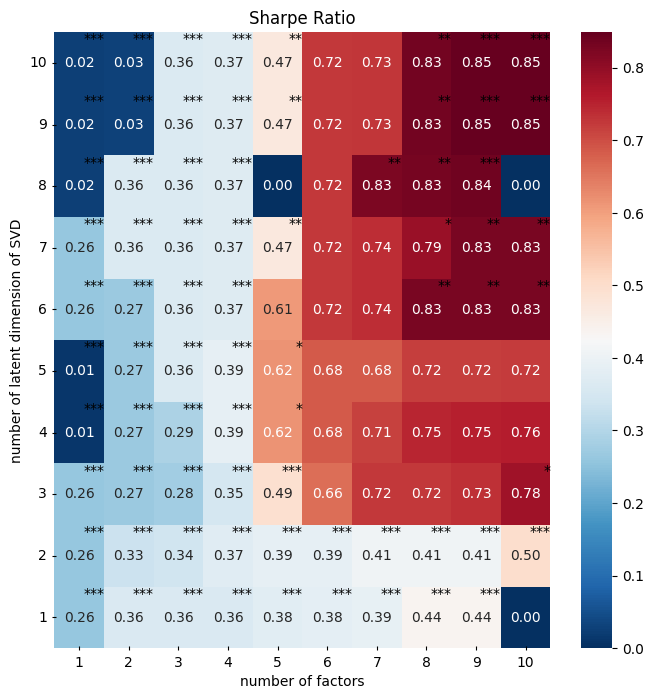

In [175]:
heatmap_sr, heatmap_py, heatmap_bkrs ,heatmap_grs  = make_heatmap(Result_1,'SR')

In [40]:
np.array(dff100.columns)[np.array(Result_all[5][0][7])]

array(['HMLM', 'IVOL', 'REG', 'QMJ', 'PEAD', 'STR', 'DTV12'], dtype=object)

In [160]:
Result1_all =[]
Klist = [1,2,3,4,5,6,7,8,9,10]
Result1_all= Parallel(n_jobs=10)(delayed(adj)('AdjSGL',Z,Z.shape[0],[[False]],j, -1 ,0.01,5,10000) for j in Klist)


In [47]:
Result1_all=[({9: [99, 93, 31, 82, 2, 72, 71, 50, 86], 10: [99, 93, 31, 82, 2, 72, 71, 50, 86, 78], 7: [93, 99, 31, 2, 72, 82, 71], 8: [93, 99, 31, 2, 72, 82, 71, 86], 5: [93, 99, 31, 2, 72], 6: [93, 99, 31, 2, 72, 71], 4: [93, 99, 31, 2], 3: [93, 99, 2], 2: [93, 99], 1: [99]}, {9: 0.16337231159010537, 10: 0.21403179744802345, 7: 0.12864153287302038, 8: 0.16202184820869864, 5: 0.12582547649869918, 6: 0.12670218339570596, 4: 0.1178861618997707, 3: 0.09883247403801484, 2: 0.0433099720668562, 1: 0.03461521842926587}, {9: [0.0, 17.246608934248055], 10: [0.0, 13.213389159439494], 7: [0.0, 19.240383500727], 8: [0.0, 16.88886961058285], 5: [0.0, 19.015059945170307], 6: [0.0, 18.974494100027513], 4: [0.0, 17.502860258916716], 3: [0.0, 12.043973358097297], 2: [0.0, 20.76124076879996], 1: [0.0, 17.267411939619976]}, {9: [5.870859354217828e-13, 7.203464026587942], 10: [1.323956499987844e-10, 6.4243943509412444], 7: [1.176836406102666e-14, 7.7193929119861435], 8: [6.719069745031447e-13, 7.185046687852074], 5: [5.773159728050814e-15, 7.80749059207961], 6: [5.10702591327572e-15, 7.822330143694435], 4: [3.774758283725532e-15, 7.860608311979033], 3: [2.220446049250313e-16, 8.285242757440859], 2: [0.0, 8.69839561998575], 1: [0.0, 8.765393586649758]}, {9: [1.1102230246251565e-16, 4.510911515111407, 0.0], 10: [1.1102230246251565e-16, 4.138884698833786, 0.0], 7: [1.1102230246251565e-16, 4.715170059446183, 0.0], 8: [1.1102230246251565e-16, 4.4733814422049285, 0.0], 5: [1.1102230246251565e-16, 4.640614072610751, 0.0], 6: [1.1102230246251565e-16, 4.6821940253725, 0.0], 4: [1.1102230246251565e-16, 4.661879021815671, 0.0], 3: [1.1102230246251565e-16, 4.78320287019328, 0.0], 2: [1.1102230246251565e-16, 5.257866631062737, 0.0], 1: [1.1102230246251565e-16, 5.290940575098277, 0.0]}, 1), ({10: [90, 97, 76, 28, 56, 2, 25, 93, 74, 94], 9: [90, 97, 76, 28, 56, 2, 25, 74, 93], 8: [90, 97, 76, 28, 56, 2, 25, 74], 7: [90, 97, 28, 76, 2, 25, 79], 6: [90, 97, 28, 76, 2, 79], 5: [90, 97, 76, 28, 2], 4: [90, 97, 76, 28], 3: [90, 97, 76], 2: [90, 97], 1: [90]}, {10: 0.2799020657868388, 9: 0.2666710998672373, 8: 0.24363836067503952, 7: 0.23593888005207025, 6: 0.23564493405976203, 5: 0.2299925378280605, 4: 0.22657783892259037, 3: 0.18723180361109054, 2: 0.18723085008832435, 1: 0.13974866197493607}, {10: [0.0, 11.179001576046835], 9: [0.0, 11.5382851240686], 8: [0.0, 13.986627186450502], 7: [0.0, 14.129358201880573], 6: [0.0, 13.393064616200805], 5: [0.0, 12.398557014847526], 4: [0.0, 12.572932784560223], 3: [0.0, 18.637469772721584], 2: [0.0, 18.135100219319693], 1: [0.0, 17.467363245234186]}, {10: [1.6295452343051409e-07, 5.237286624913699], 9: [6.272209507329762e-08, 5.410861997131822], 8: [2.182078695511791e-08, 5.5969084404156355], 7: [1.3238687479599776e-08, 5.68295530585557], 6: [1.7181283729073016e-08, 5.638224085000552], 5: [2.0648562637504142e-08, 5.606477648523059], 4: [2.9466134643385544e-08, 5.544579551153318], 3: [2.5245208146174036e-09, 5.959861327772853], 2: [3.4352458655462215e-09, 5.909319153073922], 1: [4.519939977853937e-12, 6.919889166170857]}, {10: [1.1102230246251565e-16, 3.639959509148548, 0.0], 9: [1.1102230246251565e-16, 3.6949558551068855, 0.0], 8: [1.1102230246251565e-16, 3.8231363063601838, 0.0], 7: [1.1102230246251565e-16, 3.8390808657937217, 0.0], 6: [1.1102230246251565e-16, 3.800408503875465, 0.0], 5: [1.1102230246251565e-16, 3.8018717305341037, 0.0], 4: [1.1102230246251565e-16, 3.787242370631066, 0.0], 3: [1.1102230246251565e-16, 4.043247478542764, 0.0], 2: [1.1102230246251565e-16, 4.0019971630999605, 0.0], 1: [1.1102230246251565e-16, 4.337018165594372, 0.0]}, 2), ({10: [84, 90, 81, 97, 62, 78, 79, 98, 85, 56], 9: [84, 90, 81, 97, 78, 62, 79, 85, 98], 8: [84, 90, 97, 81, 78, 62, 79, 85], 7: [84, 90, 97, 81, 78, 62, 85], 6: [84, 90, 97, 81, 78, 62], 5: [84, 90, 97, 78, 81], 4: [84, 90, 97, 78], 3: [84, 90, 78], 2: [84, 90], 1: [84]}, {10: 0.4821381237617757, 9: 0.4805601959627604, 8: 0.39422638232585755, 7: 0.35051998531862855, 6: 0.2948421751593239, 5: 0.28472564212698387, 4: 0.2844809742561388, 3: 0.2762869981668921, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [1.486211154144712e-11, 6.749241521924793], 9: [4.2076041983918344e-08, 5.481909101117007], 8: [0.0, 10.02757378523484], 7: [0.0, 15.794583091543469], 6: [0.0, 13.433919545985571], 5: [0.0, 15.153120435782215], 4: [0.0, 13.543101009975436], 3: [0.0, 11.49637239724625], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.8422415903605343, 0.19902704317199474], 9: [0.84018214718271, 0.20166049663154065], 8: [0.07188375297925798, 1.7998536310175601], 7: [0.026047868856426293, 2.225497349590265], 6: [0.0004612668125656416, 3.5022960280661497], 5: [0.00021279437181509486, 3.7033221596336388], 4: [0.0002656433986640838, 3.6466867850948894], 3: [6.541235258383793e-05, 3.992383931521696], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [1.4680505699971036e-09, 2.385241957578553, 0.0], 9: [1.7757011416819068e-09, 2.3674005236634192, 0.0], 8: [2.0383694732117874e-13, 2.823204220943583, 0.0], 7: [1.4432899320127035e-15, 3.057223812244907, 0.0], 6: [1.1102230246251565e-16, 3.383483066276657, 0.0], 5: [1.1102230246251565e-16, 3.4156747125222657, 0.0], 4: [1.1102230246251565e-16, 3.3817306909493374, 0.0], 3: [1.1102230246251565e-16, 3.40144858328417, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 3), ({10: [84, 6, 62, 81, 90, 78, 10, 98, 88, 97], 9: [84, 6, 62, 90, 78, 81, 10, 98, 88], 8: [84, 6, 62, 90, 78, 81, 10, 98], 7: [84, 6, 62, 90, 78, 10, 81], 6: [84, 6, 90, 62, 78, 10], 5: [84, 6, 90, 78, 62], 4: [84, 90, 78, 6], 3: [84, 90, 78], 2: [84, 90], 1: [84]}, {10: 0.44826393078620935, 9: 0.4401660687169044, 8: 0.39056429338005133, 7: 0.2842032099402809, 6: 0.2838961229034265, 5: 0.2798263469222393, 4: 0.2789116088373642, 3: 0.2762869981668921, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 11.133351458201936], 9: [0.0, 10.96139330399427], 8: [0.0, 9.303288225568144], 7: [0.0, 15.96890985353675], 6: [0.0, 14.328595263059334], 5: [0.0, 14.381358383750678], 4: [0.0, 11.614105023180924], 3: [0.0, 11.49637239724625], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.9156402747066577, 0.10592699618278194], 9: [0.7614281673745302, 0.3036058851953353], 8: [0.023959641345105087, 2.2577757896676593], 7: [6.773284469452356e-05, 3.984112278810613], 6: [8.770051116901989e-05, 3.9223197161521726], 5: [6.479808206294457e-05, 3.9946200514232233], 4: [6.229606504604135e-05, 4.0039404014110245], 3: [6.541235258383793e-05, 3.992383931521696], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [4.241529349968687e-11, 2.570973371322846, 0.0], 9: [2.562816625584219e-11, 2.5879131707748844, 0.0], 8: [1.3200551762793111e-13, 2.844951854208291, 0.0], 7: [1.1102230246251565e-16, 3.492736684053866, 0.0], 6: [1.1102230246251565e-16, 3.457678683011766, 0.0], 5: [1.1102230246251565e-16, 3.4488980971461087, 0.0], 4: [1.1102230246251565e-16, 3.4191384407823304, 0.0], 3: [1.1102230246251565e-16, 3.40144858328417, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 4), ({10: [84, 78, 6, 90, 98, 10, 16, 88, 91, 62], 9: [84, 78, 6, 90, 98, 10, 16, 88, 91], 8: [84, 78, 90, 6, 98, 10, 88, 16], 7: [84, 78, 90, 6, 98, 88, 10], 6: [84, 78, 90, 6, 98, 88], 5: [84, 90, 78, 98, 6], 4: [84, 90, 78, 98], 3: [84, 90, 78], 2: [84, 90], 1: [84]}, {10: 0.48199909988270817, 9: 0.4702227740543503, 8: 0.44187635883550797, 7: 0.438499750254931, 6: 0.43830353007211637, 5: 0.38668745704989904, 4: 0.38663381872838276, 3: 0.2762869981668921, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 10.973168381906683], 9: [0.0, 10.08208140034671], 8: [2.1871393585115584e-13, 7.336803693855333], 7: [2.886579864025407e-15, 7.892251863748001], 6: [2.773337115513641e-13, 7.305015581871787], 5: [1.602801136257881e-08, 5.650179787502313], 4: [2.3578490289111187e-06, 4.7200515316444], 3: [0.0, 11.49637239724625], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.4092532570930718, 0.8252084496677841], 9: [0.5750317008447006, 0.5606565382322203], 8: [0.8665252735687712, 0.16807373278573126], 7: [0.7659523722140769, 0.29767349835704315], 6: [0.7426699129208822, 0.32831974976716827], 5: [0.025288637452043572, 2.236964850159363], 4: [0.02807800587315956, 2.1961947656561165], 3: [6.541235258383793e-05, 3.992383931521696], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [1.4475791676460403e-09, 2.385986870630963, 0.0], 9: [6.205901348366183e-10, 2.422679112016363, 0.0], 8: [4.4877324079095615e-11, 2.550300877991826, 0.0], 7: [4.5107695356705335e-11, 2.5414202320688797, 0.0], 6: [6.374889505167403e-11, 2.51545253428189, 0.0], 5: [2.781108676686017e-13, 2.7775283735260867, 0.0], 4: [4.0967229608668276e-13, 2.748903579402406, 0.0], 3: [1.1102230246251565e-16, 3.40144858328417, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 5), ({10: [84, 91, 85, 90, 25, 98, 88, 79, 10, 6], 9: [84, 91, 85, 90, 25, 98, 88, 79, 6], 8: [84, 91, 85, 90, 25, 98, 88, 79], 7: [84, 91, 90, 85, 98, 25, 88], 6: [84, 90, 91, 85, 98, 25], 5: [84, 90, 91, 85, 98], 4: [84, 90, 91, 85], 3: [84, 90, 91], 2: [84, 90], 1: [84]}, {10: 0.5514268704984047, 9: 0.5458550485988513, 8: 0.5444992237605341, 7: 0.53130094622154, 6: 0.47760489326463185, 5: 0.41022862842816865, 4: 0.2999786204460505, 3: 0.29861688796139807, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [9.690782976079504e-08, 5.332428689734321], 9: [4.3995884713154965e-09, 5.868423295980155], 8: [2.4618261207365322e-08, 5.575950015572106], 7: [9.33186861118429e-12, 6.816449184552564], 6: [5.313749440460924e-12, 6.896934422015116], 5: [0.0, 12.912530115017285], 4: [0.0, 19.718007018796698], 3: [0.0, 13.16540444524288], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.01609095702695873, 2.4068459213055293], 9: [0.022485462699590952, 2.2820656825565466], 8: [0.022118580064548254, 2.2883253714108096], 7: [0.03282334283441157, 2.134237520010248], 6: [0.9362406606366738, 0.0799957192097594], 5: [0.3565388719189959, 0.9219802608391728], 4: [0.005239895954594065, 2.7919036300683184], 3: [0.000584502177221724, 3.438705751063881], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [9.473397925008342e-07, 2.030595587687044, 0.0], 9: [7.893709336181942e-07, 2.035324113678911, 0.0], 8: [9.428624697660482e-07, 2.019739171347399, 0.0], 7: [4.0386924027302484e-07, 2.0615811776272395, 0.0], 6: [3.6865251962225898e-09, 2.3070676546280664, 0.0], 5: [4.19964063524958e-12, 2.6433039154316162, 0.0], 4: [1.1102230246251565e-16, 3.279324566030653, 0.0], 3: [1.1102230246251565e-16, 3.254325518359082, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 6), ({10: [84, 91, 85, 90, 98, 25, 88, 93, 24, 31], 9: [84, 91, 85, 90, 98, 25, 88, 93, 24], 8: [84, 91, 85, 90, 98, 88, 25, 93], 7: [84, 91, 90, 85, 98, 88, 25], 6: [84, 91, 90, 85, 98, 88], 5: [84, 90, 91, 98, 85], 4: [84, 90, 91, 98], 3: [84, 90, 91], 2: [84, 90], 1: [84]}, {10: 0.5552492980057214, 9: 0.5444129727506628, 8: 0.537881297229772, 7: 0.53130094622154, 6: 0.4720481251071962, 5: 0.41022862842816876, 4: 0.406424846385704, 3: 0.29861688796139807, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 11.374890436819244], 9: [0.0, 10.957470786925072], 8: [0.0, 10.088529967705256], 7: [9.33186861118429e-12, 6.816449184552551], 6: [0.0, 12.864349441620176], 5: [0.0, 12.912530115017223], 4: [1.060374010819487e-11, 6.798059823008432], 3: [0.0, 13.16540444524288], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.0010603359597096684, 3.2740080356290555], 9: [0.010717079563907994, 2.551790967142936], 8: [0.025444837337461168, 2.2345814872867313], 7: [0.03282334283441113, 2.1342375200102524], 6: [0.22747849342701754, 1.2068796561870205], 5: [0.3565388719189957, 0.9219802608391735], 4: [0.08746248648557353, 1.7089377201186036], 3: [0.000584502177221724, 3.438705751063881], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [1.3117802515338894e-06, 2.0119506586446234, 0.0], 9: [6.970994849142542e-07, 2.042354995710159, 0.0], 8: [5.326917573711398e-07, 2.051818030457757, 0.0], 7: [4.0386924027302484e-07, 2.0615811776272346, 0.0], 6: [2.1199783040160014e-09, 2.33585551610533, 0.0], 5: [4.19964063524958e-12, 2.6433039154316247, 0.0], 4: [3.994027331089001e-12, 2.636930375700478, 0.0], 3: [1.1102230246251565e-16, 3.254325518359082, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 7), ({10: [84, 91, 85, 88, 90, 98, 79, 25, 24, 57], 8: [84, 91, 85, 90, 88, 98, 79, 25], 7: [84, 91, 85, 90, 88, 98, 79], 6: [84, 91, 90, 85, 88, 98], 5: [84, 90, 91, 85, 88], 4: [84, 90, 91, 85], 3: [84, 90, 91], 2: [84, 90], 1: [84]}, {10: 0.5640246414008966, 8: 0.5444992237605342, 7: 0.5437754910896572, 6: 0.47204812510719624, 5: 0.3237949420452354, 4: 0.2999786204460505, 3: 0.29861688796139807, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [6.15394402103675e-09, 5.812519696616433], 8: [2.4618261207365322e-08, 5.575950015572087], 7: [6.270971868449493e-07, 4.982679663998728], 6: [0.0, 12.864349441620153], 5: [0.0, 23.439422131235613], 4: [0.0, 19.718007018796698], 3: [0.0, 13.16540444524288], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.00652729358261972, 2.7200454913753633], 8: [0.022118580064548254, 2.2883253714108083], 7: [0.03166783643170734, 2.1485783875512623], 6: [0.22747849342701665, 1.206879656187023], 5: [0.22611251794657816, 1.2104336976723915], 4: [0.005239895954594065, 2.7919036300683184], 3: [0.000584502177221724, 3.438705751063881], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [2.734143243809939e-06, 1.9694913111913428, 0.0], 8: [9.428624697660482e-07, 2.0197391713473953, 0.0], 7: [1.185063564945743e-06, 2.0014786996680836, 0.0], 6: [2.1199783040160014e-09, 2.33585551610533, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934467, 0.0], 4: [1.1102230246251565e-16, 3.279324566030653, 0.0], 3: [1.1102230246251565e-16, 3.254325518359082, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 8), ({10: [84, 88, 91, 85, 90, 98, 25, 62, 79, 57], 9: [84, 88, 91, 85, 90, 98, 25, 62, 79], 8: [84, 88, 91, 85, 90, 98, 25, 79], 7: [84, 88, 91, 85, 90, 98, 25], 6: [84, 88, 91, 90, 85, 98], 5: [84, 88, 91, 90, 85], 4: [84, 88, 91, 90], 3: [84, 88, 91], 2: [84, 88], 1: [84]}, {10: 0.5544574061187704, 9: 0.546831700368539, 8: 0.5444992237605341, 7: 0.53130094622154, 6: 0.4720481251071962, 5: 0.32379494204523546, 4: 0.32129248375814506, 3: 0.07993659492063435, 2: 0.019782300624978797, 1: 0.008241569029185306}, {10: [2.3310242625029787e-12, 7.013093010636716], 9: [3.310685059432217e-13, 7.2811186901966645], 8: [2.4618261207365322e-08, 5.575950015572096], 7: [9.33186861118429e-12, 6.816449184552558], 6: [0.0, 12.864349441620162], 5: [0.0, 23.43942213123562], 4: [0.0, 16.057308594827838], 3: [0.0, 40.72278203785438], 2: [0.0, 38.724200859047734], 1: [0.0, 28.91510306512162]}, {10: [0.017743705294578138, 2.3709234565457544], 9: [0.01848054045805081, 2.3558467428082452], 8: [0.022118580064548476, 2.2883253714108047], 7: [0.03282334283441113, 2.1342375200102515], 6: [0.22747849342701754, 1.2068796561870203], 5: [0.2261125179465786, 1.2104336976723906], 4: [0.07335192762510712, 1.7906347448890465], 3: [1.5336127923148979e-09, 6.040790194007612], 2: [5.262457136723242e-13, 7.218360778296648], 1: [0.0, 8.330383593565047]}, {10: [1.2265823003954068e-06, 2.015805795975429, 0.0], 9: [8.584712604120526e-07, 2.0305698657471374, 0.0], 8: [9.428624697660482e-07, 2.0197391713473976, 0.0], 7: [4.0386924027302484e-07, 2.0615811776272395, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053323, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934445, 0.0], 4: [1.1102230246251565e-16, 3.142409550974843, 0.0], 3: [1.1102230246251565e-16, 4.95708739532345, 0.0], 2: [1.1102230246251565e-16, 5.4968828391701265, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 9), ({10: [84, 91, 88, 85, 90, 98, 13, 79, 24, 31], 9: [84, 91, 88, 85, 90, 98, 13, 79, 24], 8: [84, 88, 91, 85, 90, 98, 13, 79], 7: [84, 88, 91, 85, 90, 98, 13], 6: [84, 88, 91, 90, 85, 98], 5: [84, 88, 91, 90, 85], 4: [88, 84, 91, 90], 3: [88, 84, 90], 2: [88, 84], 1: [88]}, {10: 0.5734381296146339, 9: 0.5647963661655072, 8: 0.5493934797291551, 7: 0.4757374517037575, 6: 0.4720481251071962, 5: 0.32379494204523546, 4: 0.32129248375814506, 3: 0.2193006144238577, 2: 0.019782300624978797, 1: 0.016203917181884957}, {10: [2.944513588731823e-06, 4.674652785341045], 9: [2.0207164336927264e-05, 4.2625893674935105], 8: [4.8630251152648185e-06, 4.570611750402973], 7: [0.0, 13.08595535501457], 6: [0.0, 12.864349441620162], 5: [0.0, 23.43942213123562], 4: [0.0, 16.057308594827838], 3: [0.0, 21.74348747536471], 2: [0.0, 38.72420085904775], 1: [0.0, 30.35921182876951]}, {10: [0.0007516578373878424, 3.370008798051207], 9: [0.009057632472762478, 2.6098711761228213], 8: [0.031640754682275896, 2.1489198414801898], 7: [0.23769168178713218, 1.1807760977836639], 6: [0.22747849342701754, 1.2068796561870203], 5: [0.2261125179465786, 1.2104336976723906], 4: [0.07335192762510667, 1.7906347448890505], 3: [0.0001397609613973394, 3.808590911980814], 2: [5.262457136723242e-13, 7.218360778296648], 1: [2.220446049250313e-16, 8.208082041989968]}, {10: [5.892416806596579e-06, 1.9244708311008538, 0.0], 9: [3.863521668256986e-06, 1.9441781365311468, 0.0], 8: [1.4289408732937048e-06, 1.9961916747350008, 0.0], 7: [2.1809543060413716e-09, 2.3416290405674154, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053323, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934445, 0.0], 4: [1.1102230246251565e-16, 3.1424095509748455, 0.0], 3: [1.1102230246251565e-16, 3.8013339721533854, 0.0], 2: [1.1102230246251565e-16, 5.49688283917014, 0.0], 1: [1.1102230246251565e-16, 5.478304024035181, 0.0]}, 10)]

In [86]:
np.array(dff100.columns)[np.array(Result1_all[4][0][6])]

array(['HMLM', 'MKTRF', 'REG', 'CLA', 'PEAD', 'STR'], dtype=object)

In [178]:
#
np.array(dff100.columns)[np.array(Result1_all[4][0][6])]

array(['HMLM', 'QMJ', 'UMD', 'MKTRF', 'STR', 'BETA'], dtype=object)

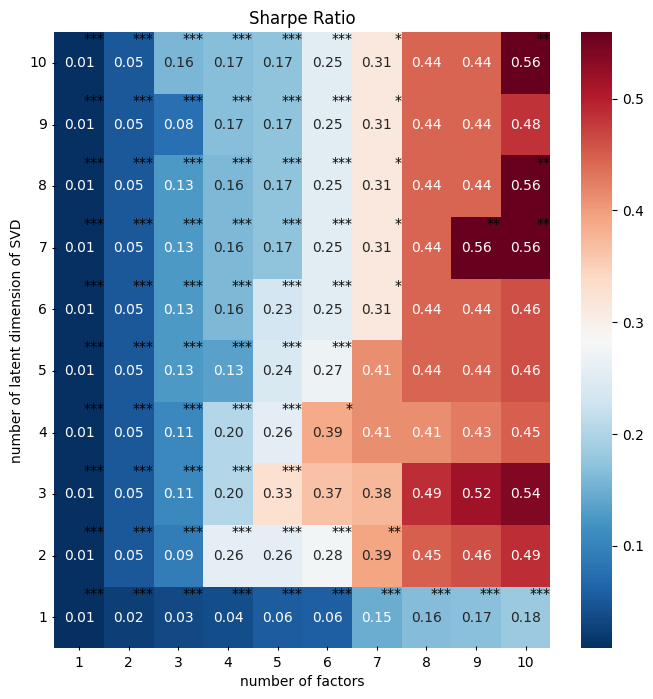

In [177]:
heatmap_sr, heatmap_py, heatmap_bkrs ,heatmap_grs  = make_heatmap(Result1_all,'SR')

## AdjDGL

In [179]:
Result3 =[]
Klist = [1,2,3,4,5,6,7,8,9,10]
Result3= Parallel(n_jobs=10)(delayed(adj)('AdjDGL',Z,36*12,[[False]],j, -1 ,0.1,5,3000) for j in Klist)


In [73]:
Result3 = [({10: [90, 94, 78, 98, 2, 31, 79, 72, 86, 24], 9: [90, 94, 78, 98, 2, 31, 79, 72, 86], 8: [90, 94, 78, 98, 2, 31, 79, 72], 7: [90, 94, 78, 98, 2, 31, 79], 6: [90, 94, 78, 98, 2, 31], 5: [90, 94, 78, 98, 2], 4: [90, 94, 78, 98], 3: [90, 94, 98], 2: [90, 94], 1: [90]}, {10: 0.5702216999972619, 9: 0.5695993849210316, 8: 0.5629968086216384, 7: 0.5361714226291578, 6: 0.466850796838702, 5: 0.4654986258724162, 4: 0.46507774252752115, 3: 0.37127615810607006, 2: 0.25986615401563523, 1: 0.2598611521922185}, {10: [0.0, 9.09915725892227], 9: [0.0, 8.781573306888575], 8: [0.0, 8.846135281634314], 7: [0.0, 12.327854230914713], 6: [0.0, 17.80422495326985], 5: [0.0, 12.30297058461386], 4: [0.0, 10.962169593148339], 3: [0.0, 14.032802568246877], 2: [0.0, 16.878033823899557], 1: [0.0, 14.029020675947285]}, {10: [0.0013929644299459643, 3.196104931428211], 9: [0.0007722375145606808, 3.3625585368866115], 8: [0.0005829976890283639, 3.439403453135812], 7: [0.00028185922933654517, 3.6314262303126377], 6: [2.379146826370082e-05, 4.22596905955025], 5: [1.0033657555252873e-05, 4.416446811370156], 4: [1.1004948524018232e-05, 4.396422781856617], 3: [1.6171208594428776e-08, 5.64865066843452], 2: [3.3950620093037287e-13, 7.277707448918811], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [2.220446049250313e-16, 3.4483670227716443, 0.0], 9: [3.3306690738754696e-16, 3.4132715638166955, 0.0], 8: [2.220446049250313e-16, 3.4056769969307363, 0.0], 7: [1.1102230246251565e-16, 3.4902281823315735, 0.0], 6: [1.1102230246251565e-16, 3.7831967478469593, 0.0], 5: [1.1102230246251565e-16, 3.750052008354804, 0.0], 4: [1.1102230246251565e-16, 3.7130485490127807, 0.0], 3: [1.1102230246251565e-16, 4.160267868268517, 0.0], 2: [1.1102230246251565e-16, 4.781534060454591, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 1), ({10: [90, 47, 98, 94, 25, 78, 28, 97, 79, 42], 9: [90, 47, 98, 25, 94, 78, 28, 97, 79], 8: [90, 47, 25, 98, 78, 94, 97, 79], 7: [90, 47, 79, 78, 98, 25, 97], 6: [90, 47, 79, 78, 98, 25], 5: [90, 47, 79, 78, 98], 4: [90, 47, 79, 78], 3: [90, 47, 79], 2: [90, 47], 1: [90]}, {10: 0.5420215497254228, 9: 0.5414307261806177, 8: 0.5272403280144915, 7: 0.5271972700470149, 6: 0.525880135040362, 5: 0.5171686036604349, 4: 0.4269230581068096, 3: 0.3579258331652637, 2: 0.33326208649408207, 1: 0.2598611521922185}, {10: [1.7763568394002505e-15, 7.949739055098651], 9: [5.995204332975845e-15, 7.803353220799033], 8: [0.0, 8.46389920555253], 7: [2.169109336591646e-11, 6.6941625775744384], 6: [4.819531440602987e-10, 6.224870731174108], 5: [3.483879851273741e-13, 7.274243719765512], 4: [7.279431061935071e-06, 4.485350094108039], 3: [8.450506427948312e-08, 5.3572352450943095], 2: [6.157074849966193e-12, 6.875967030198753], 1: [0.0, 14.029020675947285]}, {10: [9.057226919839678e-05, 3.914551862437201], 9: [9.00478088121659e-05, 3.9159529520475305], 8: [5.793776585227839e-05, 4.021056253690838], 7: [1.6929505403551204e-05, 4.301958461694689], 6: [1.6514622368735132e-05, 4.307451590883164], 5: [1.2498143446837418e-05, 4.368712036770311], 4: [5.1346971119414775e-09, 5.842747001986223], 3: [7.863265594210134e-12, 6.841015833092157], 2: [4.199973702156967e-12, 6.9302806819350975], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [1.1102230246251565e-16, 3.5788915859810455, 0.0], 9: [1.1102230246251565e-16, 3.5423182027855584, 0.0], 8: [1.1102230246251565e-16, 3.5699008423847522, 0.0], 7: [1.1102230246251565e-16, 3.5317150296780166, 0.0], 6: [1.1102230246251565e-16, 3.500208465116972, 0.0], 5: [1.1102230246251565e-16, 3.5033173487533564, 0.0], 4: [1.1102230246251565e-16, 3.904805077878721, 0.0], 3: [1.1102230246251565e-16, 4.234818938056985, 0.0], 2: [1.1102230246251565e-16, 4.331815582863969, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 2), ({10: [84, 90, 78, 88, 79, 94, 85, 97, 98, 91], 9: [84, 90, 78, 88, 79, 94, 85, 97, 98], 8: [84, 90, 78, 88, 79, 94, 85, 97], 7: [84, 90, 78, 88, 79, 85, 94], 6: [84, 90, 78, 88, 85, 94], 5: [84, 90, 78, 88, 85], 4: [84, 90, 78, 88], 3: [84, 90, 78], 2: [84, 90], 1: [90]}, {10: 0.8870697527358906, 9: 0.7833270840802364, 8: 0.5321865870017841, 7: 0.5275927083769498, 6: 0.44209026741657437, 5: 0.4415819962802727, 4: 0.43966625847484214, 3: 0.3911614527083917, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [7.75993713730827e-10, 6.149761841765319], 9: [1.5460949853718375e-08, 5.656368318030269], 8: [0.0, 15.775929416860691], 7: [0.0, 14.110341190465286], 6: [0.0, 20.644957152535685], 5: [0.0, 18.124131589444957], 4: [0.0, 11.794979331941741], 3: [0.0, 8.547203114888234], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.0017915626110278637, 3.1227723531316376], 9: [0.05029442357158209, 1.9574513730083714], 8: [0.09308797935755875, 1.679328808906051], 7: [0.08438204210126798, 1.725807544457922], 6: [0.016386734993339536, 2.400186177573107], 5: [0.005871944128223117, 2.7548478131980674], 4: [0.0012668834917883842, 3.2233777800892818], 3: [1.713255437518768e-07, 5.228030186029233], 2: [1.411537553508424e-11, 6.75671651919049], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [1.0169234987422726e-07, 2.249987559464425, 0.0], 9: [4.872914294296038e-10, 2.566952066434981, 0.0], 8: [1.1102230246251565e-16, 3.5467266430224917, 0.0], 7: [1.1102230246251565e-16, 3.529876681147443, 0.0], 6: [1.1102230246251565e-16, 3.908796400737685, 0.0], 5: [1.1102230246251565e-16, 3.8702469968166775, 0.0], 4: [1.1102230246251565e-16, 3.8396302864579264, 0.0], 3: [1.1102230246251565e-16, 4.051877026773364, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 3), ({10: [84, 90, 6, 88, 85, 78, 91, 97, 98, 62], 9: [84, 90, 6, 88, 78, 85, 91, 97, 98], 8: [84, 90, 6, 88, 78, 85, 91, 97], 7: [84, 90, 6, 88, 78, 85, 91], 6: [84, 90, 6, 88, 78, 85], 5: [84, 90, 6, 88, 78], 4: [84, 90, 88, 78], 3: [84, 90, 88], 2: [84, 90], 1: [84]}, {10: 0.8385896954046212, 9: 0.8370457737733171, 8: 0.5760022236423175, 7: 0.4942802031347339, 6: 0.4638736477647532, 5: 0.452671008511922, 4: 0.4396662584748422, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.01117340050373691}, {10: [2.220446049250313e-16, 8.183859455817233], 9: [2.0228263508670352e-13, 7.347343813215053], 8: [0.0, 16.804905504685568], 7: [0.0, 22.51333157549032], 6: [0.0, 15.888261148620517], 5: [0.0, 10.217057323034037], 4: [0.0, 11.794979331941741], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 27.419532705390413]}, {10: [0.01580972674348735, 2.4132786689553885], 9: [0.025203556997156262, 2.2382684078557373], 8: [0.26446907082973636, 1.1158903549965928], 7: [0.0580124552928829, 1.8956037933989216], 6: [0.00947552810858654, 2.5944032392492273], 5: [0.0013739905582048628, 3.2000598436221543], 4: [0.0012668834917883842, 3.2233777800892747], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.75671651919049], 1: [0.0, 9.037211435712337]}, {10: [7.937352441977907e-09, 2.406584254974634, 0.0], 9: [1.0029048369553095e-08, 2.3852048414232208, 0.0], 8: [6.661338147750939e-16, 3.34779330486304, 0.0], 7: [1.1102230246251565e-16, 3.6881542897738737, 0.0], 6: [1.1102230246251565e-16, 3.798073836373345, 0.0], 5: [1.1102230246251565e-16, 3.814026148877151, 0.0], 4: [1.1102230246251565e-16, 3.83963028645792, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 4), ({10: [84, 90, 6, 88, 78, 98, 91, 85, 11, 62], 9: [84, 90, 6, 88, 78, 98, 91, 85, 11], 8: [84, 90, 6, 88, 78, 98, 91, 11], 7: [84, 90, 88, 6, 78, 91, 98], 6: [84, 90, 88, 6, 78, 91], 5: [84, 90, 88, 6, 78], 4: [84, 90, 88, 78], 3: [84, 90, 88], 2: [84, 90], 1: [84]}, {10: 0.7697051449897111, 9: 0.7417457471392255, 8: 0.735927648183038, 7: 0.7303412304709321, 6: 0.49374022967621306, 5: 0.452671008511922, 4: 0.4396662584748422, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.01117340050373691}, {10: [0.0, 14.056979533606707], 9: [0.0, 14.955589516764222], 8: [0.0, 11.247993874558162], 7: [0.0, 9.871909422614918], 6: [0.0, 18.74049073602912], 5: [0.0, 10.217057323034012], 4: [0.0, 11.794979331941741], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 27.419532705390413]}, {10: [0.11952236296568874, 1.556781533653627], 9: [0.20567919860237738, 1.2655361486236645], 8: [0.5554215808166005, 0.5896555806097376], 7: [0.5298207109001523, 0.628279725401376], 6: [0.018632157534014038, 2.352809885082355], 5: [0.0013739905582048628, 3.2000598436221552], 4: [0.0012668834917883842, 3.2233777800892747], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.75671651919049], 1: [0.0, 9.037211435712337]}, {10: [1.5470846825849094e-10, 2.6438463368926124, 0.0], 9: [4.012634668981718e-11, 2.715332298383155, 0.0], 8: [3.982691954007578e-11, 2.7069143771430833, 0.0], 7: [3.99938970829794e-11, 2.6979785110714407, 0.0], 6: [1.1102230246251565e-16, 3.6515144116052243, 0.0], 5: [1.1102230246251565e-16, 3.8140261488771574, 0.0], 4: [1.1102230246251565e-16, 3.83963028645792, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 5), ({10: [84, 85, 90, 88, 20, 98, 6, 91, 79, 31], 9: [84, 85, 90, 88, 6, 98, 20, 91, 79], 8: [84, 90, 85, 88, 6, 98, 20, 91], 7: [84, 90, 85, 88, 98, 6, 91], 6: [84, 90, 85, 88, 98, 6], 5: [84, 90, 85, 88, 98], 4: [84, 90, 85, 88], 3: [84, 90, 85], 2: [90, 84], 1: [90]}, {10: 0.8427791594616489, 9: 0.8280315814381491, 8: 0.7387690386846758, 7: 0.7382122819206057, 6: 0.6182930246129456, 5: 0.6091126476055546, 4: 0.3688984399837695, 3: 0.27714597590228296, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [1.0937695194002117e-11, 6.793590236078607], 9: [3.176433338580864e-09, 5.922210160017078], 8: [0.0, 11.85781359644599], 7: [0.0, 10.610488074141742], 6: [0.0, 10.989565118706503], 5: [0.0, 11.30831181747914], 4: [0.0, 19.99602042568463], 3: [0.0, 20.326567120349434], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.004604048142818451, 2.8335057377849], 9: [0.02692993656779641, 2.2125318709962642], 8: [0.15878958326111414, 1.4091541793285935], 7: [0.1558043256059325, 1.4193248669081406], 6: [0.11438096001906017, 1.5788042650936835], 5: [0.1138290905002588, 1.5812141087350255], 4: [2.9412104900483627e-06, 4.6748831410784515], 3: [6.559353060708872e-11, 6.530401470981392], 2: [1.411537553508424e-11, 6.756716519190489], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [9.965762326480387e-09, 2.3927265089090497, 0.0], 9: [6.133260899154891e-09, 2.414956864974776, 0.0], 8: [4.745492887536784e-11, 2.6965937917461242, 0.0], 7: [6.492117954337573e-11, 2.6695960542739594, 0.0], 6: [3.441691376337985e-14, 3.098637903094135, 0.0], 5: [2.631228568361621e-14, 3.103451371059328, 0.0], 4: [1.1102230246251565e-16, 4.216912449776015, 0.0], 3: [1.1102230246251565e-16, 4.7191580161188655, 0.0], 2: [1.1102230246251565e-16, 4.727609823961962, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 6), ({10: [84, 90, 85, 88, 6, 98, 91, 20, 31, 25], 9: [84, 90, 85, 88, 6, 98, 91, 20, 31], 8: [84, 90, 85, 88, 6, 98, 91, 20], 7: [84, 90, 85, 88, 6, 98, 91], 6: [84, 90, 85, 88, 6, 98], 5: [84, 90, 85, 88, 98], 4: [84, 90, 85, 88], 3: [84, 90, 85], 2: [90, 84], 1: [90]}, {10: 0.8070638149788013, 9: 0.7478968004475341, 8: 0.7387690386846758, 7: 0.7382122819206055, 6: 0.6182930246129457, 5: 0.6091126476055546, 4: 0.3688984399837695, 3: 0.27714597590228296, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [0.0, 10.205765228870773], 9: [0.0, 13.52444551264097], 8: [0.0, 11.857813596445995], 7: [0.0, 10.610488074141738], 6: [0.0, 10.989565118706517], 5: [0.0, 11.30831181747914], 4: [0.0, 19.99602042568463], 3: [0.0, 20.326567120349434], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.015728967089888135, 2.415144528257625], 9: [0.04497045373268893, 2.0049307225880035], 8: [0.1587895832611146, 1.4091541793285929], 7: [0.15580432560593294, 1.4193248669081393], 6: [0.11438096001905995, 1.578804265093685], 5: [0.1138290905002588, 1.5812141087350255], 4: [2.9412104900483627e-06, 4.6748831410784515], 3: [6.559353060708872e-11, 6.530401470981392], 2: [1.411537553508424e-11, 6.756716519190489], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [1.3707275314800427e-09, 2.5129253569763375, 0.0], 9: [5.855815832234157e-11, 2.6929377501560636, 0.0], 8: [4.745492887536784e-11, 2.696593791746113, 0.0], 7: [6.492117954337573e-11, 2.6695960542739554, 0.0], 6: [3.441691376337985e-14, 3.0986379030941444, 0.0], 5: [2.631228568361621e-14, 3.103451371059328, 0.0], 4: [1.1102230246251565e-16, 4.216912449776015, 0.0], 3: [1.1102230246251565e-16, 4.7191580161188655, 0.0], 2: [1.1102230246251565e-16, 4.727609823961962, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 7), ({9: [84, 85, 90, 88, 11, 98, 79, 91, 31], 8: [84, 85, 90, 88, 11, 98, 91, 79], 7: [84, 90, 85, 88, 11, 98, 91], 6: [84, 90, 85, 88, 11, 98], 5: [84, 90, 85, 88, 98], 4: [84, 90, 85, 88], 3: [84, 90, 85], 2: [84, 90], 1: [90]}, {9: 0.845147360844864, 8: 0.830312107273248, 7: 0.7253157976448418, 6: 0.6098504624267912, 5: 0.6091126476055546, 4: 0.3688984399837695, 3: 0.27714597590228296, 2: 0.2682375976977933, 1: 0.2598611521922185}, {9: [2.5880853016246874e-11, 6.668285464223913], 8: [1.0571747477428062e-08, 5.721291277063844], 7: [0.0, 12.954967855741499], 6: [0.0, 12.811830385027678], 5: [0.0, 11.30831181747914], 4: [0.0, 19.99602042568463], 3: [0.0, 20.326567120349434], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {9: [0.0050387000658145276, 2.8045491762477304], 8: [0.02619881834507387, 2.22325190899408], 7: [0.19449939508230107, 1.297383127216425], 6: [0.10100406862577849, 1.6400052823952211], 5: [0.1138290905002588, 1.5812141087350255], 4: [2.9412104900483627e-06, 4.6748831410784515], 3: [6.559353060708872e-11, 6.530401470981392], 2: [1.411537553508424e-11, 6.75671651919049], 1: [1.7985612998927536e-13, 7.363006266097757]}, {9: [1.551891570805708e-08, 2.358712982675083, 0.0], 8: [9.537397760439603e-09, 2.3812347107774223, 0.0], 7: [2.9277358315482616e-11, 2.7162353221645916, 0.0], 6: [1.887379141862766e-14, 3.133410607529309, 0.0], 5: [2.631228568361621e-14, 3.103451371059328, 0.0], 4: [1.1102230246251565e-16, 4.216912449776015, 0.0], 3: [1.1102230246251565e-16, 4.7191580161188655, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 8), ({10: [84, 85, 90, 88, 11, 91, 98, 31, 79, 62], 9: [84, 85, 90, 88, 11, 91, 98, 31, 79], 8: [84, 85, 90, 88, 98, 91, 11, 31], 7: [84, 85, 90, 88, 98, 91, 11], 6: [84, 90, 85, 88, 98, 91], 5: [84, 90, 85, 88, 98], 4: [84, 90, 85, 88], 3: [84, 90, 88], 2: [84, 90], 1: [84]}, {10: 0.8462631825829352, 9: 0.8451473608448639, 8: 0.7286036723000329, 7: 0.725315797644842, 6: 0.7247875048160591, 5: 0.6091126476055546, 4: 0.3688984399837695, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.01117340050373691}, {10: [2.220446049250313e-16, 8.165838256078915], 9: [2.5880853016246874e-11, 6.668285464223941], 8: [0.0, 15.13905249440985], 7: [0.0, 12.954967855741511], 6: [0.0, 11.162099074917124], 5: [0.0, 11.30831181747914], 4: [0.0, 19.99602042568463], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 27.419532705390413]}, {10: [0.004225016159232098, 2.860853966884774], 9: [0.0050387000658145276, 2.8045491762477304], 8: [0.06748465209132726, 1.8284326025995599], 7: [0.1944993950823024, 1.2973831272164211], 6: [0.16646367433019127, 1.3836564505231366], 5: [0.1138290905002588, 1.5812141087350255], 4: [2.9412104900483627e-06, 4.6748831410784515], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.75671651919049], 1: [0.0, 9.037211435712337]}, {10: [1.2029653495559955e-08, 2.381250090562746, 0.0], 9: [1.551891570805708e-08, 2.3587129826750903, 0.0], 8: [2.5276225557036014e-11, 2.7336731861647143, 0.0], 7: [2.9277358315482616e-11, 2.716235322164599, 0.0], 6: [4.013867016539052e-11, 2.689244124687579, 0.0], 5: [2.631228568361621e-14, 3.103451371059328, 0.0], 4: [1.1102230246251565e-16, 4.216912449776015, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 9), ({10: [84, 85, 90, 88, 11, 91, 98, 31, 79, 20], 9: [84, 85, 90, 88, 11, 91, 98, 31, 79], 8: [84, 85, 90, 88, 91, 98, 11, 31], 7: [84, 85, 90, 88, 91, 98, 11], 6: [84, 90, 85, 88, 91, 98], 5: [84, 90, 85, 88, 98], 4: [84, 90, 85, 88], 3: [84, 90, 88], 2: [84, 90], 1: [84]}, {10: 0.8470853552668164, 9: 0.8451473608448639, 8: 0.7286036723000325, 7: 0.7253157976448419, 6: 0.7247875048160594, 5: 0.6091126476055546, 4: 0.3688984399837695, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.01117340050373691}, {10: [4.1065595368650065e-11, 6.60018074192861], 9: [2.5880853016246874e-11, 6.668285464223941], 8: [0.0, 15.13905249440977], 7: [0.0, 12.95496785574148], 6: [0.0, 11.162099074917181], 5: [0.0, 11.30831181747914], 4: [0.0, 19.99602042568463], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 27.419532705390413]}, {10: [0.004240717198510824, 2.8596777268694087], 9: [0.0050387000658145276, 2.8045491762477304], 8: [0.06748465209132926, 1.8284326025995465], 7: [0.19449939508230174, 1.297383127216423], 6: [0.16646367433019016, 1.3836564505231397], 5: [0.1138290905002588, 1.5812141087350255], 4: [2.9412104900483627e-06, 4.6748831410784515], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.75671651919049], 1: [0.0, 9.037211435712337]}, {10: [1.2574289720568288e-08, 2.3785481567067674, 0.0], 9: [1.551891570805708e-08, 2.3587129826750903, 0.0], 8: [2.5276225557036014e-11, 2.7336731861647245, 0.0], 7: [2.9277358315482616e-11, 2.7162353221645996, 0.0], 6: [4.013867016539052e-11, 2.689244124687576, 0.0], 5: [2.631228568361621e-14, 3.103451371059328, 0.0], 4: [1.1102230246251565e-16, 4.216912449776015, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 10)]

In [191]:
np.array(dff100.columns)[np.array(Result3[0][0][6])]

array(['HMLM', 'MKTRF', 'ROA1', 'STR', 'REG', 'PEAD'], dtype=object)

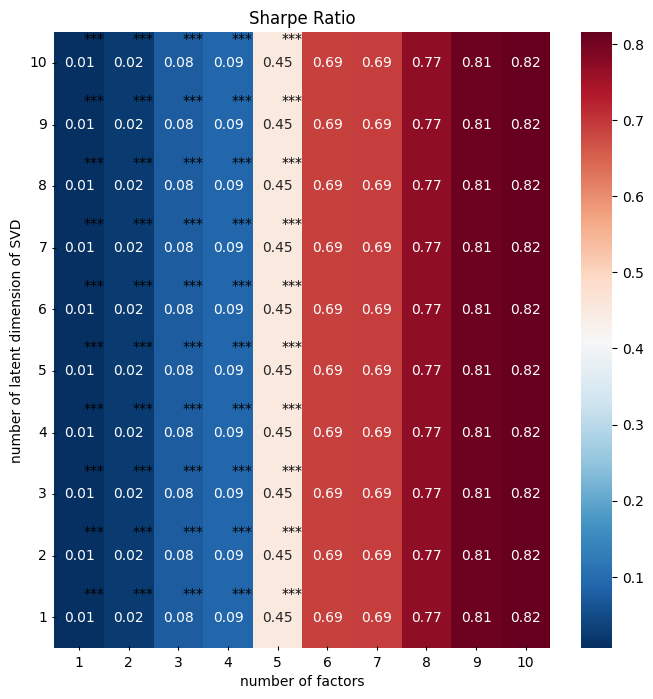

In [190]:
heatmap_sr, heatmap_py, heatmap_bkrs ,heatmap_grs  = make_heatmap(Result3,'SR')

In [93]:
np.array(dff100.columns)[np.array(Result3[4][0][7])]

array(['HMLM', 'REG', 'STR', 'CLA', 'MKTRF', 'IVOL', 'PEAD'], dtype=object)

In [182]:
Result3_all =[]
Klist = [1,2,3,4,5,6,7,8,9,10]
Result3_all= Parallel(n_jobs=10)(delayed(adj)('AdjDGL',Z,Z.shape[0],[[False]],j, -1 ,0.05,5,3000) for j in Klist)

In [192]:
np.array(dff100.columns)[np.array(Result3_all[0][0][6])]


array(['HMLM', 'QMJ', 'BETA', 'MKTRF', 'STR', 'REG'], dtype=object)

In [94]:
Result3_all=[({10: [94, 90, 99, 93, 31, 98, 91, 2, 7, 85], 9: [90, 94, 99, 93, 31, 98, 91, 2, 85], 8: [90, 94, 99, 93, 31, 98, 91, 2], 7: [90, 94, 99, 93, 31, 98, 91], 6: [90, 94, 99, 93, 31, 98], 5: [90, 94, 99, 93, 31], 4: [90, 94, 99, 93], 3: [90, 94, 99], 2: [90, 94], 1: [90]}, {10: 0.40883964439361115, 9: 0.38697260544235407, 8: 0.3834202156292175, 7: 0.37265639441247395, 6: 0.21295286167946875, 5: 0.16632297958118752, 4: 0.16466710914421434, 3: 0.14035699088852174, 2: 0.1397834629630116, 1: 0.13974866197493607}, {10: [0.0, 13.21095571350133], 9: [0.0, 17.83732652614414], 8: [0.0, 14.032320123026143], 7: [0.0, 15.378916894577047], 6: [0.0, 32.99348188987635], 5: [0.0, 32.55172091301546], 4: [0.0, 26.086921603766847], 3: [0.0, 28.711394946825852], 2: [0.0, 19.12256916237501], 1: [0.0, 17.467363245234186]}, {10: [0.1168137543092278, 1.5682887753051022], 9: [0.05882363264771118, 1.8895091891458171], 8: [0.0018649141283113568, 3.110942241065874], 7: [0.0016067517581770385, 3.1546782825121493], 6: [5.3053372806033394e-09, 5.83730046382767], 5: [4.798184072285494e-11, 6.57706699477084], 4: [1.5608625503205076e-11, 6.742124823135647], 3: [2.942979193676365e-12, 6.980423684304989], 2: [4.142242104876459e-12, 6.932241822079122], 1: [4.519939977853937e-12, 6.919889166170857]}, {10: [5.048184092970587e-13, 2.798382221624545, 0.0], 9: [5.695444116327053e-14, 2.897891780845565, 0.0], 8: [5.6066262743570405e-14, 2.8877089760798555, 0.0], 7: [2.298161660974074e-14, 2.9212182467758825, 0.0], 6: [1.1102230246251565e-16, 3.9710183140697524, 0.0], 5: [1.1102230246251565e-16, 4.296731595117294, 0.0], 4: [1.1102230246251565e-16, 4.265424206656547, 0.0], 3: [1.1102230246251565e-16, 4.421330147202857, 0.0], 2: [1.1102230246251565e-16, 4.380983899133539, 0.0], 1: [1.1102230246251565e-16, 4.337018165594372, 0.0]}, 1), ({10: [90, 78, 79, 97, 2, 98, 76, 74, 28, 25], 9: [90, 78, 79, 97, 2, 98, 76, 74, 28], 8: [90, 78, 97, 79, 2, 98, 76, 74], 7: [90, 78, 97, 79, 2, 98, 76], 6: [90, 97, 78, 79, 2, 98], 5: [90, 97, 78, 79, 98], 4: [90, 97, 78, 79], 3: [90, 97, 78], 2: [90, 78], 1: [90]}, {10: 0.362529074836177, 9: 0.3600618653517135, 8: 0.35408662047960543, 7: 0.3289545625893545, 6: 0.3229680034156204, 5: 0.31293775612458735, 4: 0.2723017666601777, 3: 0.2298096786225967, 2: 0.22666241094401263, 1: 0.13974866197493607}, {10: [0.0, 9.033474310614157], 9: [0.0, 8.875615944774882], 8: [0.0, 9.450913637626513], 7: [0.0, 14.94375345832611], 6: [0.0, 16.21417540122384], 5: [0.0, 18.15255357755004], 4: [0.0, 12.571781581460636], 3: [0.0, 19.94013850874714], 2: [0.0, 16.970480413204733], 1: [0.0, 17.467363245234186]}, {10: [0.0001257554271245631, 3.8346261332563043], 9: [0.00013108956155361007, 3.824402589096337], 8: [0.00010508872381698176, 3.878531955946998], 7: [4.095827751537939e-05, 4.10200649383381], 6: [4.292064747146718e-05, 4.091167774973396], 5: [2.660166611501147e-05, 4.200763244855044], 4: [7.102119585766786e-07, 4.9585501788021995], 3: [8.684232466471542e-08, 5.352301957599022], 2: [9.157386848812621e-09, 5.7456401549105856], 1: [4.519939977853937e-12, 6.919889166170857]}, {10: [1.7763568394002505e-15, 3.082321569161102, 0.0], 9: [2.1094237467877974e-15, 3.0639471843297033, 0.0], 8: [1.4432899320127035e-15, 3.067999213861978, 0.0], 7: [1.1102230246251565e-16, 3.194078345847456, 0.0], 6: [1.1102230246251565e-16, 3.198468211460347, 0.0], 5: [1.1102230246251565e-16, 3.229185890992114, 0.0], 4: [1.1102230246251565e-16, 3.4639597467879994, 0.0], 3: [1.1102230246251565e-16, 3.724802701986652, 0.0], 2: [1.1102230246251565e-16, 3.709344168750859, 0.0], 1: [1.1102230246251565e-16, 4.337018165594372, 0.0]}, 2), ({10: [84, 90, 78, 81, 97, 79, 88, 62, 91, 85], 9: [84, 90, 78, 81, 97, 79, 88, 62, 85], 8: [84, 90, 78, 97, 81, 88, 62, 79], 7: [84, 90, 78, 97, 81, 88, 62], 6: [84, 90, 78, 97, 81, 88], 5: [84, 90, 78, 97, 81], 4: [84, 90, 78, 97], 3: [84, 90, 78], 2: [84, 78], 1: [84]}, {10: 0.4727161976691317, 9: 0.4163428801358697, 8: 0.3540601679228778, 7: 0.3162442024289219, 6: 0.302353844996977, 5: 0.28472564212698387, 4: 0.2844809742561388, 3: 0.2762869981668921, 2: 0.02477835240300399, 1: 0.008241569029185306}, {10: [0.0, 12.237012829758873], 9: [0.0, 13.481136901857516], 8: [0.0, 13.743708446799122], 7: [0.0, 16.767135690890278], 6: [0.0, 19.423688647043157], 5: [0.0, 15.153120435782204], 4: [0.0, 13.543101009975446], 3: [0.0, 11.49637239724625], 2: [0.0, 45.52025181165322], 1: [0.0, 28.91510306512162]}, {10: [0.2803038569772356, 1.0796370029786229], 9: [0.8327916452042052, 0.21112254901979674], 8: [0.11280242085510706, 1.5857218477688533], 7: [0.050075478176420996, 1.9593186738225745], 6: [0.02414245406776061, 2.254854643528036], 5: [0.00021279437181509486, 3.7033221596336383], 4: [0.0002656433986640838, 3.646686785094887], 3: [6.541235258383793e-05, 3.992383931521696], 2: [1.3322676295501878e-15, 8.00221115551701], 1: [0.0, 8.330383593565047]}, {10: [5.614705367307238e-10, 2.4360444186391543, 0.0], 9: [1.7883472480662022e-12, 2.723861172317689, 0.0], 8: [1.4432899320127035e-15, 3.068165321930027, 0.0], 7: [1.1102230246251565e-16, 3.2768389427299303, 0.0], 6: [1.1102230246251565e-16, 3.3332883372695554, 0.0], 5: [1.1102230246251565e-16, 3.4156747125222666, 0.0], 4: [1.1102230246251565e-16, 3.3817306909493388, 0.0], 3: [1.1102230246251565e-16, 3.40144858328417, 0.0], 2: [1.1102230246251565e-16, 5.445210425081735, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 3), ({10: [84, 6, 62, 90, 78, 88, 10, 91, 97, 81], 9: [84, 62, 6, 78, 90, 88, 91, 10, 97], 8: [84, 62, 78, 6, 90, 88, 91, 10], 7: [84, 78, 90, 62, 6, 88, 91], 6: [84, 78, 90, 6, 62, 88], 5: [84, 90, 78, 62, 6], 4: [84, 90, 78, 6], 3: [84, 90, 78], 2: [84, 90], 1: [84]}, {10: 0.3734754902135081, 9: 0.3706933824781155, 8: 0.33932080068323706, 7: 0.3334105852484366, 6: 0.30130027991175684, 5: 0.2798263469222392, 4: 0.2789116088373642, 3: 0.2762869981668921, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 18.62252700590697], 9: [0.0, 17.625178198215412], 8: [0.0, 20.365856278657592], 7: [0.0, 21.0102935674978], 6: [0.0, 17.753769935423666], 5: [0.0, 14.381358383750689], 4: [0.0, 11.614105023180924], 3: [0.0, 11.49637239724625], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.5116974908107288, 0.6561968260385996], 9: [0.5347334312356766, 0.6207966446208188], 8: [0.1409548362141375, 1.4722446049902271], 7: [0.10385125786442684, 1.6264627194421475], 6: [0.015142714525227197, 2.4289477480650357], 5: [6.479808206294457e-05, 3.9946200514232224], 4: [6.229606504604135e-05, 4.0039404014110245], 3: [6.541235258383793e-05, 3.992383931521696], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [7.216449660063518e-15, 3.0134788474239964, 0.0], 9: [7.771561172376096e-15, 2.997565207591741, 0.0], 8: [2.220446049250313e-16, 3.161741164330953, 0.0], 7: [1.1102230246251565e-16, 3.165437507851414, 0.0], 6: [1.1102230246251565e-16, 3.340293565773754, 0.0], 5: [1.1102230246251565e-16, 3.4488980971461087, 0.0], 4: [1.1102230246251565e-16, 3.4191384407823304, 0.0], 3: [1.1102230246251565e-16, 3.40144858328417, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 4), ({10: [84, 90, 78, 6, 98, 88, 56, 16, 62, 91], 9: [84, 90, 78, 6, 88, 98, 56, 91, 16], 8: [84, 90, 78, 6, 88, 98, 56, 91], 7: [84, 90, 78, 6, 88, 98, 91], 6: [84, 90, 78, 6, 98, 88], 5: [84, 90, 78, 6, 98], 4: [84, 90, 78, 6], 3: [84, 90, 78], 2: [84, 90], 1: [84]}, {10: 0.49438787577696924, 9: 0.47627316634755035, 8: 0.47569603109891434, 7: 0.4667422469819218, 6: 0.4383035300721163, 5: 0.38668745704989904, 4: 0.2789116088373642, 3: 0.2762869981668921, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 9.630206871696812], 9: [0.0, 10.714483373741551], 8: [0.0, 10.123787145056495], 7: [0.0, 9.545811174802013], 6: [2.773337115513641e-13, 7.305015581871786], 5: [1.602801136257881e-08, 5.6501797875023145], 4: [0.0, 11.614105023180924], 3: [0.0, 11.49637239724625], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.34558626750296684, 0.9431850331366419], 9: [0.5514841039774878, 0.5955377038983434], 8: [0.5943483686866242, 0.5325453102527458], 7: [0.7056849600671298, 0.3776576124801293], 6: [0.7426699129208827, 0.3283197497671675], 5: [0.025288637452043794, 2.23696485015936], 4: [6.229606504604135e-05, 4.0039404014110245], 3: [6.541235258383793e-05, 3.992383931521696], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [4.977071754730389e-09, 2.320149887497227, 0.0], 9: [1.1514510456223093e-09, 2.3902311384169734, 0.0], 8: [1.539269378625363e-09, 2.367300516925179, 0.0], 7: [8.784040161913254e-10, 2.3889616570882364, 0.0], 6: [6.374889505167403e-11, 2.515452534281895, 0.0], 5: [2.781108676686017e-13, 2.7775283735260867, 0.0], 4: [1.1102230246251565e-16, 3.4191384407823304, 0.0], 3: [1.1102230246251565e-16, 3.40144858328417, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 5), ({10: [84, 85, 90, 91, 98, 88, 25, 79, 6, 31], 9: [84, 85, 90, 91, 25, 98, 88, 6, 79], 8: [84, 85, 90, 91, 25, 98, 88, 6], 7: [84, 90, 85, 91, 25, 98, 88], 6: [84, 90, 85, 91, 98, 88], 5: [84, 90, 85, 91, 98], 4: [84, 90, 85, 91], 3: [84, 90, 85], 2: [84, 90], 1: [84]}, {10: 0.5552292308026451, 9: 0.5458550485988515, 8: 0.5316011462588269, 7: 0.53130094622154, 6: 0.47204812510719624, 5: 0.4102286284281688, 4: 0.29997862044605056, 3: 0.17083748118559097, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [1.5972045908085875e-10, 6.395788887290118], 9: [4.3995884713154965e-09, 5.868423295980127], 8: [1.0300649222472202e-12, 7.126439527345137], 7: [9.33186861118429e-12, 6.816449184552561], 6: [0.0, 12.864349441620194], 5: [0.0, 12.912530115017239], 4: [0.0, 19.718007018796726], 3: [0.0, 23.88734678602414], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.003158371366922541, 2.9518883230174042], 9: [0.02248546269959073, 2.2820656825565484], 8: [0.0353513752576573, 2.1043104481093833], 7: [0.03282334283441113, 2.134237520010251], 6: [0.22747849342701976, 1.2068796561870148], 5: [0.3565388719189966, 0.9219802608391721], 4: [0.005239895954594065, 2.7919036300683198], 3: [1.2447774522250654e-07, 5.286795379587974], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [1.3095522013450989e-06, 2.0120483025680826, 0.0], 9: [7.893709336181942e-07, 2.0353241136789118, 0.0], 8: [3.0699446385007434e-07, 2.082515958823704, 0.0], 7: [4.0386924027302484e-07, 2.061581177627236, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053336, 0.0], 5: [4.19964063524958e-12, 2.643303915431614, 0.0], 4: [1.1102230246251565e-16, 3.2793245660306507, 0.0], 3: [1.1102230246251565e-16, 4.172038298668295, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 6), ({10: [84, 85, 90, 91, 88, 98, 93, 31, 62, 82], 9: [84, 85, 90, 91, 88, 98, 93, 31, 62], 8: [84, 85, 90, 91, 88, 98, 93, 31], 7: [84, 90, 85, 91, 88, 98, 93], 6: [84, 90, 85, 91, 88, 98], 5: [84, 90, 85, 91, 88], 4: [84, 90, 85, 91], 3: [84, 90, 85], 2: [84, 90], 1: [84]}, {10: 0.5176191269264067, 9: 0.5175809129582046, 8: 0.48679661361970666, 7: 0.48447550549628093, 6: 0.4720481251071963, 5: 0.32379494204523546, 4: 0.29997862044605056, 3: 0.17083748118559097, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 14.284409670204294], 9: [0.0, 13.864915831286055], 8: [0.0, 17.662927253784993], 7: [0.0, 15.554908071161359], 6: [0.0, 12.86434944162017], 5: [0.0, 23.43942213123562], 4: [0.0, 19.718007018796726], 3: [0.0, 23.88734678602414], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.011509259006619477, 2.5268440695187335], 9: [0.010268471698106962, 2.566655013473526], 8: [0.04582928042897949, 1.9969622826572166], 7: [0.1656238975073996, 1.3864029456148343], 6: [0.2274784934270171, 1.2068796561870212], 5: [0.22611251794657816, 1.2104336976723915], 4: [0.005239895954594065, 2.7919036300683198], 3: [1.2447774522250654e-07, 5.286795379587974], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [4.607086001584548e-08, 2.199590988442559, 0.0], 9: [6.328962876001043e-08, 2.1756127940878947, 0.0], 8: [4.65394778270678e-09, 2.309049329925786, 0.0], 7: [5.187559493080585e-09, 2.2961988100922808, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053287, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934467, 0.0], 4: [1.1102230246251565e-16, 3.2793245660306507, 0.0], 3: [1.1102230246251565e-16, 4.172038298668295, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 7), ({10: [84, 85, 90, 91, 88, 98, 62, 93, 31, 79], 9: [84, 85, 90, 91, 88, 98, 62, 93, 31], 8: [84, 85, 90, 91, 88, 98, 62, 93], 7: [84, 85, 90, 91, 88, 98, 62], 6: [84, 85, 90, 91, 88, 98], 5: [84, 85, 90, 91, 88], 4: [84, 85, 90, 88], 3: [84, 85, 90], 2: [84, 90], 1: [84]}, {10: 0.5776910466737121, 9: 0.5175809129582045, 8: 0.5144709750311934, 7: 0.48546057711662216, 6: 0.4720481251071961, 5: 0.3237949420452354, 4: 0.21930063891472718, 3: 0.17083748118559092, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [1.1365619556613638e-10, 6.447571980691836], 9: [0.0, 13.864915831286137], 8: [0.0, 11.518561786058337], 7: [0.0, 15.121175298823747], 6: [0.0, 12.86434944162016], 5: [0.0, 23.439422131235613], 4: [0.0, 25.975756511262404], 3: [0.0, 23.887346786024146], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.0007465388966074737, 3.37189136134445], 9: [0.010268471698106962, 2.5666550134735235], 8: [0.05275962138452761, 1.9368832092470734], 7: [0.1500072047433667, 1.4395060229150543], 6: [0.22747849342701887, 1.2068796561870165], 5: [0.22611251794657772, 1.2104336976723926], 4: [0.00045772294082913056, 3.504350236155965], 3: [1.2447774522250654e-07, 5.286795379587973], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [8.27899211497396e-06, 1.9043072306993425, 0.0], 9: [6.328962876001043e-08, 2.1756127940878947, 0.0], 8: [6.524237550209477e-08, 2.167544073428666, 0.0], 7: [5.713874151602738e-09, 2.2911108229863015, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053314, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934396, 0.0], 4: [1.1102230246251565e-16, 3.840931019266475, 0.0], 3: [1.1102230246251565e-16, 4.1720382986683004, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 8), ({10: [84, 85, 90, 91, 88, 62, 98, 93, 31, 6], 9: [84, 85, 90, 91, 88, 98, 62, 93, 31], 8: [84, 85, 90, 88, 91, 98, 62, 93], 7: [84, 85, 90, 88, 91, 98, 62], 6: [84, 85, 90, 88, 91, 98], 5: [84, 90, 85, 88, 91], 4: [84, 90, 85, 88], 3: [84, 90, 85], 2: [84, 90], 1: [84]}, {10: 0.5246790140871593, 9: 0.5175809129582045, 8: 0.5144709750311935, 7: 0.4854605771166222, 6: 0.47204812510719624, 5: 0.3237949420452354, 4: 0.2193006389147272, 3: 0.17083748118559097, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 12.847050902611016], 9: [0.0, 13.864915831286137], 8: [0.0, 11.51856178605838], 7: [0.0, 15.121175298823752], 6: [0.0, 12.86434944162016], 5: [0.0, 23.4394221312356], 4: [0.0, 25.975756511262382], 3: [0.0, 23.88734678602414], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.00799105140132328, 2.652447668928251], 9: [0.010268471698106962, 2.5666550134735235], 8: [0.05275962138452761, 1.9368832092470725], 7: [0.15000720474336826, 1.439506022915049], 6: [0.22747849342701798, 1.206879656187019], 5: [0.22611251794657772, 1.2104336976723926], 4: [0.00045772294082913056, 3.504350236155965], 3: [1.2447774522250654e-07, 5.286795379587974], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [8.848300669939135e-08, 2.1636814894530247, 0.0], 9: [6.328962876001043e-08, 2.1756127940878947, 0.0], 8: [6.524237550209477e-08, 2.1675440734286733, 0.0], 7: [5.713874151602738e-09, 2.291110822986303, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053314, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934445, 0.0], 4: [1.1102230246251565e-16, 3.84093101926647, 0.0], 3: [1.1102230246251565e-16, 4.172038298668295, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 9), ({10: [84, 85, 90, 88, 91, 98, 62, 31, 79, 21], 9: [84, 85, 90, 88, 91, 98, 62, 31, 79], 8: [84, 85, 90, 88, 91, 98, 62, 31], 7: [84, 85, 90, 88, 91, 98, 62], 6: [84, 85, 90, 88, 91, 98], 5: [84, 85, 90, 88, 91], 4: [84, 85, 90, 88], 3: [84, 90, 85], 2: [84, 90], 1: [84]}, {10: 0.5544568668972063, 9: 0.5544258084708533, 8: 0.48647886982349947, 7: 0.4854605771166222, 6: 0.47204812510719624, 5: 0.3237949420452354, 4: 0.21930063891472718, 3: 0.17083748118559097, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 8.455032494479108], 9: [3.552713678800501e-15, 7.868188490047492], 8: [0.0, 17.852577412236812], 7: [0.0, 15.121175298823752], 6: [0.0, 12.86434944162016], 5: [0.0, 23.439422131235624], 4: [0.0, 25.975756511262404], 3: [0.0, 23.88734678602414], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.0023016062060172704, 3.048273141648414], 9: [0.003633027415530732, 2.90838330203866], 8: [0.04737540425752562, 1.982928611170925], 7: [0.15000720474336826, 1.439506022915049], 6: [0.22747849342701798, 1.206879656187019], 5: [0.22611251794657927, 1.210433697672389], 4: [0.00045772294082913056, 3.504350236155965], 3: [1.2447774522250654e-07, 5.286795379587974], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [1.226526153641494e-06, 2.0158084223855934, 0.0], 9: [1.6362401495939594e-06, 1.9938062997715875, 0.0], 8: [4.510553597292244e-09, 2.310704620564168, 0.0], 7: [5.713874151602738e-09, 2.291110822986303, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053314, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934502, 0.0], 4: [1.1102230246251565e-16, 3.840931019266475, 0.0], 3: [1.1102230246251565e-16, 4.172038298668295, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 10)]

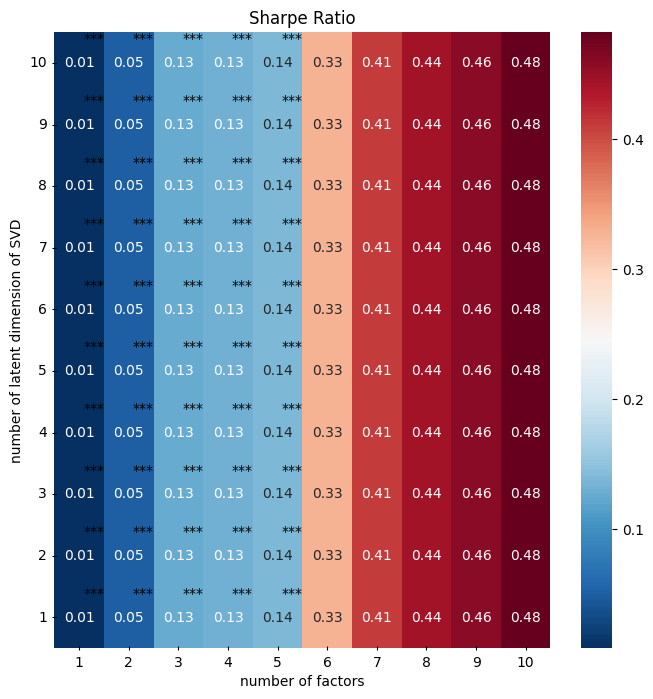

In [183]:
heatmap_sr, heatmap_py, heatmap_bkrs ,heatmap_grs  = make_heatmap(Result3_all,'SR')

In [119]:
np.array(dff100.columns)[np.array(Result3[5][0][5])]

array(['HMLM', 'REG', 'QMJ', 'STR', 'PEAD'], dtype=object)

In [180]:
Result2 =[]
Klist = [1,2,3,4,5,6,7,8,9,10]
Result2= Parallel(n_jobs=10)(delayed(adj)('AdjDGL',Z,36*12,[[False]],j, -2 ,0.09,5,3000) for j in Klist)

In [185]:
np.array(dff100.columns)[np.array(Result2[0][0][7])]

array(['MKTRF', 'HMLM', 'IVOL', 'STR', 'PEAD', 'ROA1', 'REG'],
      dtype=object)

In [54]:
Result2=[({10: [90, 94, 98, 78, 2, 31, 91, 24, 83, 79], 9: [90, 94, 98, 78, 2, 31, 91, 24, 83], 8: [90, 94, 98, 78, 2, 31, 91, 24], 7: [90, 94, 98, 78, 2, 91, 31], 6: [90, 94, 98, 78, 2, 91], 5: [90, 94, 98, 78, 91], 4: [90, 94, 98, 78], 3: [90, 98, 94], 2: [90, 98], 1: [90]}, {10: 0.6641856948231298, 9: 0.5383461137281327, 8: 0.5333047208665449, 7: 0.5332039726857263, 6: 0.5327103262833311, 5: 0.5243973607000476, 4: 0.46507774252752115, 3: 0.37127615810607, 2: 0.3700381552688632, 1: 0.2598611521922185}, {10: [3.108624468950438e-14, 7.593951162343253], 9: [0.0, 19.611200858718842], 8: [0.0, 18.442247049343205], 7: [0.0, 17.901607376923227], 6: [0.0, 14.631332550290299], 5: [0.0, 12.84037300429689], 4: [0.0, 10.962169593148374], 3: [0.0, 14.032802568246886], 2: [0.0, 12.722179800565735], 1: [0.0, 14.029020675947285]}, {10: [0.1568731562036123, 1.4156665507204764], 9: [0.008755728547805708, 2.621447349696726], 8: [0.002737097577303782, 2.9958179843943795], 7: [0.0017468687389439186, 3.1302007598345334], 6: [0.0007102797086369073, 3.3855801228896563], 5: [0.0006564503562980217, 3.407150018010415], 4: [1.1004948524018232e-05, 4.396422781856617], 3: [1.6171208594428776e-08, 5.6486506684345175], 2: [6.535357366388439e-09, 5.802448233432046], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [1.794120407794253e-13, 3.045380096709019, 0.0], 9: [1.1102230246251565e-16, 3.556736563885584, 0.0], 8: [1.1102230246251565e-16, 3.541508684794079, 0.0], 7: [1.1102230246251565e-16, 3.5038927403505173, 0.0], 6: [1.1102230246251565e-16, 3.468871332091474, 0.0], 5: [1.1102230246251565e-16, 3.470132278508598, 0.0], 4: [1.1102230246251565e-16, 3.7130485490127807, 0.0], 3: [1.1102230246251565e-16, 4.160267868268509, 0.0], 2: [1.1102230246251565e-16, 4.1245983887091615, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 1), ({10: [90, 98, 94, 47, 78, 25, 79, 97, 76, 91], 9: [90, 98, 94, 78, 47, 79, 25, 97, 76], 8: [90, 98, 47, 78, 79, 94, 97, 25], 7: [90, 98, 79, 78, 47, 94, 97], 6: [90, 98, 79, 47, 78, 97], 5: [90, 98, 47, 78, 79], 4: [90, 98, 47, 78], 3: [90, 98, 47], 2: [90, 98], 1: [90]}, {10: 0.7024712718336601, 9: 0.5290059744291962, 8: 0.5272403280144914, 7: 0.5186507309768856, 6: 0.5178331540203402, 5: 0.517168603660435, 4: 0.47074004135825187, 3: 0.41927442917086594, 2: 0.3700381552688632, 1: 0.2598611521922185}, {10: [1.8008341987840737e-05, 4.288253599661865], 9: [0.0, 8.362424104413837], 8: [0.0, 8.463899205552497], 7: [0.0, 9.395487917198155], 6: [3.774758283725532e-15, 7.85865274691209], 5: [3.483879851273741e-13, 7.27424371976552], 4: [0.0, 12.50797141153529], 3: [0.0, 9.50383871743813], 2: [0.0, 12.722179800565735], 1: [0.0, 14.029020675947285]}, {10: [0.04514407146542587, 2.0033095649866217], 9: [4.353240339671771e-05, 4.0878848986977685], 8: [5.793776585227839e-05, 4.021056253690833], 7: [4.060639463587812e-05, 4.104002001499299], 6: [1.235815672218088e-05, 4.371171688506248], 5: [1.2498143446837418e-05, 4.368712036770308], 4: [3.151292496283986e-06, 4.660704259560582], 3: [2.1824007045978533e-08, 5.596882847833172], 2: [6.535357366388439e-09, 5.802448233432046], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [2.311262292664651e-12, 2.8939382614643905, 0.0], 9: [1.1102230246251565e-16, 3.600749817390714, 0.0], 8: [1.1102230246251565e-16, 3.5699008423847522, 0.0], 7: [1.1102230246251565e-16, 3.5716808788001035, 0.0], 6: [1.1102230246251565e-16, 3.5374901406741994, 0.0], 5: [1.1102230246251565e-16, 3.5033173487533564, 0.0], 4: [1.1102230246251565e-16, 3.6854389741693354, 0.0], 3: [1.1102230246251565e-16, 3.903821053217326, 0.0], 2: [1.1102230246251565e-16, 4.1245983887091615, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 2), ({10: [84, 90, 88, 85, 79, 94, 98, 78, 91, 97], 9: [84, 90, 88, 78, 85, 94, 79, 91, 98], 8: [84, 90, 88, 78, 91, 85, 94, 79], 7: [84, 90, 88, 78, 91, 94, 85], 6: [84, 90, 88, 78, 91, 94], 5: [84, 90, 88, 78, 91], 4: [84, 90, 88, 78], 3: [84, 90, 88], 2: [90, 84], 1: [90]}, {10: 0.8870697527358903, 9: 0.8340447398443591, 8: 0.5979277305677652, 7: 0.469691129947328, 6: 0.46878369684309623, 5: 0.46777696696687776, 4: 0.4396662584748422, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [7.75993713730827e-10, 6.149761841765345], 9: [0.0, 8.526401632056137], 8: [0.0, 16.673057443748927], 7: [0.0, 26.31762026453551], 6: [0.0, 23.523216695602674], 5: [0.0, 21.721325989776943], 4: [0.0, 11.794979331941741], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.0017915626110278637, 3.1227723531316354], 9: [0.00930275342605924, 2.600723003635052], 8: [0.6110282972531844, 0.5086061786127696], 7: [0.07819064743439896, 1.7612822225541303], 6: [0.021432508471835643, 2.300277413134047], 5: [0.011533973922489116, 2.526090578771689], 4: [0.0012668834917883842, 3.2233777800892747], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.756716519190489], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [1.0169234987422726e-07, 2.2499875594644325, 0.0], 9: [8.52046277977081e-09, 2.395077505565334, 0.0], 8: [3.6637359812630166e-15, 3.252341837386399, 0.0], 7: [1.1102230246251565e-16, 3.809587044870377, 0.0], 6: [1.1102230246251565e-16, 3.7735701572507345, 0.0], 5: [1.1102230246251565e-16, 3.7388063623675856, 0.0], 4: [1.1102230246251565e-16, 3.83963028645792, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961962, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 3), ({10: [84, 90, 6, 88, 91, 62, 85, 98, 78, 97], 9: [84, 90, 6, 88, 91, 62, 98, 85, 78], 7: [84, 90, 88, 6, 91, 78, 98], 6: [84, 90, 88, 91, 6, 78], 5: [84, 90, 88, 91, 6], 4: [84, 90, 88, 91], 3: [84, 90, 88], 2: [84, 90], 1: [84]}, {10: 0.8385896954046211, 9: 0.7679568437939578, 7: 0.730341230470932, 6: 0.49374022967621306, 5: 0.4900051990716954, 4: 0.4675618612751591, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.01117340050373691}, {10: [2.220446049250313e-16, 8.183859455817199], 9: [0.0, 12.249832669651031], 7: [0.0, 9.871909422614914], 6: [0.0, 18.740490736028992], 5: [0.0, 12.379821948259622], 4: [0.0, 15.81454551864227], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 27.419532705390413]}, {10: [0.01580972674348735, 2.413278668955387], 9: [0.10193443067924446, 1.6355469988394618], 7: [0.5298207109001525, 0.6282797254013759], 6: [0.018632157534013816, 2.35280988508236], 5: [0.01843016840519418, 2.3568605103193594], 4: [0.013782117837952468, 2.462892637263262], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.75671651919049], 1: [0.0, 9.037211435712337]}, {10: [7.937352441977907e-09, 2.4065842549746255, 0.0], 9: [1.9673507267725654e-10, 2.620986593286585, 0.0], 7: [3.99938970829794e-11, 2.697978511071445, 0.0], 6: [1.1102230246251565e-16, 3.6515144116052305, 0.0], 5: [1.1102230246251565e-16, 3.630894740723978, 0.0], 4: [1.1102230246251565e-16, 3.70090966434257, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 4), ({10: [84, 90, 6, 88, 98, 91, 78, 62, 85, 54], 9: [84, 90, 6, 88, 98, 91, 78, 62, 85], 8: [84, 90, 6, 88, 98, 78, 91, 62], 7: [84, 90, 88, 91, 6, 98, 78], 6: [84, 90, 88, 91, 98, 6], 5: [84, 90, 88, 91, 98], 4: [84, 90, 88, 91], 3: [84, 90, 88], 2: [84, 90], 1: [84]}, {10: 0.7781401928142776, 9: 0.7679568437939579, 8: 0.7610745736163578, 7: 0.7303412304709326, 6: 0.7256549605904997, 5: 0.7203394983303434, 4: 0.4675618612751591, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.01117340050373691}, {10: [0.0, 11.69293544016578], 9: [0.0, 12.249832669651079], 8: [0.0, 8.768507838934916], 7: [0.0, 9.871909422614847], 6: [4.330371659033716e-07, 5.053829964628471], 5: [9.848466064887873e-08, 5.329497897183172], 4: [0.0, 15.81454551864227], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 27.419532705390413]}, {10: [0.10158457339897664, 1.6372196943564754], 9: [0.10193443067924512, 1.635546998839459], 8: [0.3437452356745003, 0.946791104181226], 7: [0.5298207109001518, 0.6282797254013767], 6: [0.49553552029269143, 0.6815310599971253], 5: [0.4742028300160799, 0.715657547687748], 4: [0.013782117837952468, 2.462892637263262], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.75671651919049], 1: [0.0, 9.037211435712337]}, {10: [2.556131972752951e-10, 2.613805440957825, 0.0], 9: [1.9673507267725654e-10, 2.6209865932865926, 0.0], 8: [1.8365464704572787e-10, 2.6167318392469023, 0.0], 7: [3.99938970829794e-11, 2.697978511071444, 0.0], 6: [4.235312101030786e-11, 2.686116859714351, 0.0], 5: [4.303102318914398e-11, 2.676852030550094, 0.0], 4: [1.1102230246251565e-16, 3.70090966434257, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 5), ({10: [84, 85, 90, 6, 88, 98, 91, 20, 31, 79], 9: [84, 85, 90, 88, 6, 98, 91, 20, 31], 8: [84, 90, 85, 88, 6, 98, 91, 20], 7: [84, 90, 85, 88, 98, 6, 91], 6: [84, 90, 85, 88, 98, 6], 5: [84, 90, 85, 88, 98], 4: [84, 90, 85, 88], 3: [90, 84, 88], 2: [90, 84], 1: [90]}, {10: 0.8427791594616488, 9: 0.747896800447534, 8: 0.7387690386846758, 7: 0.7382122819206057, 6: 0.6182930246129456, 5: 0.6091126476055546, 4: 0.3688984399837695, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [1.0937695194002117e-11, 6.7935902360786], 9: [0.0, 13.524445512640986], 8: [0.0, 11.857813596445995], 7: [0.0, 10.610488074141742], 6: [0.0, 10.989565118706503], 5: [0.0, 11.30831181747914], 4: [0.0, 19.99602042568463], 3: [0.0, 19.67842751259804], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.004604048142818673, 2.833505737784893], 9: [0.04497045373268893, 2.004930722588002], 8: [0.1587895832611146, 1.4091541793285929], 7: [0.1558043256059325, 1.4193248669081406], 6: [0.11438096001906017, 1.5788042650936835], 5: [0.1138290905002588, 1.5812141087350255], 4: [2.9412104900483627e-06, 4.6748831410784515], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.756716519190489], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [9.965762326480387e-09, 2.3927265089090515, 0.0], 9: [5.855815832234157e-11, 2.6929377501560574, 0.0], 8: [4.745492887536784e-11, 2.696593791746113, 0.0], 7: [6.492117954337573e-11, 2.6695960542739594, 0.0], 6: [3.441691376337985e-14, 3.098637903094135, 0.0], 5: [2.631228568361621e-14, 3.103451371059328, 0.0], 4: [1.1102230246251565e-16, 4.216912449776015, 0.0], 3: [1.1102230246251565e-16, 4.20482828135539, 0.0], 2: [1.1102230246251565e-16, 4.727609823961962, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 6), ({10: [84, 85, 90, 6, 88, 98, 91, 31, 20, 79], 9: [84, 90, 85, 88, 6, 98, 91, 31, 20], 8: [84, 90, 85, 88, 6, 98, 91, 31], 7: [84, 90, 85, 88, 98, 6, 91], 6: [84, 90, 85, 88, 98, 91], 5: [84, 90, 85, 88, 98], 4: [84, 90, 88, 85], 3: [84, 90, 88], 2: [90, 84], 1: [90]}, {10: 0.8427791594616489, 9: 0.7478968004475341, 8: 0.7477011769022683, 7: 0.7382122819206057, 6: 0.7247875048160591, 5: 0.6091126476055546, 4: 0.3688984399837695, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [1.0937695194002117e-11, 6.79359023607863], 9: [0.0, 13.524445512640966], 8: [0.0, 12.130000643628975], 7: [0.0, 10.610488074141742], 6: [0.0, 11.162099074917124], 5: [0.0, 11.30831181747914], 4: [0.0, 19.99602042568461], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.004604048142818451, 2.833505737784899], 9: [0.04497045373268893, 2.0049307225880026], 8: [0.04648540446929195, 1.9909589131582595], 7: [0.1558043256059325, 1.4193248669081406], 6: [0.16646367433019127, 1.3836564505231366], 5: [0.1138290905002588, 1.5812141087350255], 4: [2.9412104900483627e-06, 4.674883141078455], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.756716519190489], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [9.965762326480387e-09, 2.3927265089090413, 0.0], 9: [5.855815832234157e-11, 2.692937750156067, 0.0], 8: [8.197831302680925e-11, 2.664368765203065, 0.0], 7: [6.492117954337573e-11, 2.6695960542739594, 0.0], 6: [4.013867016539052e-11, 2.689244124687579, 0.0], 5: [2.631228568361621e-14, 3.103451371059328, 0.0], 4: [1.1102230246251565e-16, 4.216912449776026, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961962, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 7), ({10: [84, 85, 90, 88, 98, 91, 11, 31, 79, 6], 9: [84, 85, 90, 88, 98, 91, 31, 11, 79], 8: [84, 85, 90, 88, 98, 91, 31, 11], 7: [84, 85, 90, 88, 98, 91, 31], 6: [84, 90, 85, 88, 98, 91], 5: [84, 90, 85, 88, 98], 4: [84, 90, 85, 88], 3: [84, 90, 88], 2: [90, 84], 1: [90]}, {10: 0.8452430468406902, 9: 0.8451473608448637, 8: 0.7286036723000329, 7: 0.7283719352091965, 6: 0.7247875048160591, 5: 0.6091126476055546, 4: 0.3688984399837695, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [1.4948042803553108e-12, 7.074973231034786], 9: [2.5880853016246874e-11, 6.66828546422393], 8: [0.0, 15.139052494409855], 7: [0.0, 13.149672533409252], 6: [0.0, 11.162099074917124], 5: [0.0, 11.30831181747914], 4: [0.0, 19.99602042568463], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.005981817451713001, 2.7487764143498548], 9: [0.00503870006581475, 2.8045491762477277], 8: [0.06748465209132837, 1.828432602599553], 7: [0.05659416549272911, 1.9064321141384155], 6: [0.16646367433019127, 1.3836564505231366], 5: [0.1138290905002588, 1.5812141087350255], 4: [2.9412104900483627e-06, 4.6748831410784515], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.756716519190489], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [1.1385729470347883e-08, 2.384605944277477, 0.0], 9: [1.551891570805708e-08, 2.3587129826750877, 0.0], 8: [2.5276225557036014e-11, 2.7336731861647245, 0.0], 7: [3.540101545240759e-11, 2.7051200807642113, 0.0], 6: [4.013867016539052e-11, 2.689244124687579, 0.0], 5: [2.631228568361621e-14, 3.103451371059328, 0.0], 4: [1.1102230246251565e-16, 4.216912449776015, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961962, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 8), ({9: [84, 85, 90, 88, 98, 91, 31, 11, 62], 8: [84, 85, 90, 88, 98, 91, 31, 11], 7: [84, 85, 90, 88, 98, 91, 31], 6: [84, 90, 85, 88, 98, 91], 5: [84, 90, 85, 88, 98], 4: [84, 90, 88, 85], 3: [84, 90, 88], 2: [90, 88], 1: [90]}, {9: 0.7473502636123387, 8: 0.7286036723000329, 7: 0.7283719352091965, 6: 0.7247875048160591, 5: 0.6091126476055546, 4: 0.3688984399837695, 3: 0.3632650715881808, 2: 0.36326060932708015, 1: 0.2598611521922185}, {9: [0.0, 15.457392448915137], 8: [0.0, 15.139052494409855], 7: [0.0, 13.149672533409252], 6: [0.0, 11.162099074917124], 5: [0.0, 11.30831181747914], 4: [0.0, 19.99602042568461], 3: [0.0, 19.678427512598045], 2: [0.0, 14.327162616426513], 1: [0.0, 14.029020675947285]}, {9: [0.042833455460755454, 2.025330336531972], 8: [0.06748465209132837, 1.828432602599553], 7: [0.05659416549272911, 1.9064321141384155], 6: [0.16646367433019127, 1.3836564505231366], 5: [0.1138290905002588, 1.5812141087350255], 4: [2.9412104900483627e-06, 4.674883141078455], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [2.2372059760300544e-09, 5.979574965227249], 1: [1.7985612998927536e-13, 7.363006266097757]}, {9: [5.663103319619722e-11, 2.6949211809032407, 0.0], 8: [2.5276225557036014e-11, 2.7336731861647245, 0.0], 7: [3.540101545240759e-11, 2.7051200807642113, 0.0], 6: [4.013867016539052e-11, 2.689244124687579, 0.0], 5: [2.631228568361621e-14, 3.103451371059328, 0.0], 4: [1.1102230246251565e-16, 4.216912449776026, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.16194658212582, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 9), ({9: [84, 85, 90, 88, 91, 98, 31, 11, 62], 8: [84, 85, 90, 88, 98, 91, 31, 11], 7: [84, 85, 90, 88, 98, 91, 31], 6: [84, 90, 85, 88, 98, 91], 5: [84, 90, 85, 88, 98], 4: [84, 90, 88, 85], 3: [84, 90, 88], 2: [88, 90], 1: [88]}, {9: 0.7473502636123387, 8: 0.7286036723000329, 7: 0.7283719352091965, 6: 0.7247875048160591, 5: 0.6091126476055546, 4: 0.3688984399837695, 3: 0.3632650715881808, 2: 0.36326060932708004, 1: 0.023508461578625933}, {9: [0.0, 15.45739244891514], 8: [0.0, 15.139052494409855], 7: [0.0, 13.149672533409252], 6: [0.0, 11.162099074917124], 5: [0.0, 11.30831181747914], 4: [0.0, 19.99602042568461], 3: [0.0, 19.678427512598045], 2: [0.0, 14.327162616426508], 1: [0.0, 31.764578145053658]}, {9: [0.04283345546075523, 2.025330336531975], 8: [0.06748465209132837, 1.828432602599553], 7: [0.05659416549272911, 1.9064321141384155], 6: [0.16646367433019127, 1.3836564505231366], 5: [0.1138290905002588, 1.5812141087350255], 4: [2.9412104900483627e-06, 4.674883141078455], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [2.2372059760300544e-09, 5.979574965227245], 1: [0.0, 9.000381241054663]}, {9: [5.663103319619722e-11, 2.694921180903235, 0.0], 8: [2.5276225557036014e-11, 2.7336731861647245, 0.0], 7: [3.540101545240759e-11, 2.7051200807642113, 0.0], 6: [4.013867016539052e-11, 2.689244124687579, 0.0], 5: [2.631228568361621e-14, 3.103451371059328, 0.0], 4: [1.1102230246251565e-16, 4.216912449776026, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.161946582125812, 0.0], 1: [1.1102230246251565e-16, 6.600704962205906, 0.0]}, 10)]

In [69]:
np.array(dff100.columns)[np.array(Result2[4][0][5])]

array(['HMLM', 'REG', 'STR', 'IVOL', 'PEAD'], dtype=object)

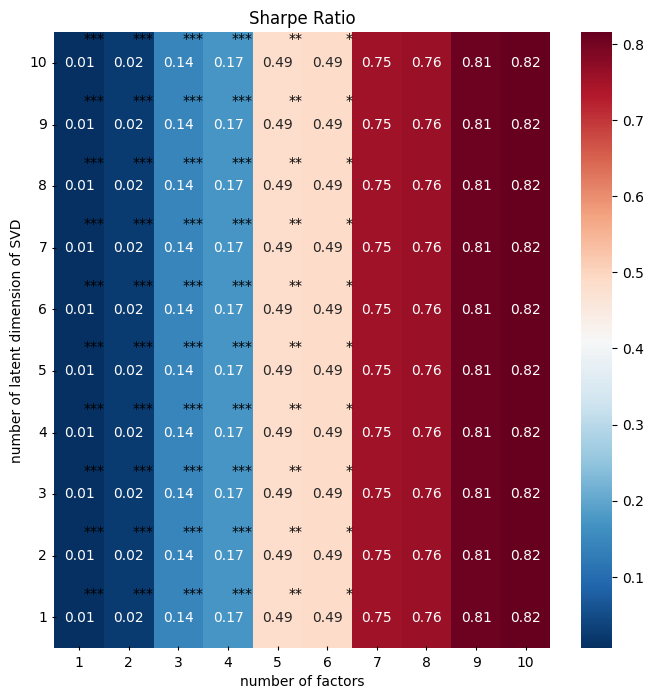

In [184]:
heatmap_sr, heatmap_py, heatmap_bkrs ,heatmap_grs  = make_heatmap(Result2,'SR')

In [181]:
Result2_all =[]
Klist = [1,2,3,4,5,6,7,8,9,10]
Result2_all= Parallel(n_jobs=10)(delayed(adj)('AdjDGL',Z,Z.shape[0],[[False]],j, -2 ,0.05,5,3000) for j in Klist)

In [187]:
np.array(dff100.columns)[np.array(Result2_all[0][0][8])]

array(['HMLM', 'QMJ', 'UMD', 'STR', 'IVOL', 'BETA', 'REG', 'MKTRF'],
      dtype=object)

In [65]:
Result2_all=[({10: [90, 94, 99, 98, 91, 31, 93, 2, 85, 7], 9: [90, 94, 99, 98, 91, 31, 2, 93, 85], 8: [90, 94, 99, 98, 91, 31, 2, 93], 7: [90, 94, 99, 98, 91, 31, 2], 6: [90, 94, 99, 98, 91, 31], 5: [90, 94, 98, 99, 91], 4: [90, 94, 98, 91], 3: [90, 94, 98], 2: [90, 94], 1: [90]}, {10: 0.40883964439361103, 9: 0.386972605442354, 8: 0.3834202156292175, 7: 0.3428481292205437, 6: 0.3413336753118141, 5: 0.34096636335283154, 4: 0.32450027034614354, 3: 0.1837875381414928, 2: 0.1397834629630116, 1: 0.13974866197493607}, {10: [0.0, 13.210955713501372], 9: [0.0, 17.837326526144203], 8: [0.0, 14.03232012302617], 7: [0.0, 21.12291069357649], 6: [0.0, 19.268590948613173], 5: [0.0, 16.38321789504675], 4: [0.0, 16.224759018067235], 3: [0.0, 20.826981948013646], 2: [0.0, 19.12256916237501], 1: [0.0, 17.467363245234186]}, {10: [0.11681375430922802, 1.5682887753051014], 9: [0.058823632647710955, 1.8895091891458191], 8: [0.0018649141283113568, 3.110942241065878], 7: [0.0003352738880426642, 3.5864005156537435], 6: [0.0004137367933982894, 3.531162941213049], 5: [0.00010217240714038844, 3.8853741593020814], 4: [6.301869666658355e-05, 4.001212629581284], 3: [6.586899914395872e-10, 6.175704708437528], 2: [4.142242104876459e-12, 6.932241822079122], 1: [4.519939977853937e-12, 6.919889166170857]}, {10: [5.048184092970587e-13, 2.798382221624545, 0.0], 9: [5.695444116327053e-14, 2.89789178084557, 0.0], 8: [5.6066262743570405e-14, 2.887708976079857, 0.0], 7: [5.551115123125783e-16, 3.105405820247917, 0.0], 6: [6.661338147750939e-16, 3.0818441642526944, 0.0], 5: [9.992007221626409e-16, 3.051680641850553, 0.0], 4: [2.220446049250313e-16, 3.1221850167683756, 0.0], 3: [1.1102230246251565e-16, 4.070009006582417, 0.0], 2: [1.1102230246251565e-16, 4.380983899133539, 0.0], 1: [1.1102230246251565e-16, 4.337018165594372, 0.0]}, 1), ({10: [90, 98, 2, 79, 78, 97, 76, 91, 25, 74], 9: [90, 98, 2, 79, 78, 97, 91, 76, 25], 8: [90, 78, 79, 98, 97, 2, 91, 76], 7: [90, 78, 79, 97, 98, 2, 91], 6: [90, 78, 97, 79, 98, 2], 5: [90, 78, 97, 79, 98], 4: [90, 78, 97, 98], 3: [90, 78, 97], 2: [90, 78], 1: [90]}, {10: 0.4544713078751305, 9: 0.4381350356658788, 8: 0.4327998925314749, 7: 0.4289648390387022, 6: 0.3229680034156202, 5: 0.3129377561245873, 4: 0.274641562723842, 3: 0.22980967862259666, 2: 0.22666241094401263, 1: 0.13974866197493607}, {10: [1.765836801848053e-05, 4.292611681074649], 9: [2.2224444506946384e-12, 7.019767251874358], 8: [1.3322676295501878e-15, 7.984800708356119], 7: [1.2678746941219288e-13, 7.40957762286199], 6: [0.0, 16.21417540122385], 5: [0.0, 18.152553577550073], 4: [0.0, 25.85384899442607], 3: [0.0, 19.94013850874714], 2: [0.0, 16.970480413204733], 1: [0.0, 17.467363245234186]}, {10: [0.02251704747459793, 2.2815309491695706], 9: [0.017088137676752435, 2.384805834875848], 8: [0.016606674562529733, 2.3953021378017936], 7: [0.017226735705457186, 2.381832401740311], 6: [4.292064747146718e-05, 4.091167774973394], 5: [2.660166611501147e-05, 4.200763244855041], 4: [4.838245433846922e-06, 4.571682111430212], 3: [8.684232466471542e-08, 5.352301957599021], 2: [9.157386848812621e-09, 5.7456401549105856], 1: [4.519939977853937e-12, 6.919889166170857]}, {10: [8.270639728635842e-11, 2.5362910581001437, 0.0], 9: [2.0519808074936918e-11, 2.5993277174164016, 0.0], 8: [1.6667889290999938e-11, 2.600884592842448, 0.0], 7: [1.592703746666757e-11, 2.5942523086473375, 0.0], 6: [1.1102230246251565e-16, 3.198468211460347, 0.0], 5: [1.1102230246251565e-16, 3.2291858909921176, 0.0], 4: [1.1102230246251565e-16, 3.4480404500969035, 0.0], 3: [1.1102230246251565e-16, 3.724802701986652, 0.0], 2: [1.1102230246251565e-16, 3.709344168750859, 0.0], 1: [1.1102230246251565e-16, 4.337018165594372, 0.0]}, 2), ({10: [84, 90, 78, 88, 91, 81, 62, 97, 79, 98], 9: [84, 90, 78, 88, 91, 81, 97, 62, 79], 8: [84, 90, 78, 88, 91, 97, 81, 62], 7: [84, 90, 78, 88, 91, 97, 81], 6: [84, 90, 78, 88, 91, 97], 5: [84, 90, 78, 88, 91], 4: [84, 90, 78, 88], 3: [84, 90, 78], 2: [84, 78], 1: [84]}, {10: 0.5428268622724366, 9: 0.4268623581485609, 8: 0.3714262201390855, 7: 0.36904655649122625, 6: 0.36329914917880074, 5: 0.32165267722365637, 4: 0.29558736895526283, 3: 0.2762869981668921, 2: 0.02477835240300399, 1: 0.008241569029185306}, {10: [1.0751384005303066e-08, 5.7184283401913225], 9: [0.0, 11.241042319132049], 8: [0.0, 17.03489536329906], 7: [0.0, 16.48633220649073], 6: [0.0, 16.56656853098102], 5: [0.0, 20.293738624172562], 4: [0.0, 15.253156844395054], 3: [0.0, 11.49637239724625], 2: [0.0, 45.52025181165322], 1: [0.0, 28.91510306512162]}, {10: [0.06128821122849715, 1.8714104524552249], 9: [0.9812257405935114, 0.023532216438516804], 8: [0.47377635581735644, 0.7163482253941993], 7: [0.3359071125400428, 0.9622837039995887], 6: [0.3339212339600621, 0.9662457321271529], 5: [0.06933323471523622, 1.816242151651936], 4: [0.01328440655243579, 2.4760524375929833], 3: [6.541235258383793e-05, 3.992383931521696], 2: [1.3322676295501878e-15, 8.00221115551701], 1: [0.0, 8.330383593565047]}, {10: [4.499323725815074e-07, 2.072882226473738, 0.0], 9: [5.880851361439454e-12, 2.6632716368532723, 0.0], 8: [1.2989609388114332e-14, 2.960494463967305, 0.0], 7: [1.4765966227514582e-14, 2.9430968710058716, 0.0], 6: [1.099120794378905e-14, 2.946487375894664, 0.0], 5: [1.1102230246251565e-16, 3.1731877401055555, 0.0], 4: [1.1102230246251565e-16, 3.3080925528889447, 0.0], 3: [1.1102230246251565e-16, 3.40144858328417, 0.0], 2: [1.1102230246251565e-16, 5.445210425081735, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 3), ({10: [84, 6, 62, 90, 78, 88, 91, 10, 98, 97], 9: [84, 6, 62, 90, 78, 88, 91, 10, 98], 8: [84, 6, 62, 90, 78, 88, 91, 10], 7: [84, 90, 78, 6, 88, 91, 62], 6: [84, 90, 78, 88, 6, 91], 5: [84, 90, 78, 88, 6], 4: [84, 90, 78, 88], 3: [84, 90, 78], 2: [84, 90], 1: [84]}, {10: 0.5023510336998969, 9: 0.479173827844739, 8: 0.33932080068323694, 7: 0.33341058524843664, 6: 0.33114878598513825, 5: 0.29861541410523035, 4: 0.29558736895526283, 3: 0.2762869981668921, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 9.967159246239941], 9: [0.0, 11.220762050457358], 8: [0.0, 20.3658562786576], 7: [0.0, 21.010293567497822], 6: [0.0, 18.241724751167855], 5: [0.0, 15.315444713638016], 4: [0.0, 15.253156844395054], 3: [0.0, 11.49637239724625], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.14374117763474947, 1.4620001176420876], 9: [0.48115870518737314, 0.7044401572744801], 8: [0.14095483621413818, 1.4722446049902245], 7: [0.10385125786442617, 1.6264627194421502], 6: [0.08121936882468717, 1.7436544139838066], 5: [0.01261930439804515, 2.4943359504002998], 4: [0.01328440655243579, 2.4760524375929833], 3: [6.541235258383793e-05, 3.992383931521696], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [1.081565226268566e-08, 2.278404992468905, 0.0], 9: [1.5442659373476886e-09, 2.3747691612402115, 0.0], 8: [2.220446049250313e-16, 3.1617411643309565, 0.0], 7: [1.1102230246251565e-16, 3.165437507851414, 0.0], 6: [2.220446049250313e-16, 3.14612186623674, 0.0], 5: [1.1102230246251565e-16, 3.3228473791617943, 0.0], 4: [1.1102230246251565e-16, 3.3080925528889447, 0.0], 3: [1.1102230246251565e-16, 3.40144858328417, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 4), ({10: [84, 78, 90, 6, 91, 88, 98, 16, 56, 10], 9: [84, 78, 90, 6, 91, 88, 98, 16, 56], 8: [84, 78, 90, 6, 91, 98, 88, 16], 7: [84, 90, 78, 91, 98, 88, 6], 6: [84, 90, 78, 91, 98, 88], 5: [84, 90, 78, 91, 98], 4: [84, 90, 78, 91], 3: [84, 90, 78], 2: [84, 90], 1: [84]}, {10: 0.47931262027543103, 9: 0.47627316634755035, 8: 0.4682256219618283, 7: 0.4667422469819219, 6: 0.46449166476559467, 5: 0.4072902622215313, 4: 0.29872668334454777, 3: 0.2762869981668921, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 10.620165141136647], 9: [0.0, 10.714483373741588], 8: [0.0, 9.841467037034251], 7: [0.0, 9.545811174801988], 6: [0.0, 9.360464222481951], 5: [0.0, 8.33081075569182], 4: [0.0, 16.3627118615134], 3: [0.0, 11.49637239724625], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.48218640054071127, 0.7027903682708774], 9: [0.5514841039774894, 0.595537703898341], 8: [0.6478187231154888, 0.4567945504474233], 7: [0.7056849600671304, 0.3776576124801285], 6: [0.688783739234919, 0.40050617095802477], 5: [0.0798756451701117, 1.7514080626566633], 4: [0.00048813213020015844, 3.4871857895745566], 3: [6.541235258383793e-05, 3.992383931521696], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [1.1026464186159046e-09, 2.400408968763479, 0.0], 9: [1.1514510456223093e-09, 2.3902311384169725, 0.0], 8: [7.201055307604065e-10, 2.406997925959681, 0.0], 7: [8.784040161913254e-10, 2.388961657088241, 0.0], 6: [9.88253479050627e-10, 2.375353683933868, 0.0], 5: [3.0120350658080497e-12, 2.65981229385271, 0.0], 4: [1.1102230246251565e-16, 3.2875064367547537, 0.0], 3: [1.1102230246251565e-16, 3.40144858328417, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 5), ({10: [84, 85, 90, 91, 98, 88, 25, 6, 31, 79], 9: [84, 85, 90, 91, 98, 88, 25, 6, 31], 8: [84, 85, 90, 91, 98, 88, 25, 6], 6: [84, 90, 85, 98, 91, 88], 5: [84, 90, 85, 98, 91], 4: [84, 90, 85, 98], 3: [84, 90, 85], 2: [84, 90], 1: [90]}, {10: 0.5552292308026451, 9: 0.5409259326768951, 8: 0.5316011462588267, 6: 0.4720481251071962, 5: 0.4102286284281688, 4: 0.2606174990670306, 3: 0.17083748118559097, 2: 0.1701307089092924, 1: 0.13974866197493607}, {10: [1.5972045908085875e-10, 6.395788887290124], 9: [1.9761969838327786e-14, 7.651626575186178], 8: [1.0300649222472202e-12, 7.126439527345125], 6: [0.0, 12.864349441620195], 5: [0.0, 12.91253011501723], 4: [0.0, 20.574521470562193], 3: [0.0, 23.88734678602414], 2: [0.0, 20.969139771312356], 1: [0.0, 17.467363245234186]}, {10: [0.003158371366922763, 2.9518883230174016], 9: [0.006134684801239132, 2.7404942895129056], 8: [0.0353513752576573, 2.1043104481093833], 6: [0.22747849342701731, 1.206879656187021], 5: [0.3565388719189959, 0.9219802608391728], 4: [0.0001380736746781075, 3.811593739973129], 3: [1.2447774522250654e-07, 5.286795379587974], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [4.519939977853937e-12, 6.919889166170857]}, {10: [1.3095522013450989e-06, 2.012048302568091, 0.0], 9: [5.151055803009896e-07, 2.059410542639735, 0.0], 8: [3.0699446385007434e-07, 2.0825159588237074, 0.0], 6: [2.1199783040160014e-09, 2.335855516105338, 0.0], 5: [4.19964063524958e-12, 2.643303915431621, 0.0], 4: [1.1102230246251565e-16, 3.544340507065674, 0.0], 3: [1.1102230246251565e-16, 4.172038298668295, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 4.337018165594372, 0.0]}, 6), ({10: [84, 85, 90, 91, 88, 98, 31, 62, 93, 25], 9: [84, 85, 90, 91, 88, 98, 31, 62, 93], 8: [84, 85, 90, 91, 88, 98, 31, 62], 7: [84, 90, 85, 91, 88, 98, 31], 6: [84, 90, 85, 91, 88, 98], 5: [84, 90, 91, 88, 85], 4: [84, 90, 91, 88], 3: [84, 90, 91], 2: [84, 90], 1: [84]}, {10: 0.5674437270772262, 9: 0.5175809129582044, 8: 0.4864788698234994, 7: 0.47315165193445635, 6: 0.4720481251071963, 5: 0.32379494204523546, 4: 0.3212924837581452, 3: 0.29861688796139807, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 8.463754337812155], 9: [0.0, 13.86491583128614], 8: [0.0, 17.852577412236776], 7: [0.0, 14.673140977141939], 6: [0.0, 12.86434944162017], 5: [0.0, 23.43942213123563], 4: [0.0, 16.05730859482783], 3: [0.0, 13.16540444524288], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.0010797607294474876, 3.268874785994239], 9: [0.010268471698106962, 2.5666550134735227], 8: [0.047375404257525844, 1.9829286111709241], 7: [0.07792490681039, 1.7628552462756637], 6: [0.2274784934270171, 1.2068796561870212], 5: [0.22611251794657727, 1.2104336976723933], 4: [0.0733519276251069, 1.7906347448890483], 3: [0.000584502177221724, 3.438705751063881], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [3.6223193841111723e-06, 1.953076827206152, 0.0], 9: [6.328962876001043e-08, 2.1756127940878955, 0.0], 8: [4.510553597292244e-09, 2.3107046205641635, 0.0], 7: [1.6822695458884596e-09, 2.355176276592979, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053287, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934502, 0.0], 4: [1.1102230246251565e-16, 3.1424095509748535, 0.0], 3: [1.1102230246251565e-16, 3.254325518359082, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 7), ({10: [84, 85, 90, 91, 88, 62, 98, 31, 6, 93], 9: [84, 85, 90, 91, 88, 98, 62, 31, 6], 8: [84, 85, 90, 91, 88, 98, 62, 31], 7: [84, 85, 90, 91, 88, 98, 62], 6: [84, 90, 85, 91, 88, 98], 5: [84, 90, 85, 88, 91], 4: [84, 90, 85, 88], 3: [84, 90, 85], 2: [84, 90], 1: [84]}, {10: 0.5246790140871592, 9: 0.49927530668111336, 8: 0.4864788698234994, 7: 0.48546057711662216, 6: 0.4720481251071963, 5: 0.3237949420452354, 4: 0.2193006389147272, 3: 0.17083748118559097, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 12.847050902611018], 9: [0.0, 15.214887209841127], 8: [0.0, 17.852577412236798], 7: [0.0, 15.121175298823747], 6: [0.0, 12.86434944162017], 5: [0.0, 23.4394221312356], 4: [0.0, 25.975756511262382], 3: [0.0, 23.88734678602414], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.007991051401323501, 2.652447668928249], 9: [0.03167886916173335, 2.1484393557285504], 8: [0.047375404257526066, 1.9829286111709206], 7: [0.1500072047433667, 1.4395060229150543], 6: [0.2274784934270171, 1.2068796561870212], 5: [0.22611251794657772, 1.2104336976723926], 4: [0.00045772294082913056, 3.504350236155965], 3: [1.2447774522250654e-07, 5.286795379587974], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [8.848300669939135e-08, 2.1636814894530287, 0.0], 9: [1.1227697993554386e-08, 2.269262149122307, 0.0], 8: [4.510553597292244e-09, 2.310704620564168, 0.0], 7: [5.713874151602738e-09, 2.2911108229863015, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053287, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934445, 0.0], 4: [1.1102230246251565e-16, 3.84093101926647, 0.0], 3: [1.1102230246251565e-16, 4.172038298668295, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 8), ({10: [84, 85, 90, 91, 88, 62, 98, 31, 6, 93], 9: [84, 85, 90, 91, 88, 62, 98, 31, 6], 8: [84, 85, 90, 88, 91, 98, 62, 31], 7: [84, 85, 90, 88, 91, 98, 62], 6: [84, 85, 90, 88, 91, 98], 5: [84, 90, 85, 88, 91], 4: [84, 90, 88, 85], 3: [84, 90, 88], 2: [84, 90], 1: [84]}, {10: 0.5246790140871592, 9: 0.49927530668111336, 8: 0.48647886982349947, 7: 0.4854605771166222, 6: 0.47204812510719624, 5: 0.3237949420452354, 4: 0.2193006389147272, 3: 0.21930061442385773, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 12.847050902611018], 9: [0.0, 15.214887209841185], 8: [0.0, 17.852577412236812], 7: [0.0, 15.121175298823752], 6: [0.0, 12.86434944162016], 5: [0.0, 23.4394221312356], 4: [0.0, 25.97575651126237], 3: [0.0, 21.743487475364713], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.007991051401323501, 2.652447668928249], 9: [0.03167886916173335, 2.14843935572855], 8: [0.04737540425752562, 1.982928611170925], 7: [0.15000720474336826, 1.439506022915049], 6: [0.22747849342701798, 1.206879656187019], 5: [0.22611251794657772, 1.2104336976723926], 4: [0.00045772294082913056, 3.5043502361559637], 3: [0.0001397609613973394, 3.808590911980817], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [8.848300669939135e-08, 2.1636814894530287, 0.0], 9: [1.1227697993554386e-08, 2.2692621491223117, 0.0], 8: [4.510553597292244e-09, 2.310704620564168, 0.0], 7: [5.713874151602738e-09, 2.291110822986303, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053314, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934445, 0.0], 4: [1.1102230246251565e-16, 3.84093101926647, 0.0], 3: [1.1102230246251565e-16, 3.801333972153383, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 9), ({10: [84, 85, 90, 88, 91, 98, 62, 31, 79, 21], 9: [84, 85, 90, 88, 91, 98, 62, 31, 79], 8: [84, 85, 90, 88, 91, 98, 62, 31], 7: [84, 85, 90, 88, 91, 98, 31], 6: [84, 85, 90, 88, 91, 98], 5: [84, 90, 85, 88, 91], 4: [84, 90, 88, 85], 3: [84, 90, 88], 2: [84, 90], 1: [84]}, {10: 0.5544568668972063, 9: 0.5544258084708533, 8: 0.48647886982349947, 7: 0.47315165193445635, 6: 0.47204812510719624, 5: 0.3237949420452354, 4: 0.2193006389147272, 3: 0.21930061442385773, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [0.0, 8.455032494479108], 9: [3.552713678800501e-15, 7.868188490047492], 8: [0.0, 17.852577412236812], 7: [0.0, 14.673140977141983], 6: [0.0, 12.86434944162016], 5: [0.0, 23.4394221312356], 4: [0.0, 25.97575651126237], 3: [0.0, 21.743487475364713], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.0023016062060172704, 3.048273141648414], 9: [0.003633027415530732, 2.90838330203866], 8: [0.04737540425752562, 1.982928611170925], 7: [0.07792490681038977, 1.762855246275665], 6: [0.22747849342701798, 1.206879656187019], 5: [0.22611251794657772, 1.2104336976723926], 4: [0.00045772294082913056, 3.5043502361559637], 3: [0.0001397609613973394, 3.808590911980817], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [1.226526153641494e-06, 2.0158084223855934, 0.0], 9: [1.6362401495939594e-06, 1.9938062997715875, 0.0], 8: [4.510553597292244e-09, 2.310704620564168, 0.0], 7: [1.6822695458884596e-09, 2.3551762765929816, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053314, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934445, 0.0], 4: [1.1102230246251565e-16, 3.84093101926647, 0.0], 3: [1.1102230246251565e-16, 3.801333972153383, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 10)]

In [66]:
np.array(dff100.columns)[np.array(Result2_all[4][0][6])]

array(['HMLM', 'REG', 'MKTRF', 'IVOL', 'PEAD', 'STR'], dtype=object)

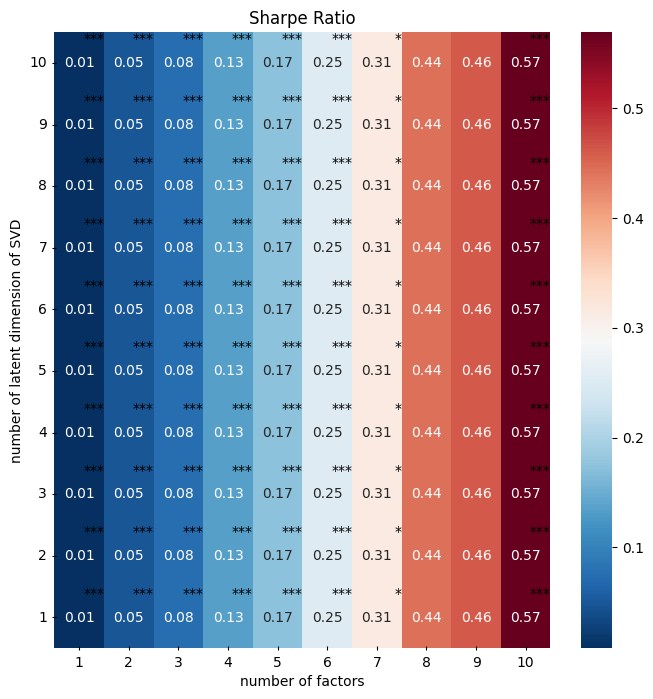

In [186]:
heatmap_sr, heatmap_py, heatmap_bkrs ,heatmap_grs  = make_heatmap(Result2_all,'SR')

## AdjSGLtestasst

In [275]:
Result_asset =[]
Klist = [1,2,3,4,5,6,7,8,9,10]
Result_asset  = Parallel(n_jobs=10)(delayed(adj)('AdjSGL',Z,36*12,fama285,j, -2 ,0.001,5,10000) for j in Klist)


[78 79 91 83 31 95  7 94 88 86 51 90 24] ['MKTRF' 'SMB' 'IVOL' 'UMD' 'EPRD' 'IMD' 'COP' 'ROE' 'STR' 'BAB' 'NOA'
 'REG' 'dROE1']
[78 79 25 94 93 28 74  3 42 56  2 83 22 88 35 50 31 48 97 95 91 38 98 29
 24 90  9 44 72] ['MKTRF' 'SMB' 'DTV12' 'ROE' 'IA' 'EBP' 'SP' 'BM' 'IR' 'OCP' 'ATO' 'UMD'
 'dPIA' 'STR' 'HS' 'NEI1' 'EPRD' 'ME' 'BETA' 'IMD' 'IVOL' 'ILE1' 'PEAD'
 'EM' 'dROE1' 'REG' 'CTO' 'ISq1' 'SGq1']
[78 79 84 91 94 11 99 81 85 26 25 97 74 76 28 86 62 48 47 98 80 90 20 56
  8 31 95  2 88  3 12 42] ['MKTRF' 'SMB' 'HMLM' 'IVOL' 'ROE' 'dBE' 'FIN' 'RMW' 'QMJ' 'Dur' 'DTV12'
 'BETA' 'SP' 'TV1' 'EBP' 'BAB' 'P52W6' 'ME' 'IVq1' 'PEAD' 'HML' 'REG'
 'dNOA' 'OCP' 'CP' 'EPRD' 'IMD' 'ATO' 'STR' 'BM' 'dCOA' 'IR']
[78 79 84 94 90 85  6 11 62 91 56 92 99 98 40  2  7 31 97 76 15 86 88 47
 95 54 44  9 10 52 66 80 29  3 13 27] ['MKTRF' 'SMB' 'HMLM' 'ROE' 'REG' 'QMJ' 'CLA' 'dBE' 'P52W6' 'IVOL' 'OCP'
 'SUE' 'FIN' 'PEAD' 'IM1' 'ATO' 'COP' 'EPRD' 'BETA' 'TV1' 'dII' 'BAB'
 'STR' 'IVq1' 'IMD' 'OA' 'ISq1' 'CTO' 

In [49]:
Result_asset=[({8: [78, 79, 91, 31, 83, 95, 7, 88], 9: [78, 79, 91, 31, 83, 95, 90, 98, 88], 7: [78, 79, 91, 31, 90, 83, 98], 6: [78, 79, 91, 90, 31, 83], 5: [78, 79, 90, 91, 94], 4: [78, 90, 79, 94], 3: [78, 79, 90], 2: [78, 90], 1: [90]}, {8: 0.38239762086760315, 9: 0.8136890997907511, 7: 0.6604512072873855, 6: 0.5369399670279204, 5: 0.528300940110237, 4: 0.42772886997768655, 3: 0.4267827622555258, 2: 0.3586533905197318, 1: 0.2598611521922185}, {8: [0.0, 19.728828400477905], 9: [5.4356963374857514e-11, 6.558485560793347], 7: [1.4653434021738576e-10, 6.408940581686489], 6: [0.0, 8.418020297598208], 5: [2.1048895737507678e-08, 5.603151610031599], 4: [1.3094690727299962e-06, 4.838311342457826], 3: [0.000311375827016791, 3.6056472845288248], 2: [0.0, 8.598537763851638], 1: [0.0, 14.029020675947285]}, {8: [0.00023619423655385496, 3.676782525754262], 9: [0.1907060021133662, 1.3084934282984102], 7: [0.04549960753412807, 2.0000060784818494], 6: [0.000311698312304598, 3.605378487880554], 5: [5.654341495175963e-05, 4.026790312119572], 4: [2.3033738028033213e-08, 5.587518384378011], 3: [7.2305985643339454e-09, 5.7854790205757505], 2: [4.129097064264897e-10, 6.2490677710203535], 1: [1.7985612998927536e-13, 7.363006266097757]}, {8: [1.1102230246251565e-16, 4.322048657233054, 0.0], 9: [2.768278051235029e-09, 2.462904934511579, 0.0], 7: [4.3454129183828627e-13, 2.9617993607741884, 0.0], 6: [1.1102230246251565e-16, 3.4496052505920933, 0.0], 5: [1.1102230246251565e-16, 3.4523426410227254, 0.0], 4: [1.1102230246251565e-16, 3.9006493138093377, 0.0], 3: [1.1102230246251565e-16, 3.865265910273265, 0.0], 2: [1.1102230246251565e-16, 4.187547760345275, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 1), ({10: [78, 25, 79, 28, 94, 42, 3, 98, 74, 90], 9: [78, 25, 79, 28, 94, 42, 98, 3, 90], 7: [78, 25, 79, 28, 94, 42, 98], 6: [78, 25, 79, 28, 94, 98], 5: [78, 25, 79, 94, 98], 4: [78, 25, 79, 94], 3: [78, 79, 25], 2: [78, 79], 1: [78]}, {10: 0.5443862374010605, 9: 0.541388865600097, 7: 0.3219805002495946, 6: 0.3110042789164436, 5: 0.26583706145998903, 4: 0.14178884495681876, 3: 0.01881394080455778, 2: 0.010011436648086194, 1: 0.006341526165412918}, {10: [6.352637971218655e-09, 5.807199622970991], 9: [3.035634632553297e-09, 5.929659531019672], 7: [0.0, 19.44776301113922], 6: [0.0, 21.246252112794277], 5: [0.0, 27.473501968404456], 4: [0.0, 24.94344024719279], 3: [0.0, 42.60279410371918], 2: [0.0, 40.491584146355905], 1: [0.0, 32.46259492271182]}, {10: [9.063109940599112e-05, 3.9143951765654794], 9: [0.0001014991090746431, 3.8869800098760963], 7: [2.2726198700695477e-10, 6.341687491089858], 6: [1.444322439425605e-10, 6.411143381773362], 5: [1.4090728583937562e-11, 6.756969848582674], 4: [2.220446049250313e-16, 8.236073862245833], 3: [0.0, 9.107064900100154], 2: [0.0, 9.20445941275301], 1: [0.0, 9.192687675854938]}, {10: [1.1102230246251565e-16, 3.5677635206681306, 0.0], 9: [1.1102230246251565e-16, 3.542513484859434, 0.0], 7: [1.1102230246251565e-16, 4.63412837981277, 0.0], 6: [1.1102230246251565e-16, 4.652785578233542, 0.0], 5: [1.1102230246251565e-16, 4.892778761869379, 0.0], 4: [1.1102230246251565e-16, 5.743571226688678, 0.0], 3: [1.1102230246251565e-16, 6.783615132800755, 0.0], 2: [1.1102230246251565e-16, 6.802437349988589, 0.0], 1: [1.1102230246251565e-16, 6.770511927480479, 0.0]}, 2), ({10: [84, 79, 78, 91, 94, 90, 97, 88, 85, 74], 9: [84, 91, 79, 78, 90, 94, 97, 88, 85], 8: [84, 91, 79, 78, 90, 94, 88, 97], 7: [84, 91, 78, 79, 90, 94, 88], 6: [84, 91, 78, 79, 90, 94], 5: [84, 91, 78, 90, 79], 4: [91, 84, 90, 78], 3: [91, 84, 90], 2: [91, 90], 1: [91]}, {10: 0.6401725167864125, 9: 0.637586178518515, 8: 0.6365108249255447, 7: 0.5969022621230825, 6: 0.5395179422813924, 5: 0.5379329297283285, 4: 0.4095781069066718, 3: 0.40731406865695186, 2: 0.3906878441178252, 1: 0.06536037930843114}, {10: [0.0, 16.257729250351474], 9: [0.0, 15.010875992013737], 8: [0.0, 11.738624944361979], 7: [0.0, 13.41203274477146], 6: [0.0, 11.282043666814387], 5: [0.0, 9.029955503839432], 4: [0.0, 16.682803830646638], 3: [0.0, 14.288389293940883], 2: [0.0, 10.829472524671479], 1: [0.0, 27.485595889292245]}, {10: [0.9455442769486953, 0.06830319987433243], 9: [0.9120211969127667, 0.11048947447597555], 8: [0.4760183748745015, 0.7127210713624346], 7: [0.25943662252383404, 1.127723706678402], 6: [0.0006657480375804603, 3.40330956789138], 5: [0.00048238763983965427, 3.4903503810954546], 4: [4.095283948402084e-06, 4.60648713018438], 3: [5.543463709845042e-06, 4.543093542941404], 2: [5.630479105178665e-08, 5.430156066849155], 1: [0.0, 8.60619216442684]}, {10: [3.397282455352979e-14, 3.1439741155962206, 0.0], 9: [4.196643033083092e-14, 3.1200979122026924, 0.0], 8: [5.728750807065808e-14, 3.090583019283863, 0.0], 7: [4.9960036108132044e-15, 3.2217289356940038, 0.0], 6: [1.1102230246251565e-16, 3.4379144572151064, 0.0], 5: [1.1102230246251565e-16, 3.4088334631098984, 0.0], 4: [1.1102230246251565e-16, 3.995408979710432, 0.0], 3: [1.1102230246251565e-16, 3.966086897626726, 0.0], 2: [1.1102230246251565e-16, 4.0130508816510035, 0.0], 1: [1.1102230246251565e-16, 6.209659777075621, 0.0]}, 3), ({10: [84, 91, 6, 90, 78, 62, 85, 98, 97, 88], 8: [84, 91, 90, 6, 78, 88, 98, 62], 7: [84, 91, 90, 6, 78, 88, 98], 6: [84, 91, 90, 6, 78, 88], 5: [84, 91, 90, 6, 88], 4: [84, 91, 90, 88], 3: [84, 91, 90], 2: [84, 90], 1: [84]}, {10: 0.8385896954046215, 8: 0.7610745736163574, 7: 0.7303412304709324, 6: 0.4937402296762131, 5: 0.4900051990716954, 4: 0.4675618612751591, 3: 0.40731406865695186, 2: 0.2682375976977933, 1: 0.01117340050373691}, {10: [2.220446049250313e-16, 8.183859455817249], 8: [0.0, 8.768507838934902], 7: [0.0, 9.871909422614845], 6: [0.0, 18.74049073602907], 5: [0.0, 12.379821948259615], 4: [0.0, 15.81454551864228], 3: [0.0, 14.288389293940904], 2: [0.0, 20.803689832417096], 1: [0.0, 27.419532705390413]}, {10: [0.015809726743487573, 2.4132786689553822], 8: [0.3437452356744988, 0.9467911041812291], 7: [0.5298207109001507, 0.6282797254013787], 6: [0.018632157534014038, 2.3528098850823564], 5: [0.01843016840519418, 2.3568605103193603], 4: [0.013782117837952468, 2.462892637263262], 3: [5.543463709845042e-06, 4.543093542941405], 2: [1.411537553508424e-11, 6.75671651919049], 1: [0.0, 9.037211435712337]}, {10: [7.937352441977907e-09, 2.406584254974634, 0.0], 8: [1.8365464704572787e-10, 2.6167318392469046, 0.0], 7: [3.99938970829794e-11, 2.697978511071437, 0.0], 6: [1.1102230246251565e-16, 3.6515144116052274, 0.0], 5: [1.1102230246251565e-16, 3.6308947407239844, 0.0], 4: [1.1102230246251565e-16, 3.70090966434257, 0.0], 3: [1.1102230246251565e-16, 3.9660868976267216, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 4), ({10: [84, 91, 90, 6, 78, 88, 98, 85, 54, 62], 9: [84, 91, 90, 6, 78, 88, 98, 85, 54], 8: [84, 91, 90, 6, 78, 88, 98, 85], 7: [84, 91, 90, 6, 88, 78, 98], 6: [84, 91, 90, 88, 6, 98], 5: [84, 91, 90, 88, 98], 4: [84, 91, 90, 88], 3: [84, 90, 91], 2: [84, 90], 1: [84]}, {10: 0.7781401928142772, 9: 0.7458677813380091, 8: 0.7383202789957737, 7: 0.7303412304709324, 6: 0.7256549605904994, 5: 0.7203394983303434, 4: 0.4675618612751591, 3: 0.40731406865695186, 2: 0.2682375976977933, 1: 0.01117340050373691}, {10: [0.0, 11.692935440165748], 9: [0.0, 13.16184162212766], 8: [0.0, 13.40358830862088], 7: [0.0, 9.871909422614841], 6: [4.330371659033716e-07, 5.053829964628484], 5: [9.848466064887873e-08, 5.329497897183164], 4: [0.0, 15.81454551864228], 3: [0.0, 14.28838929394091], 2: [0.0, 20.803689832417096], 1: [0.0, 27.419532705390413]}, {10: [0.10158457339897731, 1.6372196943564719], 9: [0.1882816042036657, 1.3156795995446855], 8: [0.1828577611557758, 1.332007386933526], 7: [0.5298207109001498, 0.6282797254013799], 6: [0.4955355202926932, 0.6815310599971222], 5: [0.4742028300160812, 0.7156575476877459], 4: [0.013782117837952468, 2.462892637263262], 3: [5.543463709845042e-06, 4.543093542941403], 2: [1.411537553508424e-11, 6.75671651919049], 1: [0.0, 9.037211435712337]}, {10: [2.556131972752951e-10, 2.6138054409578197, 0.0], 9: [5.1710857817965916e-11, 2.700307493447124, 0.0], 8: [4.6161630073981996e-11, 2.698221546863214, 0.0], 7: [3.99938970829794e-11, 2.697978511071443, 0.0], 6: [4.235312101030786e-11, 2.68611685971436, 0.0], 5: [4.303102318914398e-11, 2.676852030550099, 0.0], 4: [1.1102230246251565e-16, 3.70090966434257, 0.0], 3: [1.1102230246251565e-16, 3.9660868976267234, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 5), ({10: [85, 91, 84, 90, 79, 88, 6, 98, 20, 31], 9: [84, 91, 85, 90, 88, 6, 98, 79, 20], 8: [84, 91, 85, 90, 88, 6, 98, 79], 7: [84, 91, 85, 90, 88, 98, 6], 6: [84, 90, 91, 88, 85, 98], 4: [84, 90, 88, 91], 3: [84, 90, 88], 2: [90, 84], 1: [90]}, {10: 0.8427791594616488, 9: 0.828031581438149, 8: 0.8280312902158241, 7: 0.7382122819206056, 6: 0.7247875048160594, 4: 0.4675618612751591, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [1.0937695194002117e-11, 6.793590236078598], 9: [3.176433338580864e-09, 5.922210160017092], 8: [2.4930291320224285e-07, 5.158224259344215], 7: [0.0, 10.610488074141749], 6: [0.0, 11.162099074917139], 4: [0.0, 15.81454551864227], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.004604048142818451, 2.833505737784897], 9: [0.02692993656779641, 2.212531870996262], 8: [0.027021483497931875, 2.211207323240325], 7: [0.15580432560593271, 1.41932486690814], 6: [0.16646367433018971, 1.3836564505231417], 4: [0.013782117837952468, 2.462892637263262], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.756716519190489], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [9.965762326480387e-09, 2.392726508909052, 0.0], 9: [6.133260899154891e-09, 2.4149568649747875, 0.0], 8: [8.424147046603991e-09, 2.388708289275633, 0.0], 7: [6.492117954337573e-11, 2.669596054273966, 0.0], 6: [4.013867016539052e-11, 2.689244124687576, 0.0], 4: [1.1102230246251565e-16, 3.70090966434257, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961962, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 6), ({10: [84, 91, 85, 90, 88, 6, 98, 31, 79, 20], 9: [84, 91, 85, 90, 88, 6, 98, 31, 79], 8: [84, 91, 85, 90, 88, 6, 98, 31], 7: [84, 90, 91, 85, 88, 98, 6], 6: [84, 90, 91, 88, 85, 98], 5: [84, 90, 88, 91, 98], 4: [90, 84, 88, 91], 3: [90, 84, 88], 2: [90, 88], 1: [90]}, {10: 0.8427791594616489, 9: 0.842627287365973, 8: 0.7477011769022681, 7: 0.7382122819206058, 6: 0.7247875048160594, 5: 0.7203394983303434, 4: 0.4675618612751592, 3: 0.3632650715881808, 2: 0.36326060932708015, 1: 0.2598611521922185}, {10: [1.0937695194002117e-11, 6.7935902360785745], 9: [2.322483760863747e-09, 5.973477821116268], 8: [0.0, 12.130000643629016], 7: [0.0, 10.610488074141738], 6: [0.0, 11.162099074917139], 5: [9.848466064887873e-08, 5.329497897183172], 4: [0.0, 15.814545518642257], 3: [0.0, 19.67842751259804], 2: [0.0, 14.327162616426513], 1: [0.0, 14.029020675947285]}, {10: [0.004604048142818451, 2.833505737784898], 9: [0.005073916779715804, 2.8023031678850177], 8: [0.046485404469291725, 1.9909589131582623], 7: [0.15580432560593271, 1.4193248669081395], 6: [0.16646367433018971, 1.3836564505231417], 5: [0.4742028300160799, 0.715657547687748], 4: [0.013782117837952246, 2.462892637263264], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [2.2372059760300544e-09, 5.979574965227249], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [9.965762326480387e-09, 2.392726508909047, 0.0], 9: [1.355569323457928e-08, 2.366928558535949, 0.0], 8: [8.197831302680925e-11, 2.664368765203059, 0.0], 7: [6.492117954337573e-11, 2.669596054273955, 0.0], 6: [4.013867016539052e-11, 2.689244124687576, 0.0], 5: [4.303102318914398e-11, 2.676852030550094, 0.0], 4: [1.1102230246251565e-16, 3.7009096643425776, 0.0], 3: [1.1102230246251565e-16, 4.20482828135539, 0.0], 2: [1.1102230246251565e-16, 4.16194658212582, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 7), ({10: [84, 85, 91, 88, 90, 79, 98, 31, 11, 24], 9: [84, 85, 91, 88, 90, 79, 98, 31, 11], 8: [84, 85, 91, 88, 90, 98, 79, 31], 7: [84, 85, 88, 91, 90, 98, 79], 6: [84, 85, 88, 91, 90, 98], 5: [84, 88, 90, 85, 91], 4: [84, 88, 90, 85], 3: [88, 84, 90], 2: [88, 90], 1: [88]}, {10: 0.8511062489822874, 9: 0.8451473608448637, 8: 0.8422279873950235, 7: 0.8257678505781098, 6: 0.7247875048160595, 5: 0.46815261942856884, 4: 0.3688984399837694, 3: 0.36326507158818083, 2: 0.36326060932708004, 1: 0.023508461578625933}, {10: [7.105427357601002e-15, 7.782155346869131], 9: [2.5880853016246874e-11, 6.668285464223958], 8: [1.4376793533443788e-08, 5.668839531699067], 7: [4.316595298980985e-07, 5.05443818689887], 6: [0.0, 11.162099074917128], 5: [0.0, 20.329159572778995], 4: [0.0, 19.996020425684623], 3: [0.0, 19.678427512598052], 2: [0.0, 14.327162616426508], 1: [0.0, 31.764578145053658]}, {10: [0.0006767263918592281, 3.3988385984023135], 9: [0.0050387000658145276, 2.8045491762477335], 8: [0.004336103325207619, 2.852615635206332], 7: [0.023501398356900793, 2.265183873139136], 6: [0.16646367433019105, 1.3836564505231368], 5: [0.04153973297625524, 2.038102002240001], 4: [2.9412104900483627e-06, 4.674883141078451], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [2.2372059760300544e-09, 5.979574965227245], 1: [0.0, 9.000381241054663]}, {10: [1.5602825698124434e-08, 2.3653687298105233, 0.0], 9: [1.551891570805708e-08, 2.3587129826750894, 0.0], 8: [1.8120603462179474e-08, 2.34249070480689, 0.0], 7: [1.0191500754430649e-08, 2.3703784040262392, 0.0], 6: [4.013867016539052e-11, 2.689244124687589, 0.0], 5: [1.1102230246251565e-16, 3.7369555341392697, 0.0], 4: [1.1102230246251565e-16, 4.216912449776018, 0.0], 3: [1.1102230246251565e-16, 4.204828281355391, 0.0], 2: [1.1102230246251565e-16, 4.161946582125812, 0.0], 1: [1.1102230246251565e-16, 6.600704962205906, 0.0]}, 8), ({10: [84, 88, 91, 85, 90, 98, 31, 79, 62, 11], 9: [84, 88, 91, 85, 90, 98, 31, 79, 62], 8: [84, 88, 91, 85, 90, 98, 31, 79], 7: [84, 88, 91, 85, 90, 98, 31], 6: [84, 88, 90, 91, 85, 98], 5: [88, 84, 90, 91, 85], 4: [88, 84, 90, 91], 3: [88, 84, 90], 2: [88, 84], 1: [88]}, {10: 0.8462631825829352, 9: 0.8444519147462153, 8: 0.8422279873950237, 7: 0.7283719352091966, 6: 0.7247875048160592, 5: 0.4681526194285688, 4: 0.4675618612751592, 3: 0.36326507158818083, 2: 0.027988824432775207, 1: 0.023508461578625933}, {10: [2.220446049250313e-16, 8.165838256078912], 9: [1.0653700144303002e-12, 7.121780955782822], 8: [1.4376793533443788e-08, 5.6688395316990725], 7: [0.0, 13.149672533409268], 6: [0.0, 11.16209907491712], 5: [0.0, 20.329159572778984], 4: [0.0, 15.814545518642257], 3: [0.0, 19.678427512598052], 2: [0.0, 39.5156935222847], 1: [0.0, 31.764578145053658]}, {10: [0.004225016159232098, 2.860853966884772], 9: [0.0034565148526148892, 2.9239218763466885], 8: [0.004336103325207619, 2.8526156352063303], 7: [0.05659416549272933, 1.9064321141384133], 6: [0.16646367433019016, 1.3836564505231397], 5: [0.04153973297625524, 2.038102002240001], 4: [0.013782117837952468, 2.4628926372632627], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [4.440892098500626e-16, 8.150791442679715], 1: [0.0, 9.000381241054663]}, {10: [1.2029653495559955e-08, 2.3812500905627476, 0.0], 9: [1.4951090365755704e-08, 2.3609779317521498, 0.0], 8: [1.8120603462179474e-08, 2.342490704806889, 0.0], 7: [3.540101545240759e-11, 2.7051200807642113, 0.0], 6: [4.013867016539052e-11, 2.689244124687576, 0.0], 5: [1.1102230246251565e-16, 3.7369555341392697, 0.0], 4: [1.1102230246251565e-16, 3.7009096643425776, 0.0], 3: [1.1102230246251565e-16, 4.204828281355391, 0.0], 2: [1.1102230246251565e-16, 6.624232065109301, 0.0], 1: [1.1102230246251565e-16, 6.600704962205906, 0.0]}, 9), ({10: [88, 84, 91, 85, 90, 98, 31, 79, 11, 24], 9: [88, 84, 91, 85, 90, 98, 31, 79, 11], 8: [88, 84, 91, 85, 90, 98, 31, 79], 7: [88, 84, 91, 85, 90, 98, 31], 6: [88, 84, 91, 85, 90, 98], 5: [88, 84, 90, 91, 85], 4: [88, 84, 90, 91], 3: [88, 84, 90], 2: [88, 84], 1: [88]}, {10: 0.8511062489822877, 9: 0.8451473608448641, 8: 0.8422279873950236, 7: 0.7283719352091964, 6: 0.7247875048160594, 5: 0.4681526194285688, 4: 0.4675618612751592, 3: 0.36326507158818083, 2: 0.027988824432775207, 1: 0.023508461578625933}, {10: [7.105427357601002e-15, 7.782155346869149], 9: [2.5880853016246874e-11, 6.668285464223951], 8: [1.4376793533443788e-08, 5.668839531699033], 7: [0.0, 13.149672533409168], 6: [0.0, 11.16209907491712], 5: [0.0, 20.329159572778984], 4: [0.0, 15.814545518642257], 3: [0.0, 19.678427512598052], 2: [0.0, 39.5156935222847], 1: [0.0, 31.764578145053658]}, {10: [0.0006767263918594502, 3.3988385984023113], 9: [0.0050387000658145276, 2.804549176247736], 8: [0.004336103325207619, 2.852615635206328], 7: [0.05659416549272933, 1.9064321141384122], 6: [0.16646367433019105, 1.3836564505231368], 5: [0.04153973297625524, 2.038102002240001], 4: [0.013782117837952468, 2.4628926372632627], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [4.440892098500626e-16, 8.150791442679715], 1: [0.0, 9.000381241054663]}, {10: [1.5602825698124434e-08, 2.3653687298105224, 0.0], 9: [1.551891570805708e-08, 2.3587129826750814, 0.0], 8: [1.8120603462179474e-08, 2.342490704806894, 0.0], 7: [3.540101545240759e-11, 2.7051200807642153, 0.0], 6: [4.013867016539052e-11, 2.6892441246875736, 0.0], 5: [1.1102230246251565e-16, 3.7369555341392697, 0.0], 4: [1.1102230246251565e-16, 3.7009096643425776, 0.0], 3: [1.1102230246251565e-16, 4.204828281355391, 0.0], 2: [1.1102230246251565e-16, 6.624232065109301, 0.0], 1: [1.1102230246251565e-16, 6.600704962205906, 0.0]}, 10)]

In [50]:
np.array(dff100.columns)[np.array(Result_asset[4][0][5])]

array(['HMLM', 'IVOL', 'REG', 'STR', 'PEAD'], dtype=object)

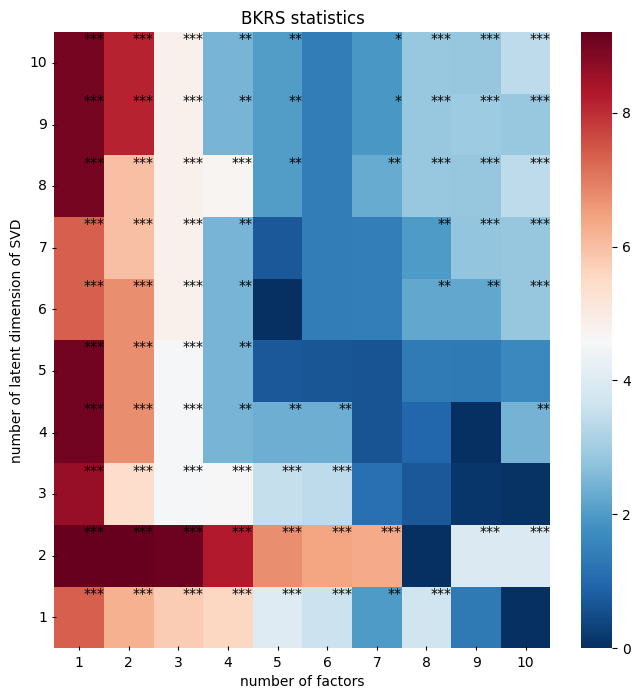

In [26]:
heatmap_sr, heatmap_py, heatmap_bkrs ,heatmap_grs  = make_heatmap(Result_asset,'BKRS')

In [161]:
Result_asset1  =[]
Klist = [1,2,3,4,5,6,7,8,9,10]
Result_asset1  = Parallel(n_jobs=10)(delayed(adj)('AdjSGL',Z,36*12,fama285,j, -1 ,0.01,5,5000) for j in Klist)



[78 79 91 31 83 95  7 88 51 86] ['MKTRF' 'SMB' 'IVOL' 'EPRD' 'UMD' 'IMD' 'COP' 'STR' 'NOA' 'BAB']
[78 79 25 94 28 93 74 42 56  3 50  2 83 22 88 35 31 98 38 72 95 90 29 91
 97] ['MKTRF' 'SMB' 'DTV12' 'ROE' 'EBP' 'IA' 'SP' 'IR' 'OCP' 'BM' 'NEI1' 'ATO'
 'UMD' 'dPIA' 'STR' 'HS' 'EPRD' 'PEAD' 'ILE1' 'SGq1' 'IMD' 'REG' 'EM'
 'IVOL' 'BETA']
[78 79 84 91 94 11 99 81 25 26 74 86 47 97 85 28 80 20 48  8 90 56 98 76
 62 31 12  3 88 95 42  2 58] ['MKTRF' 'SMB' 'HMLM' 'IVOL' 'ROE' 'dBE' 'FIN' 'RMW' 'DTV12' 'Dur' 'SP'
 'BAB' 'IVq1' 'BETA' 'QMJ' 'EBP' 'HML' 'dNOA' 'ME' 'CP' 'REG' 'OCP' 'PEAD'
 'TV1' 'P52W6' 'EPRD' 'dCOA' 'BM' 'STR' 'IMD' 'IR' 'ATO' 'OLEq1']
[78 79 84 91 94 90 11 85 62 56 99 92 98  6 40 31 86  2 15 76 88 97  9 80
  7 47 54  3 10 44 52 95 83 13 66 29 64 81 51] ['MKTRF' 'SMB' 'HMLM' 'IVOL' 'ROE' 'REG' 'dBE' 'QMJ' 'P52W6' 'OCP' 'FIN'
 'SUE' 'PEAD' 'CLA' 'IM1' 'EPRD' 'BAB' 'ATO' 'dII' 'TV1' 'STR' 'BETA'
 'CTO' 'HML' 'COP' 'IVq1' 'OA' 'BM' 'DAC' 'ISq1' 'NOP' 'IMD' 'UMD' 'dFIN'
 'r1a' 'EM' 

In [21]:
Result_asset1=[({10: [78, 79, 91, 31, 83, 95, 7, 88, 51, 86], 8: [78, 79, 91, 31, 83, 95, 7, 88], 9: [78, 79, 91, 31, 83, 95, 7, 88, 6], 7: [78, 79, 91, 31, 83, 95, 7], 6: [78, 79, 31, 91, 90, 95], 5: [78, 79, 90, 31, 91], 3: [78, 79, 90], 4: [78, 79, 90, 94], 2: [78, 90], 1: [78]}, {10: 0.3839907501298531, 8: 0.38239762086760315, 9: 0.38970657342934634, 7: 0.3251086641102419, 6: 0.5464778337207437, 5: 0.536819116218372, 3: 0.4267827622555258, 4: 0.4277288699776865, 2: 0.3586533905197318, 1: 0.006341526165412918}, {10: [0.0, 20.958956955238424], 8: [0.0, 19.728828400477905], 9: [0.0, 20.765944697066157], 7: [0.0, 16.02698520941981], 6: [3.262501380163485e-12, 6.965929276546491], 5: [1.1262102361797588e-12, 7.114121153898902], 3: [0.000311375827016791, 3.6056472845288248], 4: [1.3094690727299962e-06, 4.83831134245783], 2: [0.0, 8.598537763851638], 1: [0.0, 32.46259492271182]}, {10: [0.0014507151690117404, 3.184365885946494], 8: [0.00023619423655385496, 3.676782525754262], 9: [0.00023542015594602006, 3.67762018939139], 7: [8.389597461189169e-09, 5.760437939049111], 6: [0.0004891467692840212, 3.4866304452723567], 5: [0.00013767459552593841, 3.8123090258077794], 3: [7.2305985643339454e-09, 5.7854790205757505], 4: [2.3033738028033213e-08, 5.5875183843780105], 2: [4.129097064264897e-10, 6.2490677710203535], 1: [0.0, 9.192687675854938]}, {10: [1.1102230246251565e-16, 4.408762132168588, 0.0], 8: [1.1102230246251565e-16, 4.322048657233054, 0.0], 9: [1.1102230246251565e-16, 4.327374783604404, 0.0], 7: [1.1102230246251565e-16, 4.6147612726168274, 0.0], 6: [2.220446049250313e-16, 3.406546884673906, 0.0], 5: [1.1102230246251565e-16, 3.4138368430078527, 0.0], 3: [1.1102230246251565e-16, 3.865265910273265, 0.0], 4: [1.1102230246251565e-16, 3.9006493138093465, 0.0], 2: [1.1102230246251565e-16, 4.187547760345275, 0.0], 1: [1.1102230246251565e-16, 6.770511927480479, 0.0]}, 1), ({10: [78, 25, 79, 28, 94, 42, 74, 3, 98, 2], 9: [78, 25, 79, 28, 94, 42, 74, 3, 98], 8: [78, 25, 79, 28, 42, 94, 74, 3], 7: [78, 25, 79, 28, 42, 94, 74], 6: [78, 25, 79, 28, 42, 94], 5: [78, 25, 79, 42, 28], 4: [78, 25, 79, 42], 3: [78, 25, 79], 2: [78, 79], 1: [78]}, {10: 0.3296781592176544, 9: 0.32652976252519866, 8: 0.19134753990034334, 7: 0.18768953810689468, 6: 0.18498469124719777, 5: 0.02974789398576394, 4: 0.026217941847632514, 3: 0.018813940804557765, 2: 0.010011436648086194, 1: 0.006341526165412918}, {10: [0.0, 20.740154011815857], 9: [0.0, 20.024323755341758], 8: [0.0, 22.951540531773652], 7: [0.0, 23.1307973866016], 6: [0.0, 21.529758550024667], 5: [0.0, 51.6845749697666], 4: [0.0, 49.34220904145868], 3: [0.0, 42.60279410371917], 2: [0.0, 40.491584146355905], 1: [0.0, 32.46259492271182]}, {10: [7.972555948754234e-11, 6.501117256892391], 9: [1.056594811643663e-10, 6.458623593955364], 8: [4.440892098500626e-16, 8.10338659639543], 7: [8.881784197001252e-16, 8.039288939052968], 6: [1.1102230246251565e-15, 8.00402130069792], 5: [0.0, 9.13652761297161], 4: [0.0, 9.127301096941427], 3: [0.0, 9.107064900100152], 2: [0.0, 9.20445941275301], 1: [0.0, 9.192687675854938]}, {10: [1.1102230246251565e-16, 4.739522176776085, 0.0], 9: [1.1102230246251565e-16, 4.707223751075514, 0.0], 8: [1.1102230246251565e-16, 5.593860023519651, 0.0], 7: [1.1102230246251565e-16, 5.561749461273994, 0.0], 6: [1.1102230246251565e-16, 5.523204062351937, 0.0], 5: [1.1102230246251565e-16, 6.8157752425466205, 0.0], 4: [1.1102230246251565e-16, 6.7798739231817455, 0.0], 3: [1.1102230246251565e-16, 6.783615132800734, 0.0], 2: [1.1102230246251565e-16, 6.802437349988589, 0.0], 1: [1.1102230246251565e-16, 6.770511927480479, 0.0]}, 2), ({10: [84, 79, 91, 78, 90, 94, 97, 74, 86, 11], 9: [84, 79, 91, 78, 90, 94, 97, 74, 86], 8: [84, 79, 91, 78, 90, 94, 97, 74], 7: [84, 91, 79, 78, 90, 94, 97], 6: [84, 91, 79, 78, 90, 94], 5: [84, 91, 79, 78, 90], 4: [91, 84, 78, 90], 3: [91, 78, 84], 2: [91, 78], 1: [91]}, {10: 0.5953351719480791, 9: 0.5881293708504011, 8: 0.5881124709598899, 7: 0.5801144899671006, 6: 0.5395179422813924, 5: 0.5379329297283285, 4: 0.4095781069066719, 3: 0.14286454380451355, 2: 0.14043752610293614, 1: 0.06536037930843114}, {10: [0.0, 10.350612145508881], 9: [0.0, 9.00277904127003], 8: [0.0, 8.724048727223403], 7: [0.0, 8.8270718580137], 6: [0.0, 11.282043666814376], 5: [0.0, 9.029955503839433], 4: [0.0, 16.682803830646662], 3: [0.0, 25.262404093301214], 2: [0.0, 17.67487014803513], 1: [0.0, 27.485595889292245]}, {10: [0.004399989974895435, 2.8479640126043386], 9: [0.004530702875011672, 2.838634442420417], 8: [0.0031931888329146396, 2.9485012161094435], 7: [0.0029018018968287596, 2.977953305262801], 6: [0.0006657480375804603, 3.4033095678913696], 5: [0.00048238763983965427, 3.490350381095457], 4: [4.095283948402084e-06, 4.60648713018438], 3: [3.659295089164516e-13, 7.267569036945293], 2: [3.774758283725532e-15, 7.860871848766643], 1: [0.0, 8.60619216442684]}, {10: [1.3322676295501878e-15, 3.336013656974277, 0.0], 9: [1.2212453270876722e-15, 3.3308779117870086, 0.0], 8: [1.7763568394002505e-15, 3.2947461792518706, 0.0], 7: [1.4432899320127035e-15, 3.293885854388678, 0.0], 6: [1.1102230246251565e-16, 3.437914457215091, 0.0], 5: [1.1102230246251565e-16, 3.408833463109893, 0.0], 4: [1.1102230246251565e-16, 3.9954089797104366, 0.0], 3: [1.1102230246251565e-16, 5.675787329726564, 0.0], 2: [1.1102230246251565e-16, 5.637036421055478, 0.0], 1: [1.1102230246251565e-16, 6.209659777075621, 0.0]}, 3), ({10: [84, 91, 90, 6, 78, 62, 97, 85, 98, 11], 9: [84, 91, 90, 6, 78, 62, 97, 85, 98], 8: [84, 91, 90, 6, 78, 62, 97, 98], 7: [84, 91, 90, 6, 78, 62, 97], 6: [84, 91, 90, 78, 6, 62], 5: [84, 91, 90, 78, 6], 4: [84, 91, 90, 78], 3: [84, 91, 90], 2: [84, 91], 1: [84]}, {10: 0.7158562540821436, 9: 0.7106053349442536, 8: 0.6934949872490724, 7: 0.5108594804839454, 6: 0.44303628222676383, 5: 0.428930803508337, 4: 0.4095781069066719, 3: 0.40731406865695186, 2: 0.08312928007544264, 1: 0.01117340050373691}, {10: [0.0, 8.565129403117115], 9: [4.5274894944213884e-13, 7.238806252868159], 8: [3.52947114468094e-06, 4.637325059397779], 7: [0.0, 10.494099415980731], 6: [0.0, 15.721776652255642], 5: [0.0, 15.462895672931818], 4: [0.0, 16.682803830646655], 3: [0.0, 14.288389293940904], 2: [0.0, 30.791912767807908], 1: [0.0, 27.419532705390413]}, {10: [0.45710183278699157, 0.7436275474459465], 9: [0.47491690668329056, 0.7145018595859011], 8: [0.17742353899198138, 1.3487305192551295], 7: [0.0002754944868659237, 3.637315416639148], 6: [1.7289672756382046e-05, 4.297292826132336], 5: [7.4493722703739e-06, 4.480427381241211], 4: [4.095283948402084e-06, 4.606487130184377], 3: [5.543463709845042e-06, 4.543093542941405], 2: [4.884981308350689e-15, 7.832008455613569], 1: [0.0, 9.037211435712337]}, {10: [5.492828414332962e-12, 2.8425872089839355, 0.0], 9: [5.6522564406691345e-12, 2.831178856985347, 0.0], 8: [2.691957767808617e-12, 2.8651599822277936, 0.0], 7: [1.1102230246251565e-16, 3.6085087821340904, 0.0], 6: [1.1102230246251565e-16, 3.9039184755119036, 0.0], 5: [1.1102230246251565e-16, 3.9354536744805864, 0.0], 4: [1.1102230246251565e-16, 3.995408979710429, 0.0], 3: [1.1102230246251565e-16, 3.9660868976267216, 0.0], 2: [1.1102230246251565e-16, 6.114537105845764, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 4), ({10: [84, 91, 90, 6, 78, 85, 88, 98, 54, 11], 9: [84, 91, 90, 6, 78, 88, 98, 85, 54], 8: [84, 91, 90, 6, 78, 88, 98, 85], 7: [84, 91, 90, 6, 78, 88, 98], 6: [84, 91, 90, 88, 78, 6], 5: [84, 91, 90, 88, 78], 4: [84, 91, 90, 88], 3: [84, 91, 90], 2: [84, 90], 1: [84]}, {10: 0.7506269029057757, 9: 0.7458677813380091, 8: 0.7383202789957737, 7: 0.7303412304709324, 6: 0.49374022967621306, 5: 0.4677769669668778, 4: 0.4675618612751591, 3: 0.40731406865695186, 2: 0.2682375976977933, 1: 0.01117340050373691}, {10: [0.0, 14.609973388885566], 9: [0.0, 13.16184162212766], 8: [0.0, 13.40358830862088], 7: [0.0, 9.871909422614845], 6: [0.0, 18.74049073602905], 5: [0.0, 21.72132598977691], 4: [0.0, 15.81454551864228], 3: [0.0, 14.288389293940904], 2: [0.0, 20.803689832417096], 1: [0.0, 27.419532705390413]}, {10: [0.2094276897326588, 1.255140694932534], 9: [0.1882816042036657, 1.3156795995446855], 8: [0.1828577611557758, 1.332007386933526], 7: [0.5298207109001507, 0.6282797254013787], 6: [0.018632157534014038, 2.3528098850823573], 5: [0.011533973922489116, 2.5260905787716883], 4: [0.013782117837952468, 2.462892637263262], 3: [5.543463709845042e-06, 4.543093542941405], 2: [1.411537553508424e-11, 6.75671651919049], 1: [0.0, 9.037211435712337]}, {10: [4.867550806864074e-11, 2.712860160163793, 0.0], 9: [5.1710857817965916e-11, 2.700307493447124, 0.0], 8: [4.6161630073981996e-11, 2.698221546863214, 0.0], 7: [3.99938970829794e-11, 2.697978511071437, 0.0], 6: [1.1102230246251565e-16, 3.6515144116052225, 0.0], 5: [1.1102230246251565e-16, 3.7388063623675873, 0.0], 4: [1.1102230246251565e-16, 3.70090966434257, 0.0], 3: [1.1102230246251565e-16, 3.9660868976267216, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 6.72213434532419, 0.0]}, 5), ({10: [84, 91, 85, 79, 90, 88, 98, 20, 6, 25], 9: [84, 91, 85, 79, 90, 88, 98, 20, 6], 8: [84, 91, 85, 90, 79, 88, 98, 20], 7: [84, 91, 85, 90, 79, 88, 98], 6: [84, 91, 90, 85, 88, 98], 5: [84, 90, 91, 85, 88], 4: [84, 90, 91, 88], 3: [84, 90, 91], 2: [84, 90], 1: [90]}, {10: 0.8291175773536652, 9: 0.8280315814381491, 8: 0.8257790964346468, 7: 0.8257678505781098, 6: 0.7247875048160594, 5: 0.46815261942856884, 4: 0.46756186127515914, 3: 0.40731406865695186, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [2.274502364230102e-09, 5.9768809881477445], 9: [3.176433338580864e-09, 5.922210160017056], 8: [7.820115222045843e-09, 5.7722904787286], 7: [4.316595298980985e-07, 5.054438186898915], 6: [0.0, 11.162099074917133], 5: [0.0, 20.329159572778952], 4: [0.0, 15.814545518642253], 3: [0.0, 14.28838929394091], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.02833631889544108, 2.1925985056111834], 9: [0.026929936567796187, 2.2125318709962674], 8: [0.023438487507317696, 2.2662106725501494], 7: [0.02350139835690057, 2.2651838731391387], 6: [0.16646367433019105, 1.3836564505231368], 5: [0.04153973297625502, 2.0381020022400023], 4: [0.013782117837952468, 2.462892637263262], 3: [5.543463709845042e-06, 4.543093542941403], 2: [1.411537553508424e-11, 6.75671651919049], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [4.72102557047549e-09, 2.438149771543915, 0.0], 9: [6.133260899154891e-09, 2.414956864974789, 0.0], 8: [7.4494628243826355e-09, 2.39610639997068, 0.0], 7: [1.0191500754430649e-08, 2.3703784040262343, 0.0], 6: [4.013867016539052e-11, 2.6892441246875816, 0.0], 5: [1.1102230246251565e-16, 3.736955534139293, 0.0], 4: [1.1102230246251565e-16, 3.700909664342567, 0.0], 3: [1.1102230246251565e-16, 3.9660868976267234, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 6), ({10: [84, 91, 85, 90, 88, 79, 98, 25, 31, 6], 9: [84, 91, 85, 90, 88, 79, 98, 6, 25], 8: [84, 91, 85, 90, 88, 79, 98, 6], 7: [84, 91, 90, 85, 88, 98, 6], 6: [84, 90, 91, 88, 85, 98], 5: [84, 90, 91, 88, 85], 4: [84, 90, 91, 88], 3: [84, 90, 88], 2: [84, 90], 1: [90]}, {10: 0.8431878578333598, 9: 0.8291061473884441, 8: 0.8280312902158242, 7: 0.7382122819206056, 6: 0.7247875048160594, 5: 0.46815261942856884, 4: 0.46756186127515914, 3: 0.3632650715881808, 2: 0.2682375976977933, 1: 0.2598611521922185}, {10: [4.5507486667872854e-10, 6.233861712873859], 9: [1.4527059977176293e-07, 5.258455156522604], 8: [2.4930291320224285e-07, 5.158224259344219], 7: [0.0, 10.61048807414173], 6: [0.0, 11.162099074917139], 5: [0.0, 20.32915957277898], 4: [0.0, 15.814545518642253], 3: [0.0, 19.678427512598045], 2: [0.0, 20.803689832417096], 1: [0.0, 14.029020675947285]}, {10: [0.005039677752539662, 2.8044866312847647], 9: [0.027005997135328474, 2.211431115339888], 8: [0.02702148349793143, 2.2112073232403304], 7: [0.15580432560593382, 1.419324866908136], 6: [0.16646367433018971, 1.3836564505231417], 5: [0.04153973297625524, 2.038102002240001], 4: [0.013782117837952468, 2.462892637263262], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [1.411537553508424e-11, 6.75671651919049], 1: [1.7985612998927536e-13, 7.363006266097757]}, {10: [1.0188743071459783e-08, 2.3913780048486015, 0.0], 9: [6.50571319038562e-09, 2.4113947836358434, 0.0], 8: [8.424147046603991e-09, 2.388708289275626, 0.0], 7: [6.492117954337573e-11, 2.6695960542739594, 0.0], 6: [4.013867016539052e-11, 2.689244124687576, 0.0], 5: [1.1102230246251565e-16, 3.736955534139276, 0.0], 4: [1.1102230246251565e-16, 3.700909664342567, 0.0], 3: [1.1102230246251565e-16, 4.204828281355393, 0.0], 2: [1.1102230246251565e-16, 4.727609823961947, 0.0], 1: [1.1102230246251565e-16, 4.733267842213827, 0.0]}, 7), ({10: [91, 84, 85, 88, 79, 90, 11, 98, 31, 24], 9: [84, 91, 88, 85, 90, 79, 98, 11, 31], 8: [84, 91, 88, 85, 90, 79, 98, 11], 7: [84, 88, 91, 90, 85, 79, 98], 6: [84, 88, 91, 90, 85, 79], 5: [88, 84, 90, 85, 91], 4: [88, 84, 90, 85], 3: [88, 84, 90], 2: [88, 84], 1: [88]}, {10: 0.8511062489822875, 9: 0.8451473608448639, 8: 0.8303121072732482, 7: 0.8257678505781098, 6: 0.5836025578988282, 5: 0.4681526194285688, 4: 0.3688984399837695, 3: 0.36326507158818083, 2: 0.027988824432775207, 1: 0.023508461578625933}, {10: [7.105427357601002e-15, 7.782155346869159], 9: [2.5880853016246874e-11, 6.6682854642239455], 8: [1.0571747477428062e-08, 5.7212912770638455], 7: [4.316595298980985e-07, 5.054438186898929], 6: [0.0, 11.630725455311973], 5: [0.0, 20.32915957277895], 4: [0.0, 19.996020425684623], 3: [0.0, 19.678427512598052], 2: [0.0, 39.5156935222847], 1: [0.0, 31.764578145053658]}, {10: [0.0006767263918592281, 3.398838598402313], 9: [0.00503870006581475, 2.804549176247728], 8: [0.02619881834507387, 2.22325190899408], 7: [0.02350139835690057, 2.265183873139138], 6: [0.31903507602725156, 0.9964427385785177], 5: [0.041539732976254795, 2.0381020022400045], 4: [2.9412104900483627e-06, 4.6748831410784515], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [4.440892098500626e-16, 8.150791442679715], 1: [0.0, 9.000381241054663]}, {10: [1.5602825698124434e-08, 2.3653687298105135, 0.0], 9: [1.551891570805708e-08, 2.3587129826750886, 0.0], 8: [9.537397760439603e-09, 2.381234710777424, 0.0], 7: [1.0191500754430649e-08, 2.3703784040262432, 0.0], 6: [2.7755575615628914e-15, 3.243887081900521, 0.0], 5: [1.1102230246251565e-16, 3.736955534139279, 0.0], 4: [1.1102230246251565e-16, 4.21691244977603, 0.0], 3: [1.1102230246251565e-16, 4.204828281355391, 0.0], 2: [1.1102230246251565e-16, 6.624232065109301, 0.0], 1: [1.1102230246251565e-16, 6.600704962205906, 0.0]}, 8), ({10: [84, 88, 91, 85, 90, 79, 98, 31, 13, 11], 9: [84, 88, 91, 85, 90, 79, 98, 31, 13], 8: [84, 88, 91, 85, 90, 79, 98, 31], 7: [84, 88, 91, 85, 90, 98, 79], 6: [84, 88, 91, 85, 90, 98], 5: [88, 84, 91, 90, 85], 4: [88, 84, 90, 91], 3: [88, 84, 90], 2: [88, 84], 1: [88]}, {10: 0.8490494686347339, 9: 0.8479749364705169, 8: 0.8422279873950237, 7: 0.82576785057811, 6: 0.7247875048160595, 5: 0.4681526194285689, 4: 0.4675618612751592, 3: 0.36326507158818083, 2: 0.027988824432775207, 1: 0.023508461578625933}, {10: [2.0764234776038393e-10, 6.355579430076938], 9: [2.42817590923039e-07, 5.163158326422734], 8: [1.4376793533443788e-08, 5.668839531699083], 7: [4.316595298980985e-07, 5.0544381868988895], 6: [0.0, 11.162099074917073], 5: [0.0, 20.329159572779027], 4: [0.0, 15.814545518642257], 3: [0.0, 19.678427512598052], 2: [0.0, 39.5156935222847], 1: [0.0, 31.764578145053658]}, {10: [0.005487450125182036, 2.7769329291320046], 9: [0.004363359381089005, 2.850623558257644], 8: [0.004336103325207619, 2.852615635206332], 7: [0.023501398356900793, 2.2651838731391343], 6: [0.1664636743301906, 1.3836564505231386], 5: [0.04153973297625502, 2.038102002240002], 4: [0.013782117837952468, 2.4628926372632627], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [4.440892098500626e-16, 8.150791442679715], 1: [0.0, 9.000381241054663]}, {10: [1.3974341572797755e-08, 2.3721031510904296, 0.0], 9: [1.805149085765123e-08, 2.3495216082699493, 0.0], 8: [1.8120603462179474e-08, 2.342490704806886, 0.0], 7: [1.0191500754430649e-08, 2.3703784040262454, 0.0], 6: [4.013867016539052e-11, 2.6892441246875753, 0.0], 5: [1.1102230246251565e-16, 3.7369555341392715, 0.0], 4: [1.1102230246251565e-16, 3.7009096643425776, 0.0], 3: [1.1102230246251565e-16, 4.204828281355391, 0.0], 2: [1.1102230246251565e-16, 6.624232065109301, 0.0], 1: [1.1102230246251565e-16, 6.600704962205906, 0.0]}, 9), ({10: [88, 84, 91, 85, 90, 98, 79, 31, 13, 11], 9: [88, 84, 91, 85, 90, 98, 79, 31, 13], 8: [88, 84, 91, 85, 90, 98, 79, 31], 7: [88, 84, 91, 85, 90, 98, 79], 6: [88, 84, 91, 85, 90, 98], 5: [88, 84, 91, 90, 85], 4: [88, 84, 90, 91], 3: [88, 84, 90], 2: [88, 84], 1: [88]}, {10: 0.8490494686347337, 9: 0.847974936470517, 8: 0.8422279873950237, 7: 0.8257678505781099, 6: 0.7247875048160594, 5: 0.4681526194285689, 4: 0.4675618612751592, 3: 0.36326507158818083, 2: 0.027988824432775207, 1: 0.023508461578625933}, {10: [2.0764234776038393e-10, 6.355579430076964], 9: [2.42817590923039e-07, 5.163158326422734], 8: [1.4376793533443788e-08, 5.668839531699044], 7: [4.316595298980985e-07, 5.054438186898911], 6: [0.0, 11.16209907491712], 5: [0.0, 20.329159572779027], 4: [0.0, 15.814545518642257], 3: [0.0, 19.678427512598052], 2: [0.0, 39.5156935222847], 1: [0.0, 31.764578145053658]}, {10: [0.005487450125182036, 2.776932929132006], 9: [0.004363359381088783, 2.850623558257657], 8: [0.004336103325207619, 2.85261563520633], 7: [0.023501398356900793, 2.2651838731391356], 6: [0.16646367433019105, 1.3836564505231368], 5: [0.04153973297625502, 2.038102002240002], 4: [0.013782117837952468, 2.4628926372632627], 3: [1.2306389465255307e-06, 4.850639740389882], 2: [4.440892098500626e-16, 8.150791442679715], 1: [0.0, 9.000381241054663]}, {10: [1.3974341572797755e-08, 2.3721031510904287, 0.0], 9: [1.805149085765123e-08, 2.349521608269951, 0.0], 8: [1.8120603462179474e-08, 2.34249070480689, 0.0], 7: [1.0191500754430649e-08, 2.3703784040262406, 0.0], 6: [4.013867016539052e-11, 2.6892441246875736, 0.0], 5: [1.1102230246251565e-16, 3.7369555341392715, 0.0], 4: [1.1102230246251565e-16, 3.7009096643425776, 0.0], 3: [1.1102230246251565e-16, 4.204828281355391, 0.0], 2: [1.1102230246251565e-16, 6.624232065109301, 0.0], 1: [1.1102230246251565e-16, 6.600704962205906, 0.0]}, 10)]

In [34]:
np.array(dff100.columns)[np.array(Result_asset1[4][0][5])]

array(['HMLM', 'IVOL', 'REG', 'STR', 'MKTRF'], dtype=object)

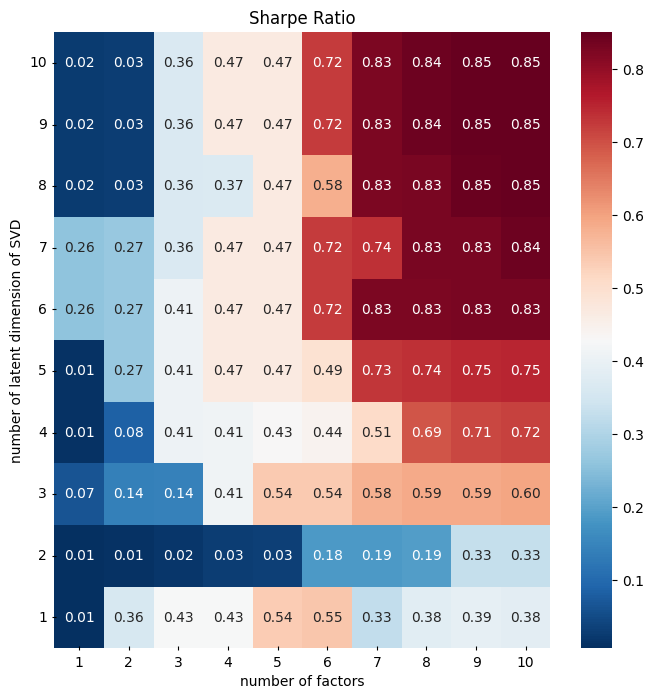

In [49]:
heatmap_sr, heatmap_py, heatmap_bkrs ,heatmap_grs  = make_heatmap(Result_asset1,'SR')

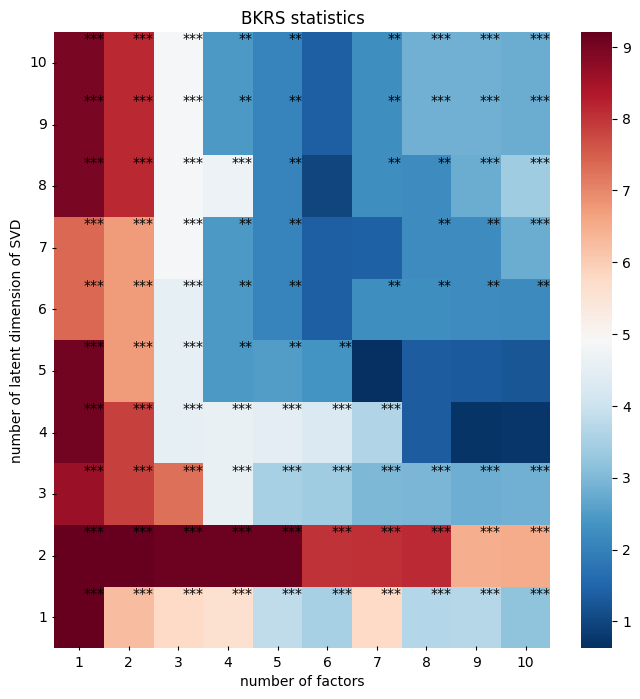

In [14]:
heatmap_sr, heatmap_py, heatmap_bkrs ,heatmap_grs  = make_heatmap(Result_asset1,'BKRS')

In [262]:
Result_all_asset =[]
Klist = [1,2,3,4,5,6,7,8,9,10]
Result_all_asset = Parallel(n_jobs=10)(delayed(adj)('AdjSGL',Z,Z.shape[0],fama285,j, -2 ,0.001,5,10000) for j in Klist)


[78 79  7 31 91 83 86  6  9 88 41 93 95 90 51 71 94] ['MKTRF' 'SMB' 'COP' 'EPRD' 'IVOL' 'UMD' 'BAB' 'CLA' 'CTO' 'STR' 'IOCA'
 'IA' 'IMD' 'REG' 'NOA' 'RS1' 'ROE']
[78 79 84 91 99 76 81 11 94 62 56 74 85 25  2 28  8 90 86 80 98 31 97 95
  6 88 12 10  9 48] ['MKTRF' 'SMB' 'HMLM' 'IVOL' 'FIN' 'TV1' 'RMW' 'dBE' 'ROE' 'P52W6' 'OCP'
 'SP' 'QMJ' 'DTV12' 'ATO' 'EBP' 'CP' 'REG' 'BAB' 'HML' 'PEAD' 'EPRD'
 'BETA' 'IMD' 'CLA' 'STR' 'dCOA' 'DAC' 'CTO' 'ME']
[78 79 25 93 84 74 56 28 94 72  2 42 31 95  3 91 76 97 90 98  9 35 88 37
 19 48 82 22 51 86 10 24] ['MKTRF' 'SMB' 'DTV12' 'IA' 'HMLM' 'SP' 'OCP' 'EBP' 'ROE' 'SGq1' 'ATO'
 'IR' 'EPRD' 'IMD' 'BM' 'IVOL' 'TV1' 'BETA' 'REG' 'PEAD' 'CTO' 'HS' 'STR'
 'IG' 'dNCO' 'ME' 'CMA' 'dPIA' 'NOA' 'BAB' 'DAC' 'dROE1']
[78 79 84 91 99 56 83 62  6 81  7 76 85 90 92 86 98 11 31  2 88 51 10 93
 74  9 24 40 95 97 64 87 34 44 54 80  8] ['MKTRF' 'SMB' 'HMLM' 'IVOL' 'FIN' 'OCP' 'UMD' 'P52W6' 'CLA' 'RMW' 'COP'
 'TV1' 'QMJ' 'REG' 'SUE' 'BAB' 'PEAD' 'dBE' 'EPRD' 'ATO' 'STR' 

In [15]:
Result_all_asset=[({10: [78, 7, 6, 31, 86, 2, 79, 94, 24, 70], 9: [78, 7, 6, 31, 86, 2, 94, 24, 70], 8: [78, 7, 6, 31, 86, 94, 2, 24], 7: [78, 7, 6, 31, 86, 94, 2], 6: [78, 7, 91, 90, 31, 94], 5: [78, 7, 91, 90, 94], 4: [78, 91, 7, 90], 3: [78, 91, 90], 2: [91, 90], 1: [91]}, {10: 0.20064479973769678, 9: 0.16769985427089912, 8: 0.15653127418746302, 7: 0.13015909024570108, 6: 0.29210100967877983, 5: 0.29096324354121195, 4: 0.2902520267262729, 3: 0.26760583242130753, 2: 0.2656534305600611, 1: 0.0711290188770953}, {10: [0.0, 32.23181833750027], 9: [0.0, 34.96120768436332], 8: [0.0, 33.796074538242976], 7: [0.0, 35.289999930634835], 6: [0.0, 17.88349073445172], 5: [0.0, 12.83404960216097], 4: [0.0, 12.173668850369749], 3: [0.0, 17.836440524810712], 2: [0.0, 14.322597896739504], 1: [0.0, 26.97356915276307]}, {10: [2.0169199643760294e-11, 6.704793061337532], 9: [4.1027181651998035e-12, 6.933594242996327], 8: [9.690026558928366e-13, 7.134828687669117], 7: [8.970602038971265e-14, 7.455327991663656], 6: [1.4042370764189016e-05, 4.343197623892167], 5: [2.8864597481081944e-06, 4.678738011423613], 4: [2.4679275947292467e-06, 4.710761626121707], 3: [4.779682019062648e-07, 5.0349521539530855], 2: [4.237183173216863e-07, 5.057981145060979], 1: [4.440892098500626e-16, 8.132259925958941]}, {10: [1.1102230246251565e-16, 4.246976158953186, 0.0], 9: [1.1102230246251565e-16, 4.473831036776252, 0.0], 8: [1.1102230246251565e-16, 4.520419952403669, 0.0], 7: [1.1102230246251565e-16, 4.701619355102747, 0.0], 6: [1.1102230246251565e-16, 3.4019455194875863, 0.0], 5: [1.1102230246251565e-16, 3.373740831898069, 0.0], 4: [1.1102230246251565e-16, 3.3433089646671257, 0.0], 3: [1.1102230246251565e-16, 3.460044728920234, 0.0], 2: [1.1102230246251565e-16, 3.437891592159122, 0.0], 1: [1.1102230246251565e-16, 4.938410230704088, 0.0]}, 1), ({10: [78, 25, 79, 74, 28, 2, 98, 56, 90, 95], 9: [78, 25, 79, 2, 74, 28, 98, 90, 95], 8: [78, 25, 79, 2, 74, 28, 98, 90], 7: [78, 79, 25, 2, 74, 98, 90], 6: [78, 79, 25, 2, 98, 90], 5: [78, 79, 25, 90, 98], 4: [78, 79, 90, 25], 3: [78, 79, 90], 2: [78, 79], 1: [78]}, {10: 0.3790623105475668, 9: 0.37154342580075467, 8: 0.35992928868516927, 7: 0.35473285295153867, 6: 0.3330993243126113, 5: 0.3264250442343997, 4: 0.2847889757962099, 3: 0.27006598406031257, 2: 0.016274000651310787, 1: 0.015219620698530455}, {10: [3.68549635254567e-12, 6.94874848802485], 9: [6.372680161348399e-13, 7.192244986740247], 8: [5.1514348342607263e-14, 7.528109873921878], 7: [9.547918011776346e-15, 7.7451829208637], 6: [0.0, 12.881417016667003], 5: [0.0, 14.156612710967854], 4: [0.0, 9.754449439383677], 3: [0.0, 12.797249480630443], 2: [0.0, 42.042254393607195], 1: [0.0, 33.67685278470257]}, {10: [8.983758673997144e-05, 3.916516722964735], 9: [5.644923860526063e-05, 4.027182411216092], 8: [4.067221141590416e-05, 4.103627513938529], 7: [3.247029016795189e-05, 4.155411296828531], 6: [1.705364485427019e-05, 4.300339757011375], 5: [1.3931903185548933e-05, 4.344931656053973], 4: [3.295223696131444e-07, 5.105728591193775], 3: [1.223856957999203e-07, 5.289896350217219], 2: [0.0, 8.907665120638915], 1: [0.0, 8.90993945773598]}, {10: [1.432187701766452e-14, 2.978764204525229, 0.0], 9: [8.659739592076221e-15, 2.9923020654557444, 0.0], 8: [3.1086244689504383e-15, 3.0314686872920755, 0.0], 7: [2.4424906541753444e-15, 3.0309976045087095, 0.0], 6: [2.220446049250313e-16, 3.1337358160367312, 0.0], 5: [1.1102230246251565e-16, 3.1428344700327755, 0.0], 4: [1.1102230246251565e-16, 3.37967140105922, 0.0], 3: [1.1102230246251565e-16, 3.4433578567479532, 0.0], 2: [1.1102230246251565e-16, 5.533471597278343, 0.0], 1: [1.1102230246251565e-16, 5.488512130276129, 0.0]}, 2), ({10: [84, 78, 91, 79, 62, 81, 90, 97, 56, 86], 9: [84, 78, 91, 79, 62, 90, 81, 97, 56], 8: [84, 78, 91, 79, 90, 62, 81, 97], 7: [84, 78, 91, 79, 90, 97, 81], 6: [78, 84, 91, 90, 79, 97], 5: [78, 84, 91, 90, 97], 4: [78, 84, 91, 90], 3: [78, 84, 91], 2: [78, 91], 1: [91]}, {10: 0.41272084946229753, 9: 0.40547001437337216, 8: 0.40475700860030434, 7: 0.4032564465006677, 6: 0.40070764895618693, 5: 0.3432311838083591, 4: 0.2987266833445478, 3: 0.12917438112172683, 2: 0.1271331433807395, 1: 0.0711290188770953}, {10: [0.0, 10.983423437299132], 9: [0.0, 10.294888857831682], 8: [0.0, 8.345957448925766], 7: [1.6187051699034782e-13, 7.377064136713469], 6: [2.305888813225465e-11, 6.68521344257518], 5: [0.0, 12.336931004449374], 4: [0.0, 16.362711861513397], 3: [0.0, 23.926445203800434], 2: [0.0, 15.517048914596415], 1: [0.0, 26.97356915276307]}, {10: [0.10077069116081372, 1.6411287536412058], 9: [0.06498410248006947, 1.8453674657025658], 8: [0.06638549246301606, 1.8358118216948918], 7: [0.050604026855459505, 1.9548224800061746], 6: [0.05501104744196472, 1.918788961212054], 5: [0.011362240328636641, 2.5313561793479575], 4: [0.00048813213020015844, 3.4871857895745544], 3: [1.559632423209223e-10, 6.399424988683625], 2: [3.8391512191537913e-13, 7.261144060234949], 1: [4.440892098500626e-16, 8.132259925958941]}, {10: [7.922551503725117e-13, 2.775431229107779, 0.0], 9: [5.099254352103344e-13, 2.7874393323933315, 0.0], 8: [6.997735724212362e-13, 2.7612990141712896, 0.0], 7: [8.735234757750732e-13, 2.7402778062585367, 0.0], 6: [9.632294961647858e-13, 2.725738203595761, 0.0], 5: [1.3322676295501878e-15, 3.0376610027675026, 0.0], 4: [1.1102230246251565e-16, 3.2875064367547595, 0.0], 3: [1.1102230246251565e-16, 4.5161643285854405, 0.0], 2: [1.1102230246251565e-16, 4.4874161285127006, 0.0], 1: [1.1102230246251565e-16, 4.938410230704088, 0.0]}, 3), ({10: [84, 78, 91, 6, 62, 90, 98, 97, 10, 88], 9: [84, 78, 91, 6, 62, 90, 98, 97, 10], 8: [84, 78, 91, 6, 62, 90, 98, 97], 7: [84, 78, 91, 6, 62, 90, 98], 6: [84, 91, 78, 6, 62, 90], 5: [84, 78, 91, 90, 6], 4: [84, 91, 78, 90], 3: [84, 91, 78], 2: [84, 91], 1: [84]}, {10: 0.502351033699897, 9: 0.4516874186799294, 8: 0.4506719187557855, 7: 0.42491500736908844, 6: 0.3112054466655156, 5: 0.3068362749519042, 4: 0.2987266833445478, 3: 0.1291743811217268, 2: 0.0781611588354988, 1: 0.008241569029185306}, {10: [0.0, 9.967159246239934], 9: [1.9984014443252818e-15, 7.942389007952537], 8: [1.9761969838327786e-14, 7.652887547414569], 7: [0.0, 9.293656811181593], 6: [0.0, 17.295179197001698], 5: [0.0, 14.91187795623837], 4: [0.0, 16.362711861513393], 3: [0.0, 23.926445203800437], 2: [0.0, 34.27744736836267], 1: [0.0, 28.91510306512162]}, {10: [0.14374117763475036, 1.4620001176420845], 9: [0.4942801357426254, 0.683517120336067], 8: [0.46249077396329685, 0.7347516239413799], 7: [0.11745444495935353, 1.5655481145028367], 6: [0.0008030513323140642, 3.3517409161114107], 5: [0.0006285416111642128, 3.4189894598418498], 4: [0.00048813213020015844, 3.4871857895745593], 3: [1.559632423209223e-10, 6.39942498868363], 2: [8.275602425555917e-13, 7.1564966772281045], 1: [0.0, 8.330383593565047]}, {10: [1.081565226268566e-08, 2.2784049924689125, 0.0], 9: [8.89547324689488e-11, 2.523766872617216, 0.0], 8: [1.152336004395238e-10, 2.501886567790105, 0.0], 7: [1.0175527087596947e-11, 2.6169059922269877, 0.0], 6: [1.1102230246251565e-16, 3.2748780184280215, 0.0], 5: [1.1102230246251565e-16, 3.2688357512796915, 0.0], 4: [1.1102230246251565e-16, 3.2875064367547564, 0.0], 3: [1.1102230246251565e-16, 4.516164328585444, 0.0], 2: [1.1102230246251565e-16, 4.922986203961479, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 4), ({10: [84, 78, 91, 90, 6, 98, 88, 16, 86, 10], 9: [84, 78, 91, 90, 6, 98, 88, 16, 86], 8: [84, 78, 91, 90, 6, 98, 88, 16], 7: [84, 78, 91, 90, 6, 98, 88], 6: [84, 91, 78, 90, 98, 6], 5: [84, 91, 78, 90, 98], 4: [84, 91, 90, 78], 3: [91, 84, 90], 2: [91, 84], 1: [84]}, {10: 0.4803328389453027, 9: 0.47689741057443547, 8: 0.4682256219618282, 7: 0.4667422469819219, 6: 0.4092294829342158, 5: 0.4072902622215314, 4: 0.2987266833445479, 3: 0.298616887961398, 2: 0.07816115883549879, 1: 0.008241569029185306}, {10: [0.0, 10.454478994224592], 9: [0.0, 10.701793578327653], 8: [0.0, 9.841467037034274], 7: [0.0, 9.545811174802024], 6: [0.0, 8.82559095708609], 5: [0.0, 8.33081075569182], 4: [0.0, 16.36271186151339], 3: [0.0, 13.16540444524289], 2: [0.0, 34.27744736836268], 1: [0.0, 28.91510306512162]}, {10: [0.4415308339257267, 0.7696107371526044], 9: [0.5282661641691, 0.6306549454128347], 8: [0.6478187231154888, 0.4567945504474233], 7: [0.7056849600671316, 0.37765761248012697], 6: [0.0771938237407177, 1.7672054713332233], 5: [0.07987564517011214, 1.7514080626566608], 4: [0.00048813213020015844, 3.4871857895745566], 3: [0.000584502177221724, 3.438705751063881], 2: [8.275602425555917e-13, 7.1564966772281045], 1: [0.0, 8.330383593565047]}, {10: [1.2229421919585093e-09, 2.394925861633103, 0.0], 9: [1.226722057268148e-09, 2.386898475438234, 0.0], 8: [7.201055307604065e-10, 2.406997925959681, 0.0], 7: [8.784040161913254e-10, 2.3889616570882457, 0.0], 6: [2.558064871038823e-12, 2.67708949633601, 0.0], 5: [3.0120350658080497e-12, 2.6598122938527062, 0.0], 4: [1.1102230246251565e-16, 3.2875064367547573, 0.0], 3: [1.1102230246251565e-16, 3.25432551835909, 0.0], 2: [1.1102230246251565e-16, 4.922986203961479, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 5), ({10: [91, 84, 85, 90, 79, 25, 98, 88, 6, 31], 9: [91, 84, 85, 90, 79, 25, 98, 88, 6], 8: [91, 84, 85, 90, 25, 98, 79, 88], 7: [84, 91, 90, 85, 98, 88, 25], 6: [84, 91, 90, 85, 98, 88], 5: [84, 91, 90, 85, 98], 4: [84, 90, 91, 98], 3: [84, 90, 91], 2: [84, 90], 1: [84]}, {10: 0.555229230802645, 9: 0.5458550485988513, 8: 0.5444992237605341, 7: 0.53130094622154, 6: 0.4720481251071962, 5: 0.4102286284281687, 4: 0.406424846385704, 3: 0.29861688796139807, 2: 0.1701307089092924, 1: 0.008241569029185306}, {10: [1.5972045908085875e-10, 6.395788887290168], 9: [4.3995884713154965e-09, 5.868423295980153], 8: [2.4618261207365322e-08, 5.575950015572052], 7: [9.33186861118429e-12, 6.816449184552551], 6: [0.0, 12.864349441620176], 5: [0.0, 12.912530115017198], 4: [1.060374010819487e-11, 6.798059823008432], 3: [0.0, 13.16540444524288], 2: [0.0, 20.969139771312356], 1: [0.0, 28.91510306512162]}, {10: [0.003158371366922763, 2.9518883230174007], 9: [0.02248546269959073, 2.282065682556547], 8: [0.022118580064548254, 2.2883253714108105], 7: [0.03282334283441113, 2.1342375200102524], 6: [0.22747849342701754, 1.2068796561870205], 5: [0.35653887191899525, 0.9219802608391743], 4: [0.08746248648557353, 1.7089377201186036], 3: [0.000584502177221724, 3.438705751063881], 2: [1.3018438105305563e-08, 5.685822730437112], 1: [0.0, 8.330383593565047]}, {10: [1.3095522013450989e-06, 2.012048302568086, 0.0], 9: [7.893709336181942e-07, 2.035324113678911, 0.0], 8: [9.428624697660482e-07, 2.0197391713473998, 0.0], 7: [4.0386924027302484e-07, 2.0615811776272346, 0.0], 6: [2.1199783040160014e-09, 2.33585551610533, 0.0], 5: [4.19964063524958e-12, 2.643303915431621, 0.0], 4: [3.994027331089001e-12, 2.636930375700478, 0.0], 3: [1.1102230246251565e-16, 3.254325518359082, 0.0], 2: [1.1102230246251565e-16, 4.135042414850142, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 6), ({10: [91, 84, 85, 88, 25, 90, 98, 62, 31, 93], 9: [91, 84, 85, 88, 90, 25, 98, 62, 31], 8: [91, 84, 88, 85, 90, 98, 25, 31], 7: [91, 84, 88, 85, 90, 98, 25], 6: [84, 91, 90, 88, 98, 85], 5: [84, 91, 90, 88, 98], 4: [84, 91, 90, 88], 3: [84, 91, 90], 2: [84, 91], 1: [84]}, {10: 0.5674437270772258, 9: 0.5482001203930883, 8: 0.5409222867144404, 7: 0.53130094622154, 6: 0.47204812510719624, 5: 0.46425626838679274, 4: 0.3212924837581452, 3: 0.298616887961398, 2: 0.0781611588354988, 1: 0.008241569029185306}, {10: [0.0, 8.463754337812073], 9: [0.0, 9.380276001804848], 8: [1.5698553568199713e-13, 7.38119040720518], 7: [9.33186861118429e-12, 6.816449184552565], 6: [0.0, 12.864349441620181], 5: [1.006705829809107e-11, 6.805541440959814], 4: [0.0, 16.057308594827845], 3: [0.0, 13.165404445242899], 2: [0.0, 34.27744736836267], 1: [0.0, 28.91510306512162]}, {10: [0.0010797607294474876, 3.268874785994242], 9: [0.00421044047613206, 2.8619494551730735], 8: [0.006360879167239375, 2.728574129900088], 7: [0.03282334283441091, 2.1342375200102555], 6: [0.22747849342701665, 1.2068796561870228], 5: [0.6614275426397336, 0.43794308406985705], 4: [0.07335192762510756, 1.7906347448890445], 3: [0.000584502177221724, 3.4387057510638797], 2: [8.275602425555917e-13, 7.1564966772281045], 1: [0.0, 8.330383593565047]}, {10: [3.6223193841111723e-06, 1.9530768272061558, 0.0], 9: [9.652265025028584e-07, 2.023918617194979, 0.0], 8: [6.933685450238869e-07, 2.03704332441588, 0.0], 7: [4.0386924027302484e-07, 2.0615811776272337, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053314, 0.0], 5: [1.3607208693144912e-09, 2.351573921680584, 0.0], 4: [1.1102230246251565e-16, 3.142409550974844, 0.0], 3: [1.1102230246251565e-16, 3.254325518359087, 0.0], 2: [1.1102230246251565e-16, 4.922986203961479, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 7), ({10: [91, 84, 88, 85, 90, 98, 62, 79, 6, 31], 9: [91, 84, 88, 85, 90, 98, 62, 79, 6], 8: [91, 84, 88, 85, 90, 98, 62, 79], 7: [91, 84, 88, 85, 90, 98, 62], 6: [84, 91, 88, 85, 90, 98], 5: [84, 91, 90, 88, 85], 4: [84, 91, 90, 88], 3: [84, 91, 90], 2: [84, 91], 1: [84]}, {10: 0.5544860253957293, 9: 0.5459231707727854, 8: 0.5452590561195182, 7: 0.48546057711662227, 6: 0.4720481251071963, 5: 0.32379494204523546, 4: 0.3212924837581452, 3: 0.298616887961398, 2: 0.0781611588354988, 1: 0.008241569029185306}, {10: [4.440892098500626e-16, 8.121515249361039], 9: [4.056754931980322e-13, 7.2536645674461315], 8: [3.134381643121742e-12, 6.971567059974931], 7: [0.0, 15.121175298823697], 6: [0.0, 12.86434944162021], 5: [0.0, 23.439422131235602], 4: [0.0, 16.057308594827845], 3: [0.0, 13.165404445242899], 2: [0.0, 34.27744736836267], 1: [0.0, 28.91510306512162]}, {10: [0.003270047109739993, 2.941141886007895], 9: [0.026067375971773554, 2.2252065407144577], 8: [0.02524269570998161, 2.2376682729254234], 7: [0.15000720474336715, 1.4395060229150527], 6: [0.2274784934270171, 1.2068796561870212], 5: [0.22611251794657794, 1.2104336976723917], 4: [0.07335192762510756, 1.7906347448890445], 3: [0.000584502177221724, 3.4387057510638797], 2: [8.275602425555917e-13, 7.1564966772281045], 1: [0.0, 8.330383593565047]}, {10: [1.2295658741168225e-06, 2.0156664014206114, 0.0], 9: [7.940105261061703e-07, 2.0349923065283644, 0.0], 8: [1.0060947477352755e-06, 2.0160736455918333, 0.0], 7: [5.713874151602738e-09, 2.2911108229863064, 0.0], 6: [2.1199783040160014e-09, 2.33585551610533, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934445, 0.0], 4: [1.1102230246251565e-16, 3.142409550974844, 0.0], 3: [1.1102230246251565e-16, 3.254325518359087, 0.0], 2: [1.1102230246251565e-16, 4.922986203961479, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 8), ({10: [91, 84, 88, 85, 90, 62, 98, 79, 31, 6], 9: [91, 84, 88, 85, 90, 98, 62, 31, 6], 8: [91, 84, 88, 85, 90, 98, 62, 31], 7: [91, 84, 88, 85, 90, 98, 62], 6: [91, 84, 88, 85, 90, 98], 5: [84, 91, 88, 90, 85], 4: [84, 91, 88, 90], 3: [84, 88, 91], 2: [88, 84], 1: [88]}, {10: 0.5544860253957293, 9: 0.49927530668111336, 8: 0.4864788698234995, 7: 0.48546057711662227, 6: 0.47204812510719624, 5: 0.32379494204523546, 4: 0.32129248375814506, 3: 0.07993659492063435, 2: 0.019782300624978797, 1: 0.016203917181884957}, {10: [4.440892098500626e-16, 8.121515249361044], 9: [0.0, 15.214887209841322], 8: [0.0, 17.85257741223681], 7: [0.0, 15.121175298823697], 6: [0.0, 12.864349441620197], 5: [0.0, 23.43942213123561], 4: [0.0, 16.057308594827845], 3: [0.0, 40.72278203785438], 2: [0.0, 38.72420085904775], 1: [0.0, 30.35921182876951]}, {10: [0.003270047109739993, 2.941141886007893], 9: [0.031678869161733125, 2.1484393557285535], 8: [0.047375404257526954, 1.982928611170913], 7: [0.15000720474336715, 1.4395060229150527], 6: [0.22747849342701754, 1.2068796561870205], 5: [0.22611251794657816, 1.2104336976723915], 4: [0.07335192762510712, 1.7906347448890478], 3: [1.5336127923148979e-09, 6.040790194007612], 2: [5.262457136723242e-13, 7.218360778296648], 1: [2.220446049250313e-16, 8.208082041989968]}, {10: [1.2295658741168225e-06, 2.015666401420609, 0.0], 9: [1.1227697993554386e-08, 2.2692621491223055, 0.0], 8: [4.510553597292244e-09, 2.3107046205641693, 0.0], 7: [5.713874151602738e-09, 2.2911108229863064, 0.0], 6: [2.1199783040160014e-09, 2.33585551610533, 0.0], 5: [1.1102230246251565e-16, 3.159535409293443, 0.0], 4: [1.1102230246251565e-16, 3.1424095509748544, 0.0], 3: [1.1102230246251565e-16, 4.95708739532345, 0.0], 2: [1.1102230246251565e-16, 5.49688283917014, 0.0], 1: [1.1102230246251565e-16, 5.478304024035181, 0.0]}, 9), ({10: [91, 88, 84, 85, 90, 79, 98, 62, 13, 31], 9: [91, 84, 88, 85, 90, 98, 79, 62, 31], 8: [91, 84, 88, 85, 90, 98, 79, 62], 7: [91, 84, 88, 85, 90, 98, 79], 6: [88, 84, 91, 90, 85, 98], 5: [88, 84, 91, 90, 85], 4: [88, 84, 91, 90], 3: [88, 84, 90], 2: [88, 84], 1: [88]}, {10: 0.5584222255115496, 9: 0.5544258084708532, 8: 0.5452590561195182, 7: 0.5437754910896571, 6: 0.4720481251071962, 5: 0.3237949420452355, 4: 0.32129248375814506, 3: 0.2193006144238577, 2: 0.019782300624978797, 1: 0.016203917181884957}, {10: [1.0480505352461478e-13, 7.434561502331669], 9: [3.552713678800501e-15, 7.868188490047417], 8: [3.134381643121742e-12, 6.971567059974905], 7: [6.270971868449493e-07, 4.982679663998806], 6: [0.0, 12.864349441620176], 5: [0.0, 23.439422131235602], 4: [0.0, 16.057308594827838], 3: [0.0, 21.74348747536471], 2: [0.0, 38.72420085904775], 1: [0.0, 30.35921182876951]}, {10: [0.0037613668921789856, 2.8975108819387163], 9: [0.003633027415530732, 2.9083833020386614], 8: [0.02524269570998161, 2.237668272925424], 7: [0.03166783643170734, 2.1485783875512623], 6: [0.22747849342701665, 1.206879656187023], 5: [0.22611251794657994, 1.2104336976723864], 4: [0.07335192762510667, 1.7906347448890505], 3: [0.0001397609613973394, 3.808590911980814], 2: [5.262457136723242e-13, 7.218360778296648], 1: [2.220446049250313e-16, 8.208082041989968]}, {10: [1.7142905129885477e-06, 1.9965433138156672, 0.0], 9: [1.6362401495939594e-06, 1.9938062997715889, 0.0], 8: [1.0060947477352755e-06, 2.016073645591831, 0.0], 7: [1.185063564945743e-06, 2.0014786996680893, 0.0], 6: [2.1199783040160014e-09, 2.3358555161053314, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934382, 0.0], 4: [1.1102230246251565e-16, 3.1424095509748455, 0.0], 3: [1.1102230246251565e-16, 3.8013339721533854, 0.0], 2: [1.1102230246251565e-16, 5.49688283917014, 0.0], 1: [1.1102230246251565e-16, 5.478304024035181, 0.0]}, 10)]

In [ ]:
['AdjSGL',Z,Z.shape[0],fama285,j, -1 ,0.01,5,10000],['AdjSGL',Z,Z.shape[0],fama285,j, -2 ,0.001,5,10000],

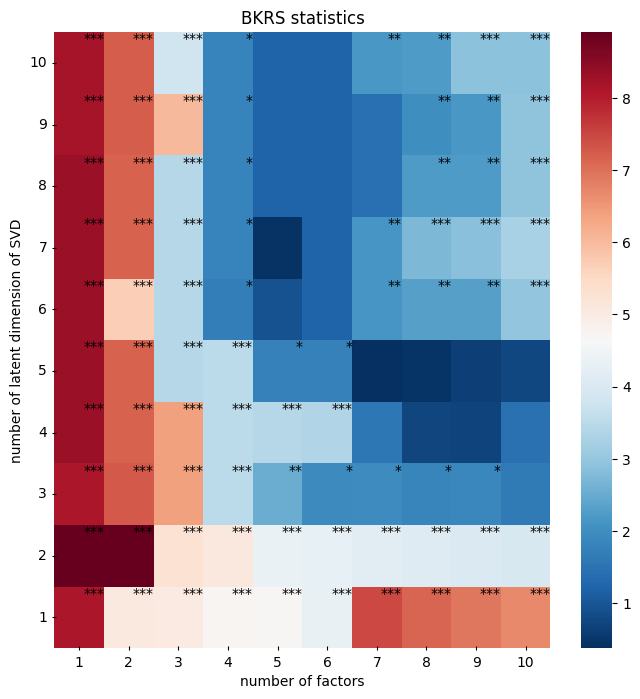

In [16]:
heatmap_sr, heatmap_py, heatmap_bkrs ,heatmap_grs  = make_heatmap(Result_all_asset,'BKRS')

In [35]:
np.array(dff100.columns)[np.array(Result_all_asset[4][0][7])]

array(['HMLM', 'MKTRF', 'IVOL', 'REG', 'CLA', 'PEAD', 'STR'], dtype=object)

In [268]:
Result_all_asset1 =[]
Klist = [1,2,3,4,5,6,7,8,9,10]
Result_all_asset1 = Parallel(n_jobs=10)(delayed(adj)('AdjSGL',Z,Z.shape[0],fama285,j, -1 ,0.01,5,10000) for j in Klist)


[78 79 91  7 31 83  6 86 95 88 51 98] ['MKTRF' 'SMB' 'IVOL' 'COP' 'EPRD' 'UMD' 'CLA' 'BAB' 'IMD' 'STR' 'NOA'
 'PEAD']
[78 79 25 84 74 93 28 56 72  2 42 94  3 82 31 90 98 22 95 19 37 35 91  9
 97 92 88 34 71 89] ['MKTRF' 'SMB' 'DTV12' 'HMLM' 'SP' 'IA' 'EBP' 'OCP' 'SGq1' 'ATO' 'IR'
 'ROE' 'BM' 'CMA' 'EPRD' 'REG' 'PEAD' 'dPIA' 'IMD' 'dNCO' 'IG' 'HS' 'IVOL'
 'CTO' 'BETA' 'SUE' 'STR' 'GPA' 'RS1' 'LTR']
[78 79 91 84 99 81 11 76 94 74 56 62 80  8 28 90 25 85  2 48 86 12 97 31
  6 98 88 95 77 10 58] ['MKTRF' 'SMB' 'IVOL' 'HMLM' 'FIN' 'RMW' 'dBE' 'TV1' 'ROE' 'SP' 'OCP'
 'P52W6' 'HML' 'CP' 'EBP' 'REG' 'DTV12' 'QMJ' 'ATO' 'ME' 'BAB' 'dCOA'
 'BETA' 'EPRD' 'CLA' 'PEAD' 'STR' 'IMD' 'VHP' 'DAC' 'OLEq1']
[78 79 84 91 62 99 81 83 76 92 56 11 90 93 98 85 86 31  2 94 74 88  6 51
 80 40  7  8 34 10 24 15  9 64 97 95 87] ['MKTRF' 'SMB' 'HMLM' 'IVOL' 'P52W6' 'FIN' 'RMW' 'UMD' 'TV1' 'SUE' 'OCP'
 'dBE' 'REG' 'IA' 'PEAD' 'QMJ' 'BAB' 'EPRD' 'ATO' 'ROE' 'SP' 'STR' 'CLA'
 'NOA' 'HML' 'IM1' 'COP' 'CP' 'GPA' 'DAC' 

In [17]:
Result_all_asset1=[({9: [78, 79, 91, 7, 31, 6, 83, 86, 95], 8: [78, 79, 7, 91, 31, 6, 83, 86], 7: [78, 79, 7, 91, 31, 6, 83], 6: [78, 79, 7, 91, 31, 6], 5: [78, 7, 79, 6, 31], 4: [78, 7, 6, 31], 3: [78, 7, 6], 2: [91, 78], 1: [91]}, {9: 0.26078610368502975, 8: 0.24354236806270496, 7: 0.2348405286832076, 6: 0.22799553698972122, 5: 0.09948293811317423, 4: 0.06434520633637411, 3: 0.05916535223230318, 2: 0.12713314338073947, 1: 0.0711290188770953}, {9: [0.0, 16.9017703676472], 8: [0.0, 18.782373655998104], 7: [0.0, 19.037026496648775], 6: [0.0, 18.405618631743646], 5: [0.0, 45.282617857748775], 4: [0.0, 42.23688017595179], 3: [0.0, 31.276257155732914], 2: [0.0, 15.517048914596417], 1: [0.0, 26.97356915276307]}, {9: [1.4918210170744572e-05, 4.329892570683172], 8: [3.757166495699238e-07, 5.080866727803765], 7: [3.544948024014616e-08, 5.512140969980558], 6: [4.056268432250931e-09, 5.881882265321864], 5: [2.220446049250313e-16, 8.181220571894576], 4: [0.0, 8.397755192529555], 3: [0.0, 8.685429693945943], 2: [3.8391512191537913e-13, 7.261144060234949], 1: [4.440892098500626e-16, 8.132259925958941]}, {9: [1.1102230246251565e-16, 3.737849685234719, 0.0], 8: [1.1102230246251565e-16, 3.823850951750853, 0.0], 7: [1.1102230246251565e-16, 3.847277693137299, 0.0], 6: [1.1102230246251565e-16, 3.8572158080232914, 0.0], 5: [1.1102230246251565e-16, 4.877898785422255, 0.0], 4: [1.1102230246251565e-16, 5.15839142959674, 0.0], 3: [1.1102230246251565e-16, 5.155387996974474, 0.0], 2: [1.1102230246251565e-16, 4.487416128512696, 0.0], 1: [1.1102230246251565e-16, 4.938410230704088, 0.0]}, 1), ({10: [78, 25, 28, 79, 74, 2, 84, 56, 90, 98], 9: [78, 25, 28, 79, 74, 2, 84, 56, 90], 8: [78, 25, 28, 79, 74, 2, 56, 90], 7: [78, 25, 28, 79, 74, 2, 56], 6: [78, 25, 28, 79, 74, 2], 5: [78, 25, 28, 79, 74], 4: [78, 25, 79, 28], 3: [78, 25, 79], 2: [78, 79], 1: [78]}, {10: 0.4262837237649721, 9: 0.3270295448530118, 8: 0.3081397128746647, 7: 0.05173966096515113, 6: 0.03619455783726856, 5: 0.028909067110358427, 4: 0.023391135666193708, 3: 0.022302134300221245, 2: 0.016274000651310787, 1: 0.015219620698530455}, {10: [2.828848266744899e-13, 7.302322864782229], 9: [0.0, 13.016655683588777], 8: [0.0, 8.914012965646405], 7: [0.0, 56.251292253098384], 6: [0.0, 59.21748376622601], 5: [0.0, 58.42959841394935], 4: [0.0, 58.88525941269967], 3: [0.0, 45.07492294285579], 2: [0.0, 42.042254393607195], 1: [0.0, 33.67685278470257]}, {10: [0.08985269542486152, 1.6961752537671937], 9: [0.0004681203641059284, 3.4983647982023864], 8: [6.027481271875246e-07, 4.990334535853861], 7: [0.0, 8.61237676513574], 6: [0.0, 8.80699803004099], 5: [0.0, 8.8645981569711], 4: [0.0, 8.844926218509128], 3: [0.0, 8.828141075417394], 2: [0.0, 8.907665120638915], 1: [0.0, 8.90993945773598]}, {10: [3.733569009511939e-12, 2.6962098759541684, 0.0], 9: [1.1102230246251565e-16, 3.2769835503674916, 0.0], 8: [1.1102230246251565e-16, 3.3666496767605527, 0.0], 7: [1.1102230246251565e-16, 5.453048792153695, 0.0], 6: [1.1102230246251565e-16, 5.555773023639134, 0.0], 5: [1.1102230246251565e-16, 5.5734837004116695, 0.0], 4: [1.1102230246251565e-16, 5.57324706373605, 0.0], 3: [1.1102230246251565e-16, 5.5271575216422875, 0.0], 2: [1.1102230246251565e-16, 5.533471597278343, 0.0], 1: [1.1102230246251565e-16, 5.488512130276129, 0.0]}, 2), ({10: [84, 78, 91, 79, 81, 99, 90, 97, 56, 62], 9: [84, 78, 91, 79, 90, 97, 81, 99, 62], 8: [84, 78, 91, 79, 90, 97, 81, 99], 7: [84, 78, 91, 79, 90, 97, 81], 6: [78, 84, 91, 79, 90, 97], 5: [78, 84, 91, 79, 90], 4: [78, 84, 91, 90], 3: [78, 84, 91], 2: [78, 91], 1: [78]}, {10: 0.406560921750377, 9: 0.4061269380334001, 8: 0.40569968447541527, 7: 0.4032564465006677, 6: 0.40070764895618705, 5: 0.3859719962067135, 4: 0.2987266833445478, 3: 0.12917438112172683, 2: 0.1271331433807395, 1: 0.015219620698530455}, {10: [0.0, 10.882349712774436], 9: [0.0, 8.953134471963178], 8: [2.220446049250313e-16, 8.198167239089555], 7: [1.6187051699034782e-13, 7.377064136713469], 6: [2.305888813225465e-11, 6.685213442575186], 5: [4.8328008261933064e-12, 6.910404857860249], 4: [0.0, 16.362711861513397], 3: [0.0, 23.926445203800434], 2: [0.0, 15.517048914596415], 1: [0.0, 33.67685278470257]}, {10: [0.05744532075041464, 1.8999070342955355], 9: [0.05871571108927709, 1.890315993123605], 8: [0.04584467604594655, 1.9968205897755011], 7: [0.050604026855459505, 1.9548224800061746], 6: [0.05501104744196472, 1.918788961212054], 5: [0.01274879167503129, 2.490710596242777], 4: [0.00048813213020015844, 3.4871857895745544], 3: [1.559632423209223e-10, 6.399424988683625], 2: [3.8391512191537913e-13, 7.261144060234949], 1: [0.0, 8.90993945773598]}, {10: [3.8691272408186705e-13, 2.8119161588174895, 0.0], 9: [5.504485756091526e-13, 2.783570118767821, 0.0], 8: [7.805978086139476e-13, 2.7558026421498267, 0.0], 7: [8.735234757750732e-13, 2.7402778062585367, 0.0], 6: [9.632294961647858e-13, 2.725738203595756, 0.0], 5: [2.5557334026871104e-13, 2.7816791039831514, 0.0], 4: [1.1102230246251565e-16, 3.2875064367547595, 0.0], 3: [1.1102230246251565e-16, 4.5161643285854405, 0.0], 2: [1.1102230246251565e-16, 4.4874161285127006, 0.0], 1: [1.1102230246251565e-16, 5.488512130276129, 0.0]}, 3), ({10: [84, 91, 78, 62, 6, 90, 97, 79, 86, 98], 9: [84, 91, 78, 62, 6, 90, 97, 79, 86], 8: [84, 91, 78, 62, 6, 90, 97, 79], 7: [84, 91, 78, 62, 6, 90, 97], 6: [84, 91, 78, 62, 6, 90], 5: [84, 78, 91, 90, 62], 4: [84, 78, 91, 90], 3: [84, 78, 91], 2: [84, 91], 1: [84]}, {10: 0.5141486595453288, 9: 0.41594168114826896, 8: 0.4089694298837367, 7: 0.34590861584498306, 6: 0.31120544666551564, 5: 0.30248156610852794, 4: 0.2987266833445478, 3: 0.12917438112172686, 2: 0.0781611588354988, 1: 0.008241569029185306}, {10: [0.0001767435245576543, 3.750129139260574], 9: [0.0, 8.712990306025178], 8: [8.881784197001252e-16, 8.05741174078352], 7: [0.0, 13.89670703723142], 6: [0.0, 17.295179197001705], 5: [0.0, 18.963463927217887], 4: [0.0, 16.362711861513375], 3: [0.0, 23.92644520380043], 2: [0.0, 34.27744736836267], 1: [0.0, 28.91510306512162]}, {10: [0.9605752958260789, 0.04943166268060682], 9: [0.11503758803273834, 1.5759488659121645], 8: [0.07936133866700601, 1.7544038117298693], 7: [0.015049509529799332, 2.4311854472850594], 6: [0.0008030513323140642, 3.3517409161114093], 5: [0.0006151314737026237, 3.4248532996286034], 4: [0.00048813213020015844, 3.4871857895745584], 3: [1.559632423209223e-10, 6.399424988683625], 2: [8.275602425555917e-13, 7.1564966772281045], 1: [0.0, 8.330383593565047]}, {10: [3.329143904995391e-08, 2.2173659822958713, 0.0], 9: [1.7081891456882659e-12, 2.726189799570039, 0.0], 8: [1.1386447340555605e-12, 2.736795041312365, 0.0], 7: [7.771561172376096e-16, 3.086119011445016, 0.0], 6: [1.1102230246251565e-16, 3.274878018428023, 0.0], 5: [1.1102230246251565e-16, 3.29736156626911, 0.0], 4: [1.1102230246251565e-16, 3.287506436754761, 0.0], 3: [1.1102230246251565e-16, 4.5161643285854405, 0.0], 2: [1.1102230246251565e-16, 4.922986203961479, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 4), ({10: [84, 91, 78, 90, 6, 98, 86, 88, 16, 62], 9: [84, 91, 78, 90, 6, 98, 88, 86, 16], 8: [84, 91, 78, 90, 6, 98, 88, 86], 7: [84, 91, 78, 90, 6, 98, 88], 6: [84, 91, 78, 90, 98, 6], 5: [84, 91, 78, 90, 98], 4: [84, 91, 78, 90], 3: [84, 91, 78], 2: [91, 84], 1: [91]}, {10: 0.497452150666623, 9: 0.4768974105744356, 8: 0.4755538308032229, 7: 0.4667422469819218, 6: 0.4092294829342158, 5: 0.4072902622215314, 4: 0.2987266833445478, 3: 0.1291743811217268, 2: 0.07816115883549879, 1: 0.0711290188770953}, {10: [0.0, 9.941404629632897], 9: [0.0, 10.7017935783277], 8: [0.0, 10.221000041441199], 7: [0.0, 9.545811174802001], 6: [0.0, 8.82559095708609], 5: [0.0, 8.33081075569182], 4: [0.0, 16.362711861513393], 3: [0.0, 23.926445203800437], 2: [0.0, 34.27744736836268], 1: [0.0, 26.97356915276307]}, {10: [0.3213079070934173, 0.9917737466722419], 9: [0.5282661641691, 0.6306549454128348], 8: [0.5827997274355738, 0.5492997958675252], 7: [0.705684960067132, 0.3776576124801263], 6: [0.0771938237407177, 1.7672054713332233], 5: [0.07987564517011214, 1.7514080626566608], 4: [0.00048813213020015844, 3.4871857895745593], 3: [1.559632423209223e-10, 6.39942498868363], 2: [8.275602425555917e-13, 7.1564966772281045], 1: [4.440892098500626e-16, 8.132259925958941]}, {10: [6.72041788885025e-09, 2.3040336286794014, 0.0], 9: [1.226722057268148e-09, 2.386898475438241, 0.0], 8: [1.5173425849113187e-09, 2.368052409878405, 0.0], 7: [8.784040161913254e-10, 2.3889616570882457, 0.0], 6: [2.558064871038823e-12, 2.67708949633601, 0.0], 5: [3.0120350658080497e-12, 2.6598122938527062, 0.0], 4: [1.1102230246251565e-16, 3.2875064367547564, 0.0], 3: [1.1102230246251565e-16, 4.516164328585444, 0.0], 2: [1.1102230246251565e-16, 4.922986203961479, 0.0], 1: [1.1102230246251565e-16, 4.938410230704088, 0.0]}, 5), ({10: [91, 84, 85, 79, 90, 25, 98, 88, 10, 20], 9: [91, 84, 85, 79, 90, 98, 25, 88, 10], 8: [84, 91, 85, 90, 79, 98, 25, 88], 7: [84, 91, 85, 90, 79, 98, 25], 6: [84, 91, 90, 85, 79, 25], 5: [84, 91, 90, 85, 79], 4: [84, 91, 90, 85], 3: [84, 91, 90], 2: [84, 91], 1: [84]}, {10: 0.5548943058612825, 9: 0.5513616876015924, 8: 0.5444992237605342, 7: 0.4942059059564412, 6: 0.39588473787999384, 5: 0.3916000003820324, 4: 0.2999786204460505, 3: 0.298616887961398, 2: 0.0781611588354988, 1: 0.008241569029185306}, {10: [9.416264568073984e-08, 5.337642972322063], 9: [3.6519493940012637e-07, 5.086259165685603], 8: [2.4618261207365322e-08, 5.5759500155720945], 7: [7.477611947415141e-07, 4.948529861790144], 6: [0.0, 9.382980973333577], 5: [0.0, 8.772202041801156], 4: [0.0, 19.718007018796712], 3: [0.0, 13.165404445242899], 2: [0.0, 34.27744736836267], 1: [0.0, 28.91510306512162]}, {10: [0.013637168535658883, 2.466681267126717], 9: [0.014810696585286776, 2.436975163330723], 8: [0.022118580064548254, 2.2883253714108087], 7: [0.7728993989930302, 0.28858444680774076], 6: [0.12913630291692013, 1.5175166106709652], 5: [0.09185718233787088, 1.6856813945999165], 4: [0.005239895954594065, 2.7919036300683118], 3: [0.000584502177221724, 3.4387057510638797], 2: [8.275602425555917e-13, 7.1564966772281045], 1: [0.0, 8.330383593565047]}, {10: [1.2729019305268707e-06, 2.0136783678843417, 0.0], 9: [1.2633347861168431e-06, 2.0085965918277466, 0.0], 8: [9.428624697660482e-07, 2.0197391713473998, 0.0], 7: [1.3348875116392378e-08, 2.246234535001859, 0.0], 6: [5.504485756091526e-13, 2.7535340338962047, 0.0], 5: [4.948264020754323e-13, 2.7491436223748367, 0.0], 4: [1.1102230246251565e-16, 3.279324566030648, 0.0], 3: [1.1102230246251565e-16, 3.254325518359087, 0.0], 2: [1.1102230246251565e-16, 4.922986203961479, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 6), ({10: [91, 84, 85, 88, 25, 90, 98, 93, 62, 79], 9: [91, 84, 85, 88, 90, 25, 98, 93, 62], 8: [91, 84, 85, 88, 90, 25, 98, 93], 7: [91, 84, 85, 88, 90, 25, 98], 6: [91, 84, 90, 88, 85, 98], 5: [84, 91, 90, 88, 85], 4: [84, 91, 90, 88], 3: [84, 91, 90], 2: [84, 91], 1: [84]}, {10: 0.565446233428589, 9: 0.5559741286131124, 8: 0.5378812972297723, 7: 0.53130094622154, 6: 0.47204812510719624, 5: 0.32379494204523546, 4: 0.3212924837581452, 3: 0.298616887961398, 2: 0.0781611588354988, 1: 0.008241569029185306}, {10: [2.4898527684058536e-11, 6.673963518411748], 9: [2.1760371282653068e-14, 7.639840914506021], 8: [0.0, 10.088529967705162], 7: [9.33186861118429e-12, 6.816449184552549], 6: [0.0, 12.864349441620185], 5: [0.0, 23.439422131235602], 4: [0.0, 16.057308594827845], 3: [0.0, 13.165404445242899], 2: [0.0, 34.27744736836267], 1: [0.0, 28.91510306512162]}, {10: [0.006466347852603471, 2.7231459776897244], 9: [0.009148351593473825, 2.6064599723578543], 8: [0.025444837337460724, 2.234581487286738], 7: [0.03282334283441091, 2.1342375200102537], 6: [0.22747849342701731, 1.206879656187021], 5: [0.22611251794657794, 1.2104336976723917], 4: [0.07335192762510756, 1.7906347448890445], 3: [0.000584502177221724, 3.4387057510638797], 2: [8.275602425555917e-13, 7.1564966772281045], 1: [0.0, 8.330383593565047]}, {10: [3.0743947700972996e-06, 1.9626577666049225, 0.0], 9: [1.8631496770948885e-06, 1.9863548237030657, 0.0], 8: [5.326917573711398e-07, 2.051818030457751, 0.0], 7: [4.0386924027302484e-07, 2.0615811776272337, 0.0], 6: [2.1199783040160014e-09, 2.33585551610533, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934445, 0.0], 4: [1.1102230246251565e-16, 3.142409550974844, 0.0], 3: [1.1102230246251565e-16, 3.254325518359087, 0.0], 2: [1.1102230246251565e-16, 4.922986203961479, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 7), ({10: [91, 84, 88, 85, 79, 90, 98, 62, 93, 25], 9: [91, 84, 88, 85, 90, 79, 98, 62, 93], 8: [91, 84, 88, 85, 90, 79, 98, 62], 7: [84, 91, 88, 85, 90, 79, 98], 6: [84, 91, 88, 85, 90, 98], 5: [84, 91, 90, 88, 85], 4: [84, 91, 90, 88], 3: [84, 91, 90], 2: [84, 91], 1: [84]}, {10: 0.5654462334285891, 9: 0.5651487576423699, 8: 0.545259056119518, 7: 0.5437754910896571, 6: 0.4720481251071963, 5: 0.32379494204523546, 4: 0.3212924837581452, 3: 0.298616887961398, 2: 0.0781611588354988, 1: 0.008241569029185306}, {10: [2.4898527684058536e-11, 6.673963518411764], 9: [2.6022251020663134e-10, 6.320794183743114], 8: [3.134381643121742e-12, 6.971567059974898], 7: [6.270971868449493e-07, 4.982679663998705], 6: [0.0, 12.86434944162021], 5: [0.0, 23.439422131235602], 4: [0.0, 16.057308594827845], 3: [0.0, 13.165404445242899], 2: [0.0, 34.27744736836267], 1: [0.0, 28.91510306512162]}, {10: [0.006466347852603249, 2.723145977689727], 9: [0.009019746269400164, 2.61130480286876], 8: [0.02524269570998139, 2.2376682729254256], 7: [0.03166783643170712, 2.148578387551264], 6: [0.2274784934270171, 1.2068796561870212], 5: [0.22611251794657794, 1.2104336976723917], 4: [0.07335192762510756, 1.7906347448890445], 3: [0.000584502177221724, 3.4387057510638797], 2: [8.275602425555917e-13, 7.1564966772281045], 1: [0.0, 8.330383593565047]}, {10: [3.0743947700972996e-06, 1.9626577666049236, 0.0], 9: [3.976220819379428e-06, 1.94250332530451, 0.0], 8: [1.0060947477352755e-06, 2.016073645591831, 0.0], 7: [1.185063564945743e-06, 2.001478699668086, 0.0], 6: [2.1199783040160014e-09, 2.33585551610533, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934445, 0.0], 4: [1.1102230246251565e-16, 3.142409550974844, 0.0], 3: [1.1102230246251565e-16, 3.254325518359087, 0.0], 2: [1.1102230246251565e-16, 4.922986203961479, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 8), ({10: [91, 84, 88, 85, 90, 79, 98, 62, 93, 31], 9: [91, 84, 88, 85, 90, 79, 98, 62, 93], 8: [91, 84, 88, 85, 90, 79, 98, 62], 7: [91, 84, 88, 85, 90, 98, 79], 6: [84, 91, 88, 85, 90, 98], 5: [84, 91, 88, 90, 85], 4: [84, 91, 88, 90], 3: [84, 91, 88], 2: [84, 88], 1: [84]}, {10: 0.577691046673712, 9: 0.5651487576423699, 8: 0.545259056119518, 7: 0.5437754910896571, 6: 0.4720481251071963, 5: 0.32379494204523546, 4: 0.32129248375814506, 3: 0.07993659492063435, 2: 0.019782300624978797, 1: 0.008241569029185306}, {10: [1.1365619556613638e-10, 6.4475719806918566], 9: [2.6022251020663134e-10, 6.320794183743114], 8: [3.134381643121742e-12, 6.971567059974898], 7: [6.270971868449493e-07, 4.982679663998806], 6: [0.0, 12.86434944162021], 5: [0.0, 23.43942213123561], 4: [0.0, 16.057308594827845], 3: [0.0, 40.72278203785439], 2: [0.0, 38.724200859047734], 1: [0.0, 28.91510306512162]}, {10: [0.0007465388966074737, 3.371891361344454], 9: [0.009019746269400164, 2.61130480286876], 8: [0.02524269570998139, 2.2376682729254256], 7: [0.03166783643170734, 2.1485783875512623], 6: [0.2274784934270171, 1.2068796561870212], 5: [0.22611251794657816, 1.2104336976723915], 4: [0.07335192762510712, 1.7906347448890478], 3: [1.5336127923148979e-09, 6.040790194007612], 2: [5.262457136723242e-13, 7.218360778296648], 1: [0.0, 8.330383593565047]}, {10: [8.27899211497396e-06, 1.9043072306993412, 0.0], 9: [3.976220819379428e-06, 1.94250332530451, 0.0], 8: [1.0060947477352755e-06, 2.016073645591831, 0.0], 7: [1.185063564945743e-06, 2.0014786996680893, 0.0], 6: [2.1199783040160014e-09, 2.33585551610533, 0.0], 5: [1.1102230246251565e-16, 3.159535409293443, 0.0], 4: [1.1102230246251565e-16, 3.1424095509748544, 0.0], 3: [1.1102230246251565e-16, 4.957087395323444, 0.0], 2: [1.1102230246251565e-16, 5.4968828391701265, 0.0], 1: [1.1102230246251565e-16, 5.561452791215578, 0.0]}, 9), ({10: [91, 84, 88, 85, 79, 90, 98, 13, 62, 31], 9: [91, 84, 88, 85, 90, 79, 98, 13, 62], 8: [91, 84, 88, 85, 90, 79, 98, 13], 7: [84, 91, 88, 85, 90, 79, 98], 6: [84, 88, 91, 85, 90, 98], 5: [84, 88, 91, 90, 85], 4: [88, 84, 91, 90], 3: [88, 84, 91], 2: [88, 84], 1: [88]}, {10: 0.5584222255115496, 9: 0.5498631595651134, 8: 0.5493934797291554, 7: 0.5437754910896571, 6: 0.47204812510719624, 5: 0.32379494204523546, 4: 0.32129248375814506, 3: 0.07993659492063433, 2: 0.019782300624978797, 1: 0.016203917181884957}, {10: [1.0480505352461478e-13, 7.434561502331651], 9: [1.1519851739194564e-10, 6.445528062672859], 8: [4.8630251152648185e-06, 4.570611750402976], 7: [6.270971868449493e-07, 4.982679663998705], 6: [0.0, 12.864349441620167], 5: [0.0, 23.43942213123562], 4: [0.0, 16.057308594827838], 3: [0.0, 40.72278203785438], 2: [0.0, 38.72420085904775], 1: [0.0, 30.35921182876951]}, {10: [0.0037613668921789856, 2.8975108819387136], 9: [0.025958739327841984, 2.2268284781588297], 8: [0.03164075468227612, 2.148919841480186], 7: [0.03166783643170712, 2.148578387551264], 6: [0.22747849342701887, 1.2068796561870165], 5: [0.2261125179465786, 1.2104336976723906], 4: [0.07335192762510667, 1.7906347448890505], 3: [1.5336127923148979e-09, 6.04079019400761], 2: [5.262457136723242e-13, 7.218360778296648], 1: [2.220446049250313e-16, 8.208082041989968]}, {10: [1.7142905129885477e-06, 1.9965433138156696, 0.0], 9: [1.1123460249562456e-06, 2.0158511734774565, 0.0], 8: [1.4289408732937048e-06, 1.9961916747349984, 0.0], 7: [1.185063564945743e-06, 2.001478699668086, 0.0], 6: [2.1199783040160014e-09, 2.335855516105336, 0.0], 5: [1.1102230246251565e-16, 3.1595354092934445, 0.0], 4: [1.1102230246251565e-16, 3.1424095509748455, 0.0], 3: [1.1102230246251565e-16, 4.957087395323449, 0.0], 2: [1.1102230246251565e-16, 5.49688283917014, 0.0], 1: [1.1102230246251565e-16, 5.478304024035181, 0.0]}, 10)]

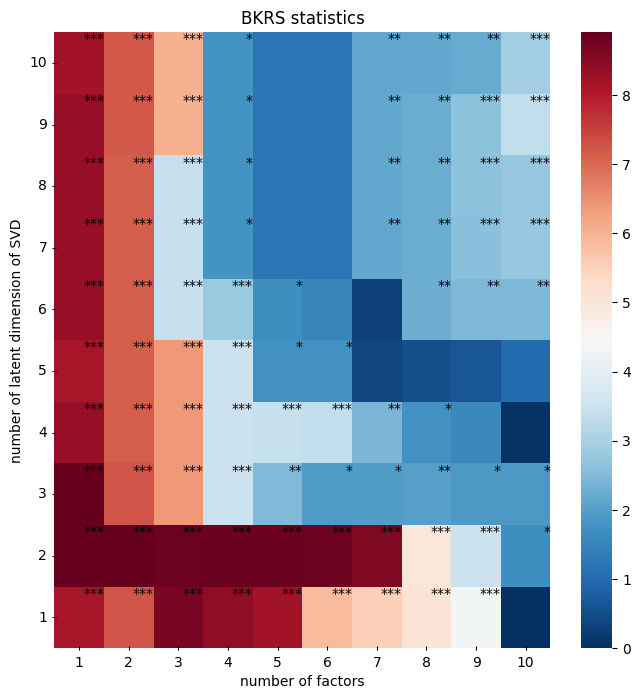

In [18]:
heatmap_sr, heatmap_py, heatmap_bkrs ,heatmap_grs  = make_heatmap(Result_all_asset1,'BKRS')

In [36]:
np.array(dff100.columns)[np.array(Result_all_asset1[4][0][7])]

array(['HMLM', 'IVOL', 'MKTRF', 'REG', 'CLA', 'PEAD', 'STR'], dtype=object)

In [ ]:
grs={}
for i in range(10):
    for j in Result_all_asset1[i][0].keys():
        grs[j]=GRS_test(dff100)
        print(j)